In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style
from TCGA_files import get_tcga_tissue

In [129]:
l = 3
#setup = '5000doc_0.25occ_fpkmweight_thr'
#setup='overlap_5000doc_0.25occ_fpkmweight_thr'
setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
#directory = '/Users/filippo/Developer/tesi/results/hSBM/%s/topsbm'%(setup)
#directory = '/Users/filippo/Developer/tesi/gtex/hsbm/%s'%setup
#directory='/Users/filippo/Developer/tesi/merged/hsbm'
directory = "/Volumes/GoogleDrive/My Drive/tesi_magistrale/tesi/results/hSBM/1000doc_0.5occ_fpkmweight_thr/"

In [130]:
df = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l))
df.head()

i_doc                                   doc   Topic 1  Topic 2   Topic 3  \
0      0  007f49fe-d251-4ae4-9313-86d765b13499  0.023256      0.0  0.000000   
1      1  009ff7e3-8bd3-4683-adf5-7b68a0859f35  0.000000      0.0  0.000000   
2      2  00e2c524-8a29-46d7-bf88-ed5f9c3dcf32  0.000000      0.3  0.000000   
3      3  00eb7c26-84fd-4ab9-93a1-3d209dfc0f43  0.000000      0.0  0.000000   
4      4  01188815-3676-4980-9cb8-7666169328f1  0.000000      0.0  0.023256   

   Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  ...  Topic 164  Topic 165  \
0      0.0      0.0      0.0      0.0      0.0  ...        0.0        0.0   
1      0.0      0.0      0.0      0.0      0.0  ...        0.0        0.0   
2      0.0      0.0      0.0      0.0      0.0  ...        0.0        0.0   
3      0.0      0.0      0.0      0.0      0.0  ...        0.0        0.0   
4      0.0      0.0      0.0      0.0      0.0  ...        0.0        0.0   

   Topic 166  Topic 167  Topic 168  Topic 169  Topic 170  Topic 171  \
0        0.0        0.0        0.0        0.0        0.0   0.000000   
1        0.0        0.0        0.0        0.0        0.0   0.000000   
2        0.0        0.0        0.0        0.0        0.0   0.033333   
3        0.0        0.0        0.0        0.0        0.0   0.000000   
4        0.0        0.0        0.0        0.0        0.0   0.000000   

   Topic 172  Topic 173  
0        0.0        0.0  
1        0.0        0.0  
2        0.0        0.0  
3        0.0        0.0  
4        0.0        0.0  

[5 rows x 175 columns]

In [4]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, l, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc)

## Topic distr

### kl

In [ ]:
l=3

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files['primary_site'].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [131]:
l=3

In [135]:
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l))
df_files = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)['primary_site']))

<Figure size 432x288 with 0 Axes>

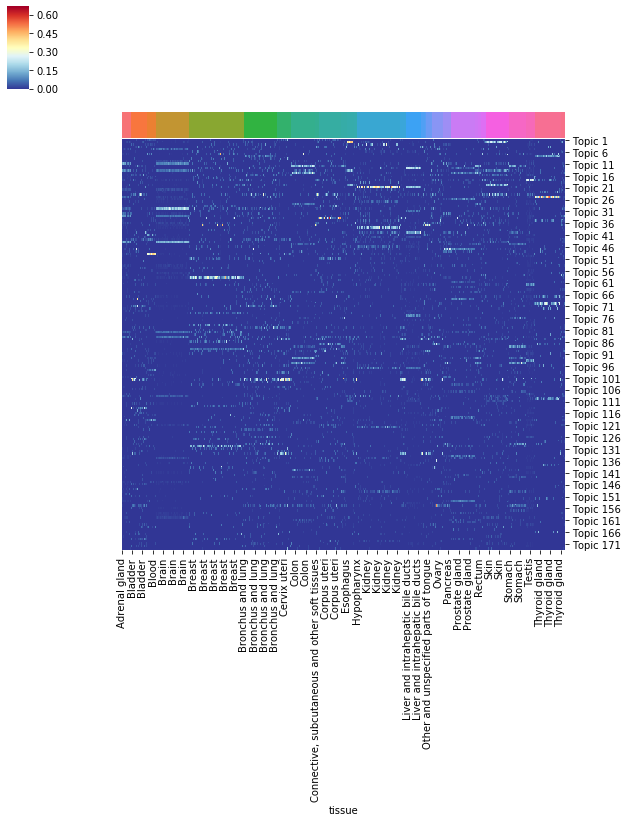

In [136]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', vmin=0, cmap='RdYlBu_r', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [137]:
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)['primary_site'])

Uterus, NOS
Breast
Skin
Prostate gland
Pancreas
Brain
Ovary
Stomach
Kidney
Hypopharynx
Bronchus and lung
Colon
Testis
Liver and intrahepatic bile ducts
Corpus uteri
Connective, subcutaneous and other soft tissues
Other endocrine glands and related structures
Bladder
Other and ill-defined sites in lip, oral cavity and pharynx
Cervix uteri
Adrenal gland
Blood
Small intestine
Larynx
Thyroid gland
Retroperitoneum and peritoneum
Eye and adnexa
Oropharynx
Other and unspecified parts of tongue
Rectosigmoid junction
Esophagus
Gum
Rectum
Heart, mediastinum, and pleura
Floor of mouth
Tonsil
Other and unspecified parts of mouth
Thymus
Palate
Other and unspecified male genital organs
Other and unspecified parts of biliary tract
Spinal cord, cranial nerves, and other parts of central nervous system


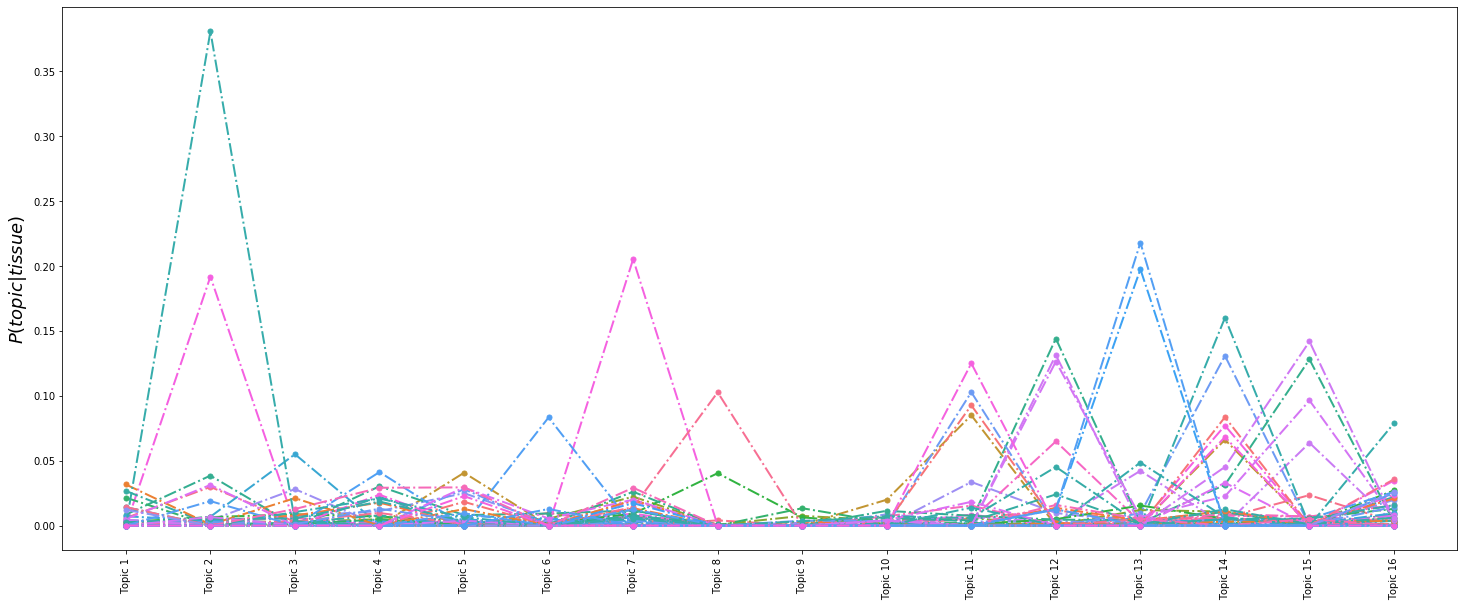

In [139]:
fig = plt.figure(figsize=(25,10))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        plt.plot(df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:16]].mean(axis=0), ls=ls,marker=marker, lw=2, ms=10, label=tissue, c=network_lut[df_files[df_files['primary_site']==tissue]['primary_site'][0]])
    except:
        pass
plt.xticks(rotation=90)
plt.ylabel("$P(topic | tissue)$", fontsize=18)
#plt.legend(fontsize=18)
plt.show()
fig.savefig("%s/lifeplot.pdf"%directory)

In [140]:
expressedtopics = df_topics.drop('tissue', axis=1).mean(axis=0).sort_values(ascending=False).index

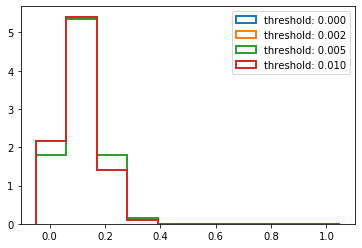

In [141]:
fig=plt.figure()
for thr in [0, 0.002, 0.005,0.01]:
    plt.hist(df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>thr])/float(len(x)), axis=1), histtype='step', density=True, range=(-0.05,1.05), bins=10, lw=2, label="threshold: %.3f"%thr)
plt.legend()
fig.savefig("%s/distr_topicU.pdf"%directory)

In [142]:
topic_table = df_topics.drop('tissue', axis=1).transpose()
topic_table.insert(0,'occ', df_topics.drop('tissue', axis=1).transpose().apply(lambda x: len(x[x>0.002])/float(len(x)), axis=1).values)

In [143]:
low_occ_topics = topic_table[topic_table['occ']<0.5].index.values
l_topics_i = [int(t[6:])-1 for t in low_occ_topics]
#l_topics_i = np.random.randint(0,100,10)

In [ ]:
import findspark
findspark.init()
import pyspark as spark
import tensorflow as tf
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [164]:
df_files_pd = pd.read_csv("%s/files.dat"%directory, index_col=0)
df_topics = sql.read.option("header","true").csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l))
df_files = sql.read.option("header","true").csv("%s/files.dat"%(directory))
df_files.registerTempTable("file")
df_topics = df_topics.withColumn('status', udf(lambda x: 'healthy' if 'GTEX' in x else 'tumour', StringType())(col('doc')))
df_topics = df_topics.withColumn('tissue', udf(lambda x: get_file(x, df_files_pd)['primary_site'], StringType())(col('doc')))
df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)['disease_type'], StringType())(col('doc')))
#df_topics = df_topics.withColumn('second_tissue', udf(lambda x: get_file(x, df_files_pd)['secondary_site'], StringType())(col('doc')))
df_topics.registerTempTable("topic")

In [145]:
dftf_h = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='healthy'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(sql.sql("SELECT * FROM topic WHERE status='tumour'").toPandas().drop(['doc','i_doc', 'status', 'tissue','second_tissue'], axis=1).astype(float).values)

Py4JJavaError: An error occurred while calling o1721.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 130.0 failed 1 times, most recent failure: Lost task 0.0 in stage 130.0 (TID 130, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4381, in get_value
    return libindex.get_value_box(s, key)
  File "pandas/_libs/index.pyx", line 52, in pandas._libs.index.get_value_box
  File "pandas/_libs/index.pyx", line 48, in pandas._libs.index.get_value_at
  File "pandas/_libs/util.pxd", line 113, in pandas._libs.util.get_value_at
  File "pandas/_libs/util.pxd", line 98, in pandas._libs.util.validate_indexer
TypeError: 'str' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-144-8f4f4dc8b958>", line 7, in <lambda>
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/series.py", line 868, in __getitem__
    result = self.index.get_value(self, key)
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4389, in get_value
    raise e1
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4375, in get_value
    tz=getattr(series.dtype, 'tz', None))
  File "pandas/_libs/index.pyx", line 81, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 89, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1601, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1608, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'secondary_site'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3257)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3254)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3254)
	at sun.reflect.GeneratedMethodAccessor60.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4381, in get_value
    return libindex.get_value_box(s, key)
  File "pandas/_libs/index.pyx", line 52, in pandas._libs.index.get_value_box
  File "pandas/_libs/index.pyx", line 48, in pandas._libs.index.get_value_at
  File "pandas/_libs/util.pxd", line 113, in pandas._libs.util.get_value_at
  File "pandas/_libs/util.pxd", line 98, in pandas._libs.util.validate_indexer
TypeError: 'str' object cannot be interpreted as an integer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/usr/local/opt/apache-spark/libexec/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-144-8f4f4dc8b958>", line 7, in <lambda>
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/series.py", line 868, in __getitem__
    result = self.index.get_value(self, key)
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4389, in get_value
    raise e1
  File "/Users/filippo/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 4375, in get_value
    tz=getattr(series.dtype, 'tz', None))
  File "pandas/_libs/index.pyx", line 81, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 89, in pandas._libs.index.IndexEngine.get_value
  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1601, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1608, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'secondary_site'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [101]:
with tf.Session() as sess:
    results = sess.run([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)])

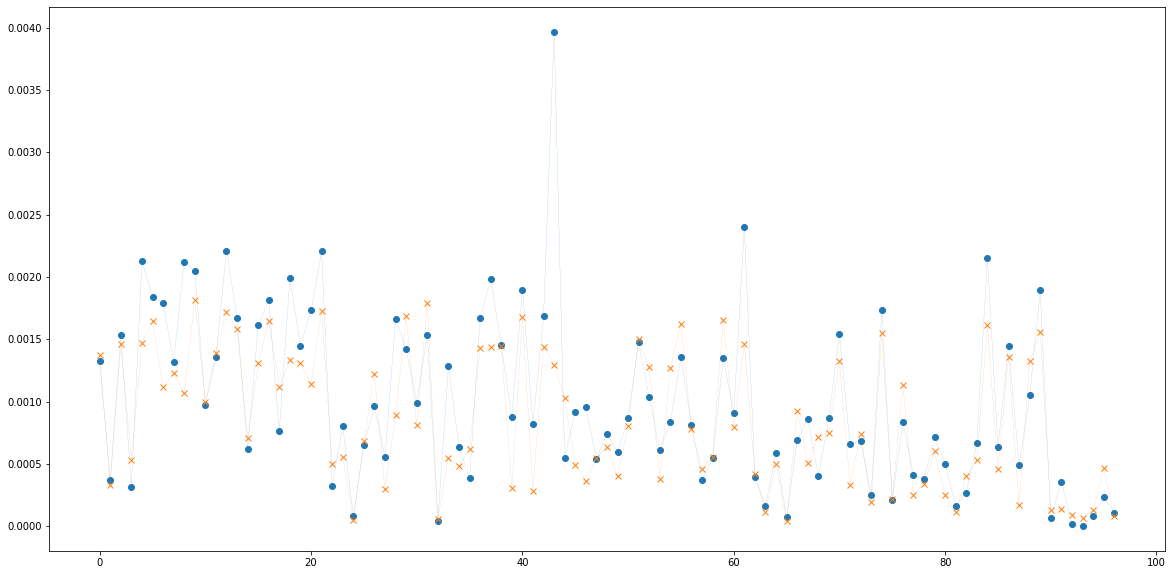

In [103]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0][l_topics_i], marker='o', lw=0.1)
plt.plot(results[1][l_topics_i],marker='x', lw=0.1)
plt.show()

In [165]:
df_all = tf.convert_to_tensor(sql.sql("SELECT * FROM topic").toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float))

In [166]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [167]:
with tf.Session() as sess:
    result = sess.run([normed_df])

breast-gtex


/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/filippo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


breast-tcga
colon-gtex
colon-tcga
thyroid-gtex
thyroid-tcga


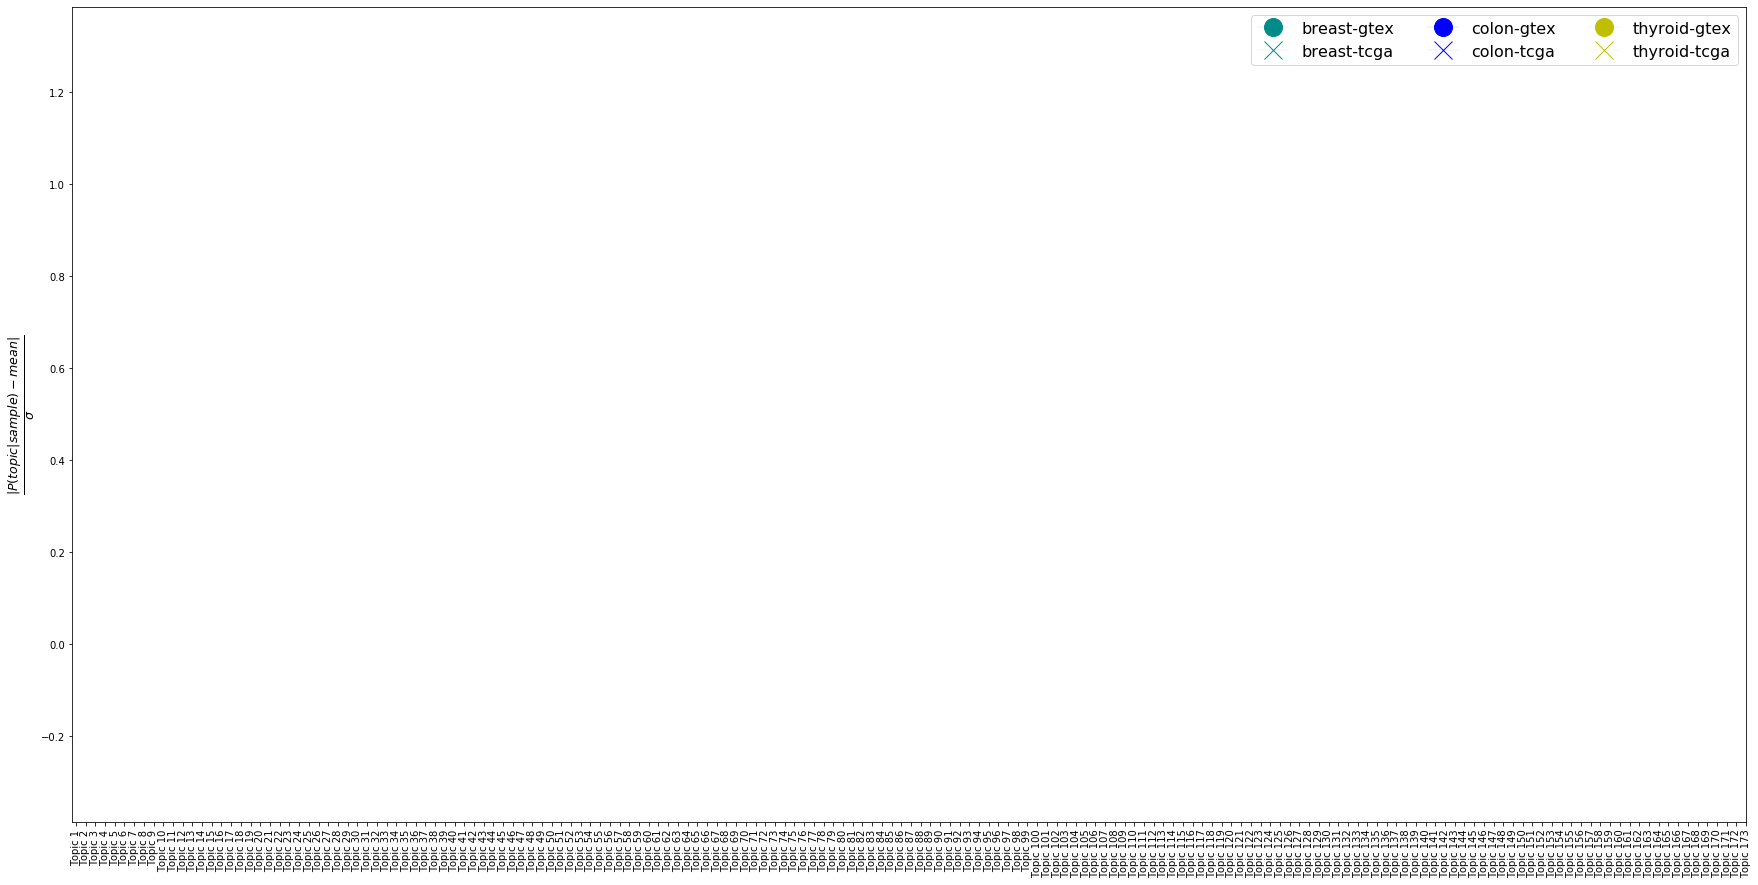

In [168]:
fig=plt.figure(figsize=(30,15))
label = 'tissue'
for tissue in ['breast-gtex', 'breast-tcga', 'colon-gtex', 'colon-tcga','thyroid-gtex','thyroid-tcga']:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=16, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | sample) - mean\\right|}{\sigma}$", fontsize=18)
plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90)
#plt.yscale('log')
plt.show()
fig.savefig("%s/lifeplot_normalised_level%d_hd.pdf"%(directory,l))

Other endocrine glands and related structures


<Figure size 2160x1080 with 0 Axes>

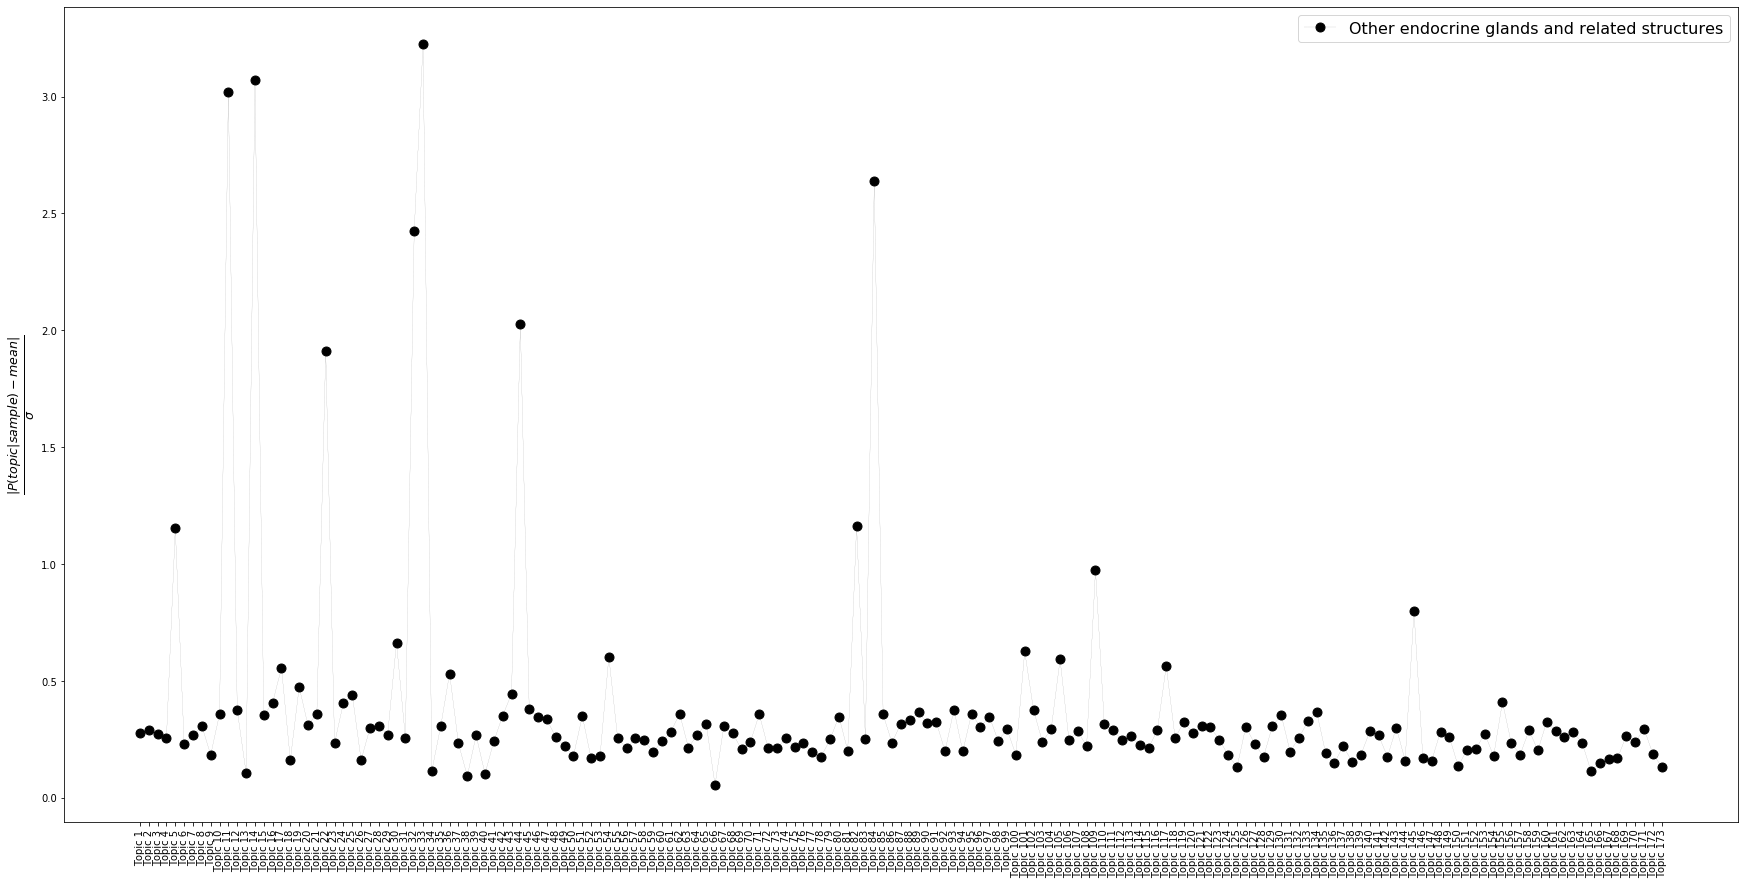

Liver and intrahepatic bile ducts


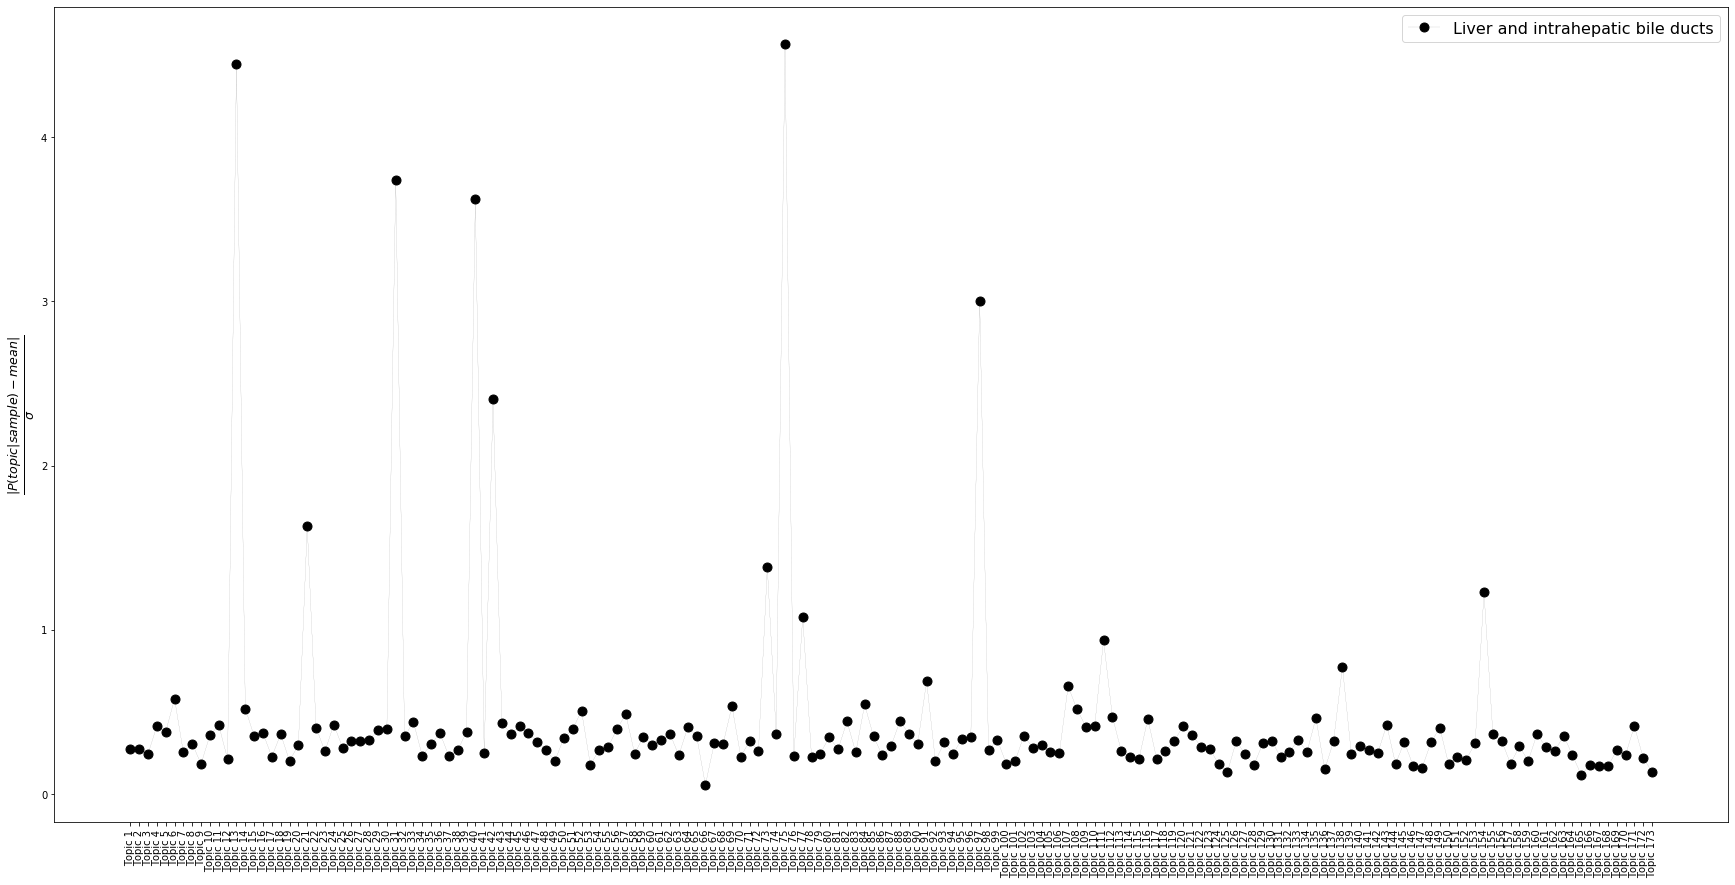

Small intestine


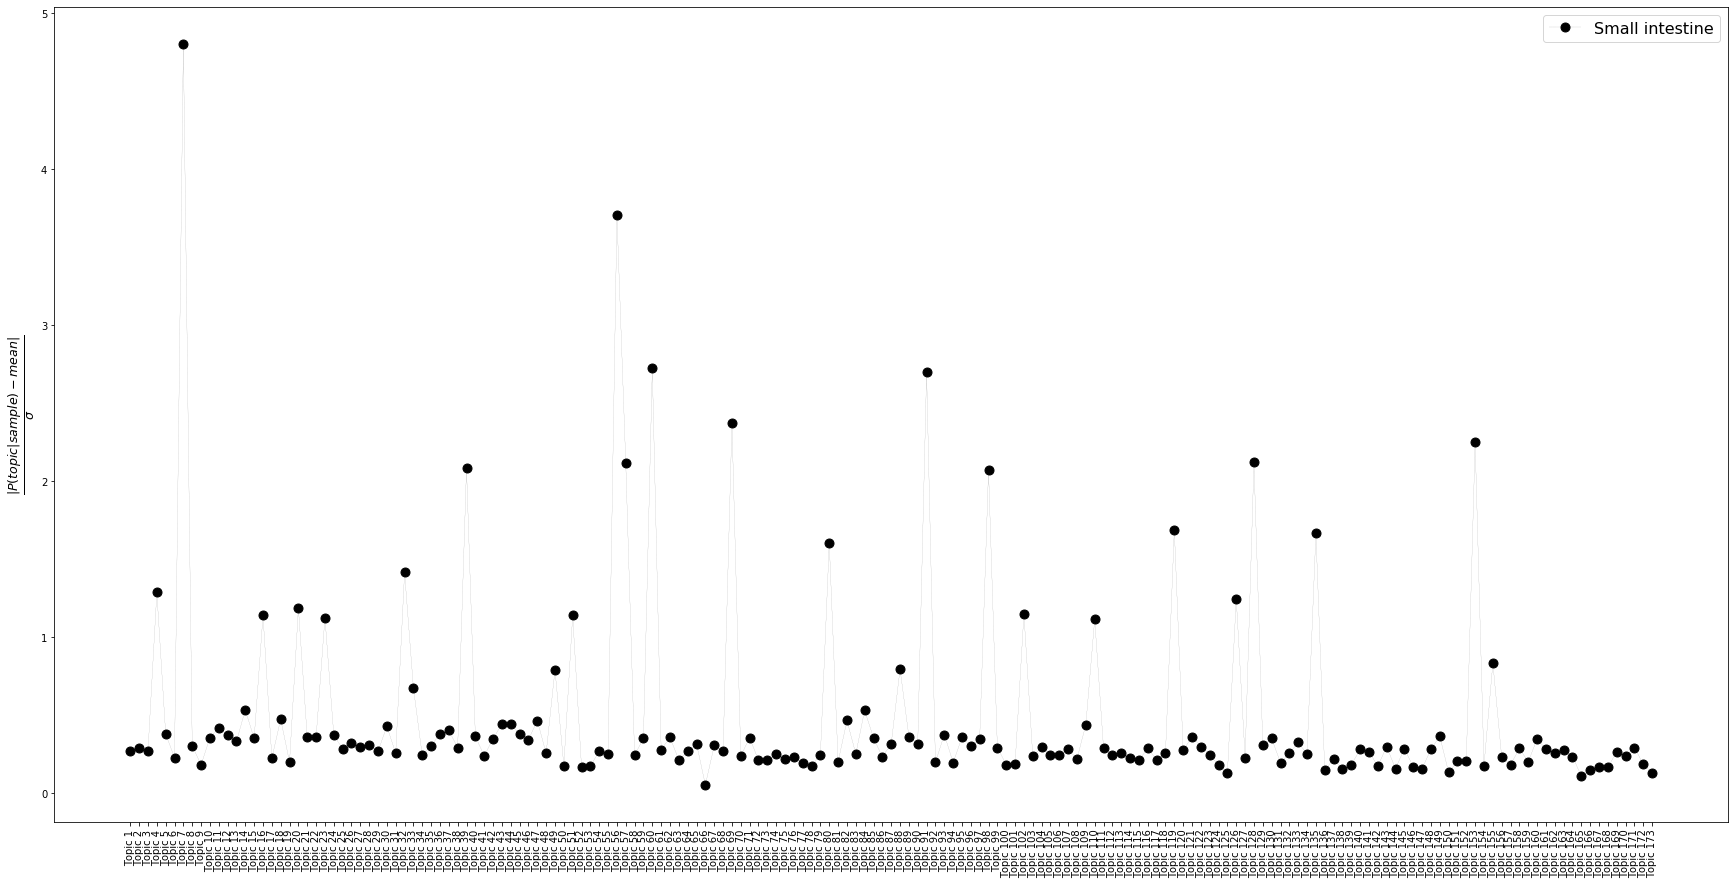

Skin


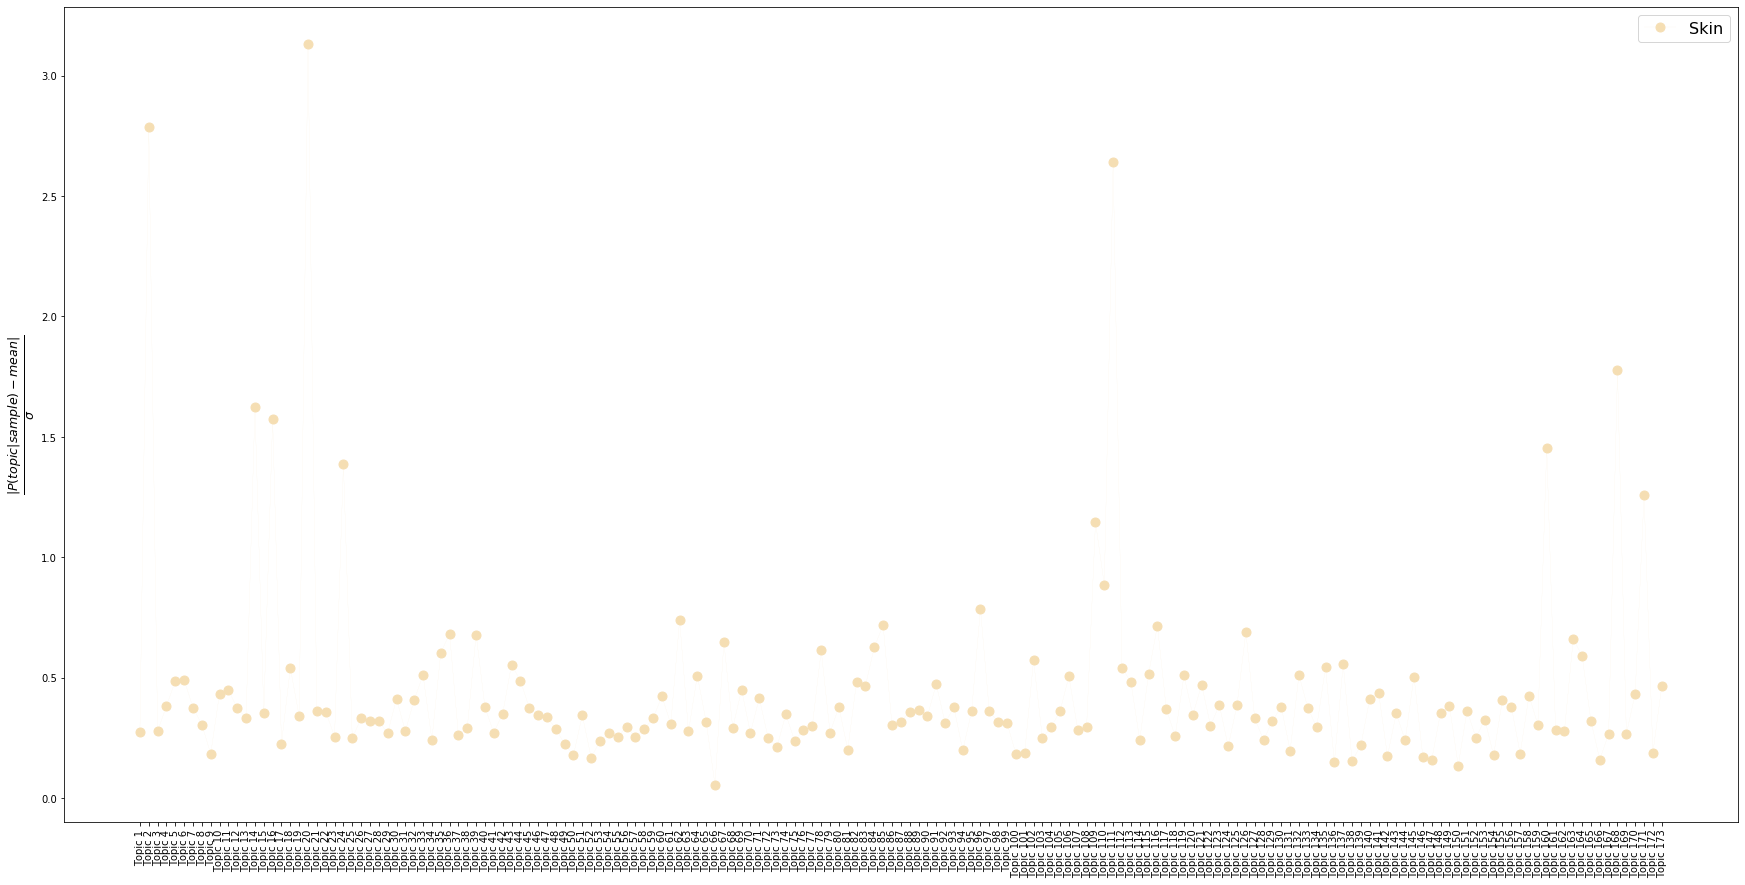

Bronchus and lung


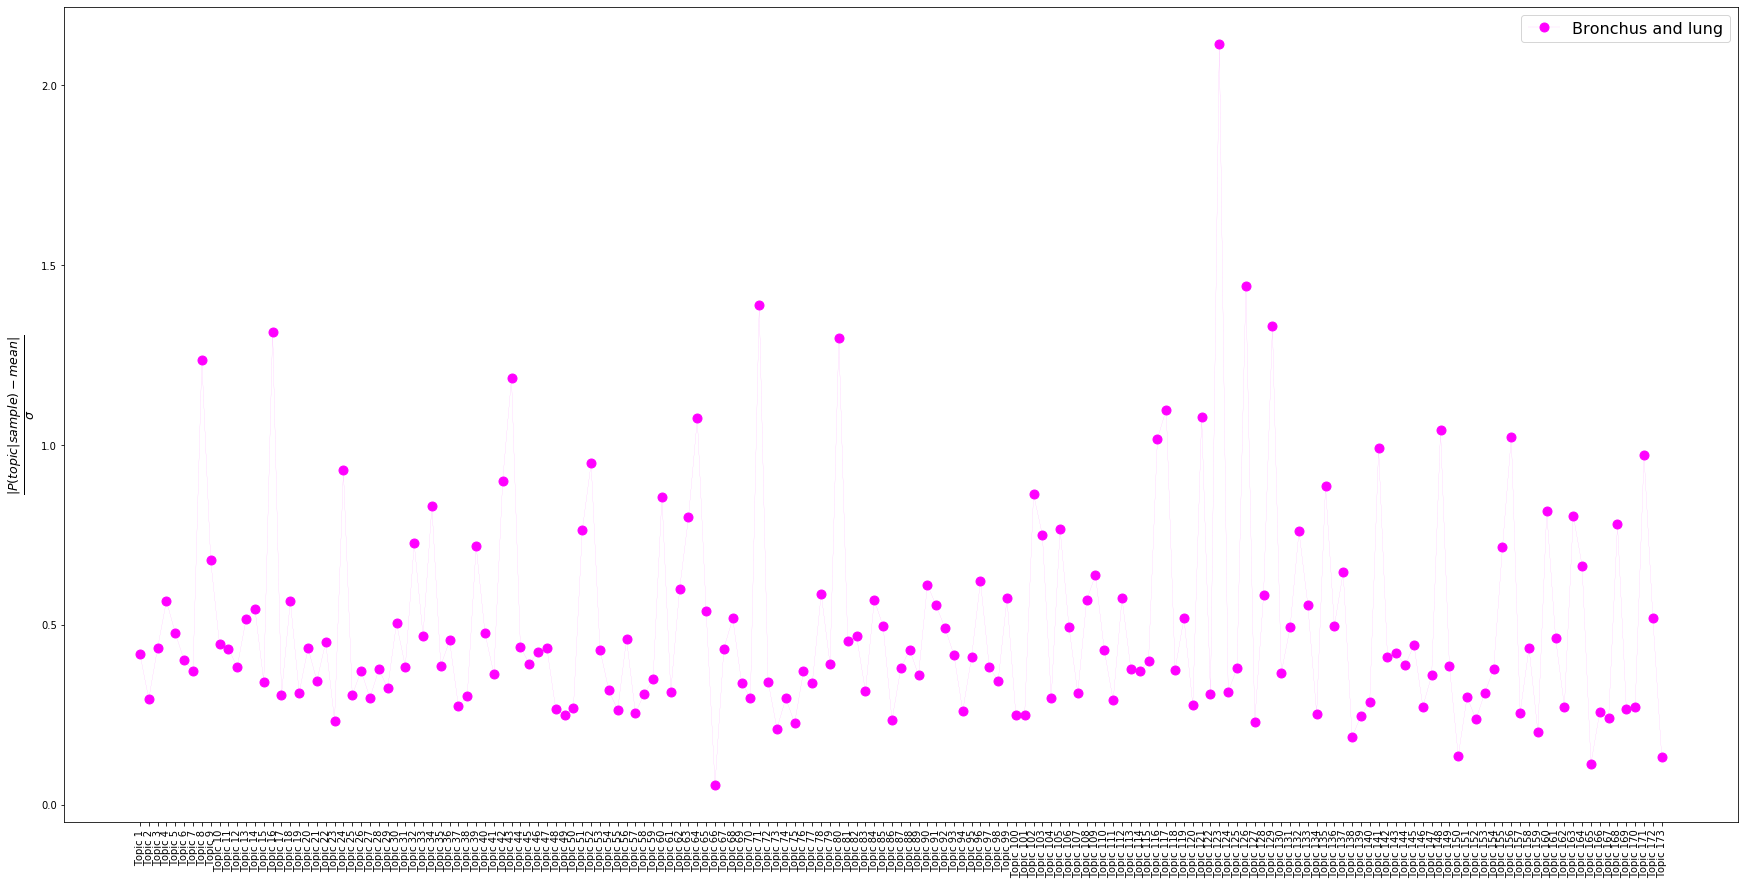

Spinal cord, cranial nerves, and other parts of central nervous system


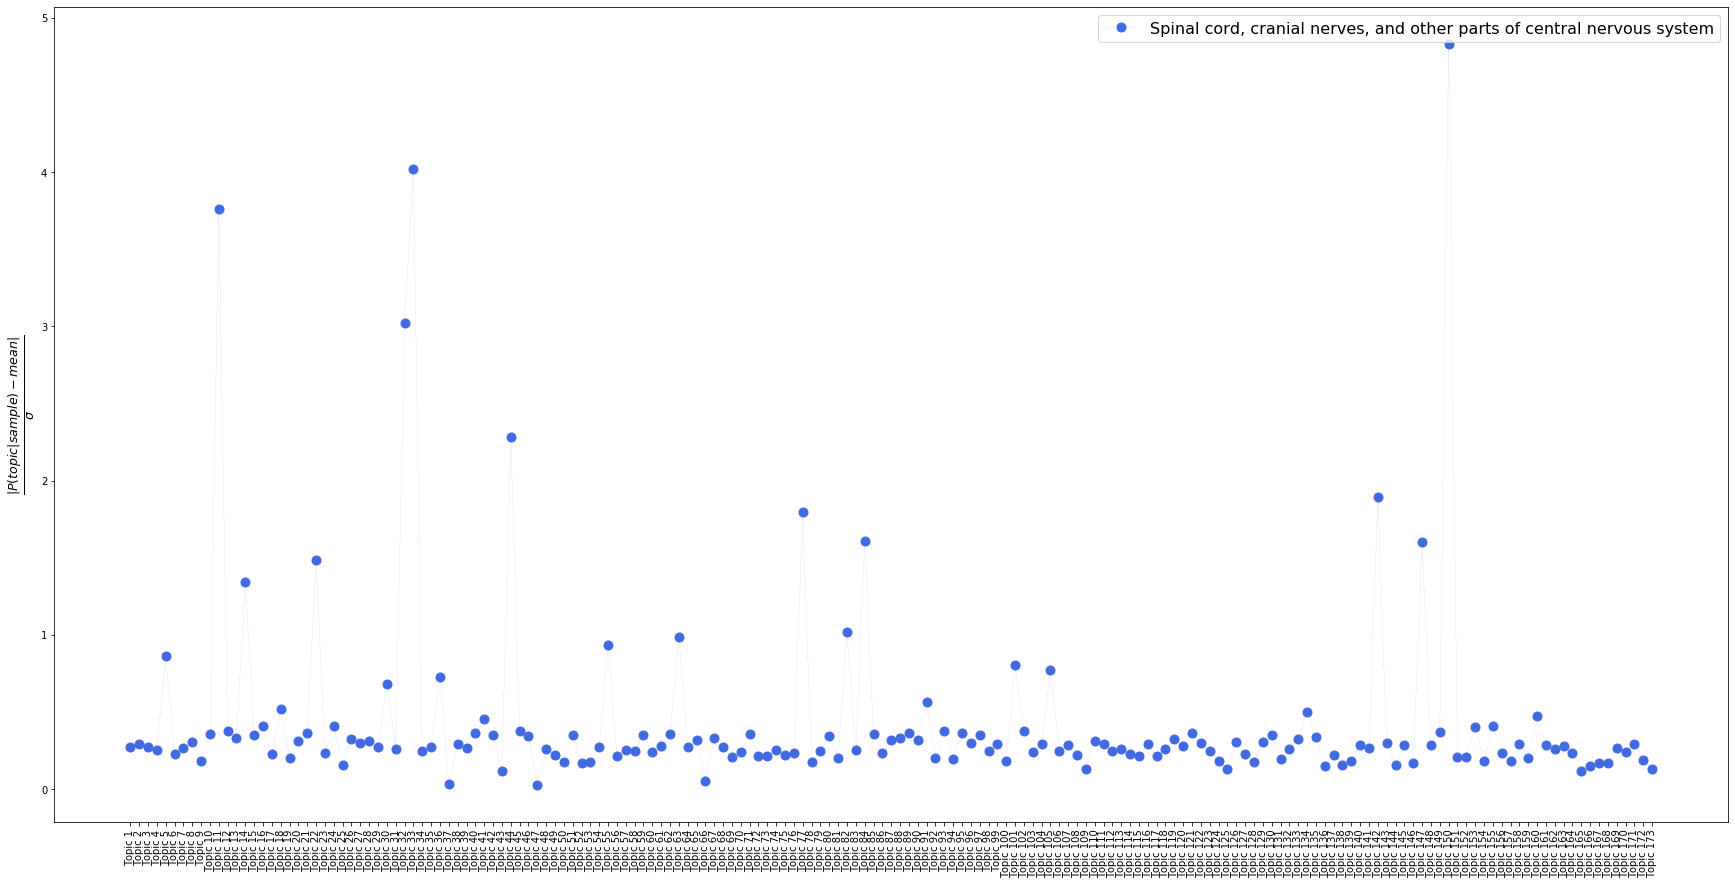

Other and unspecified male genital organs


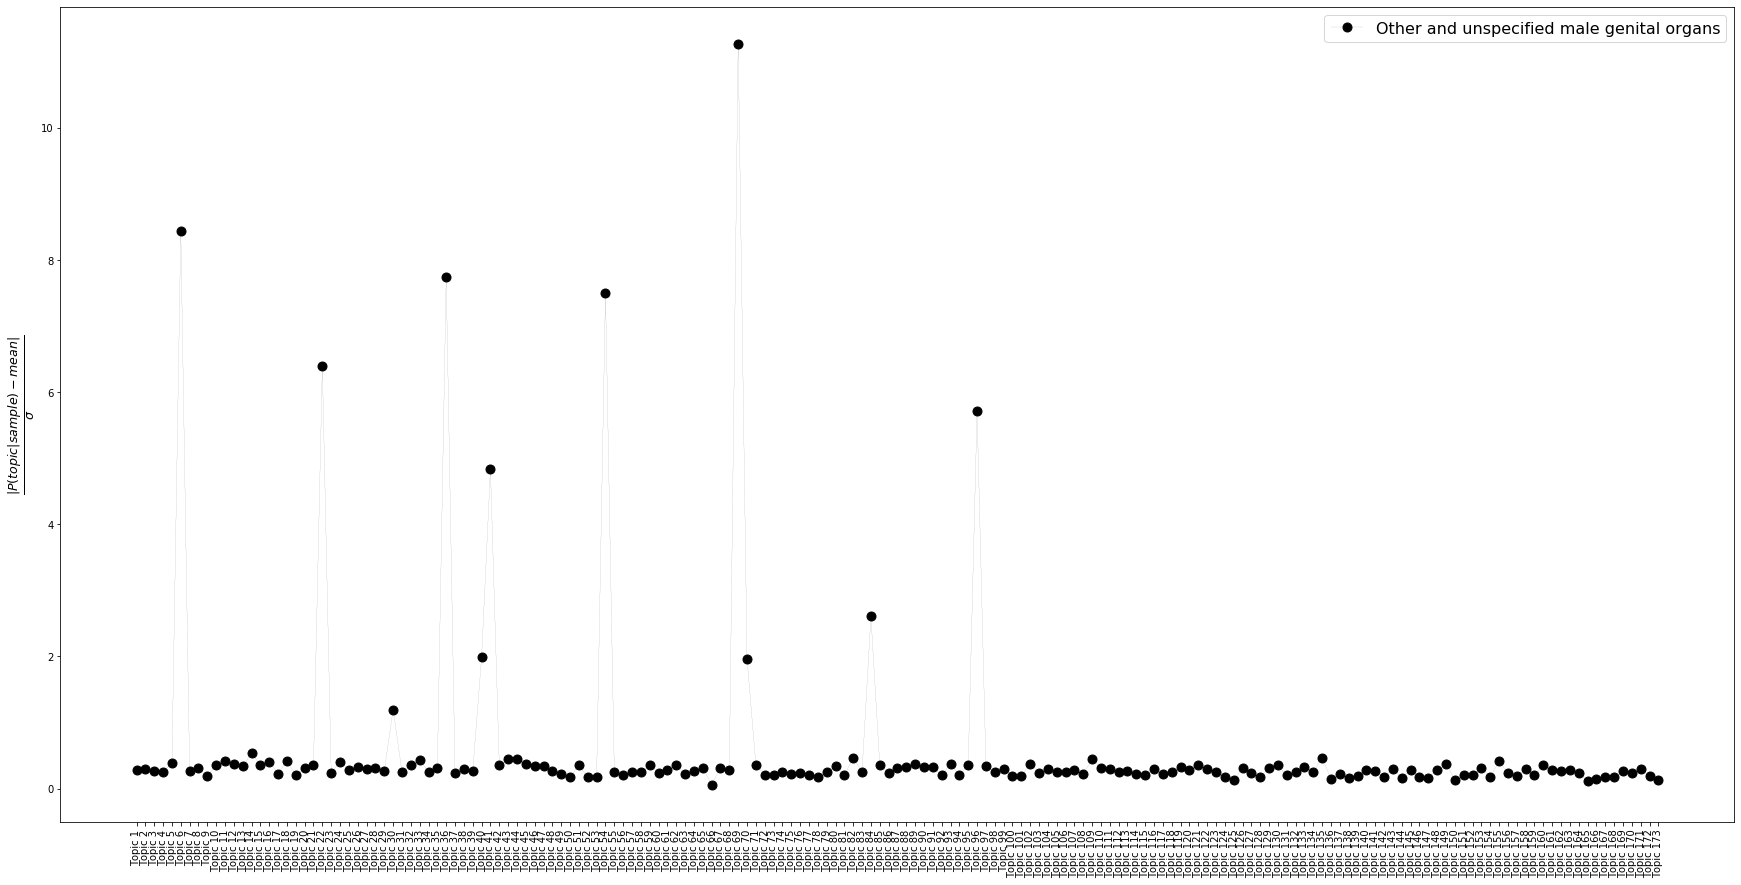

Oropharynx


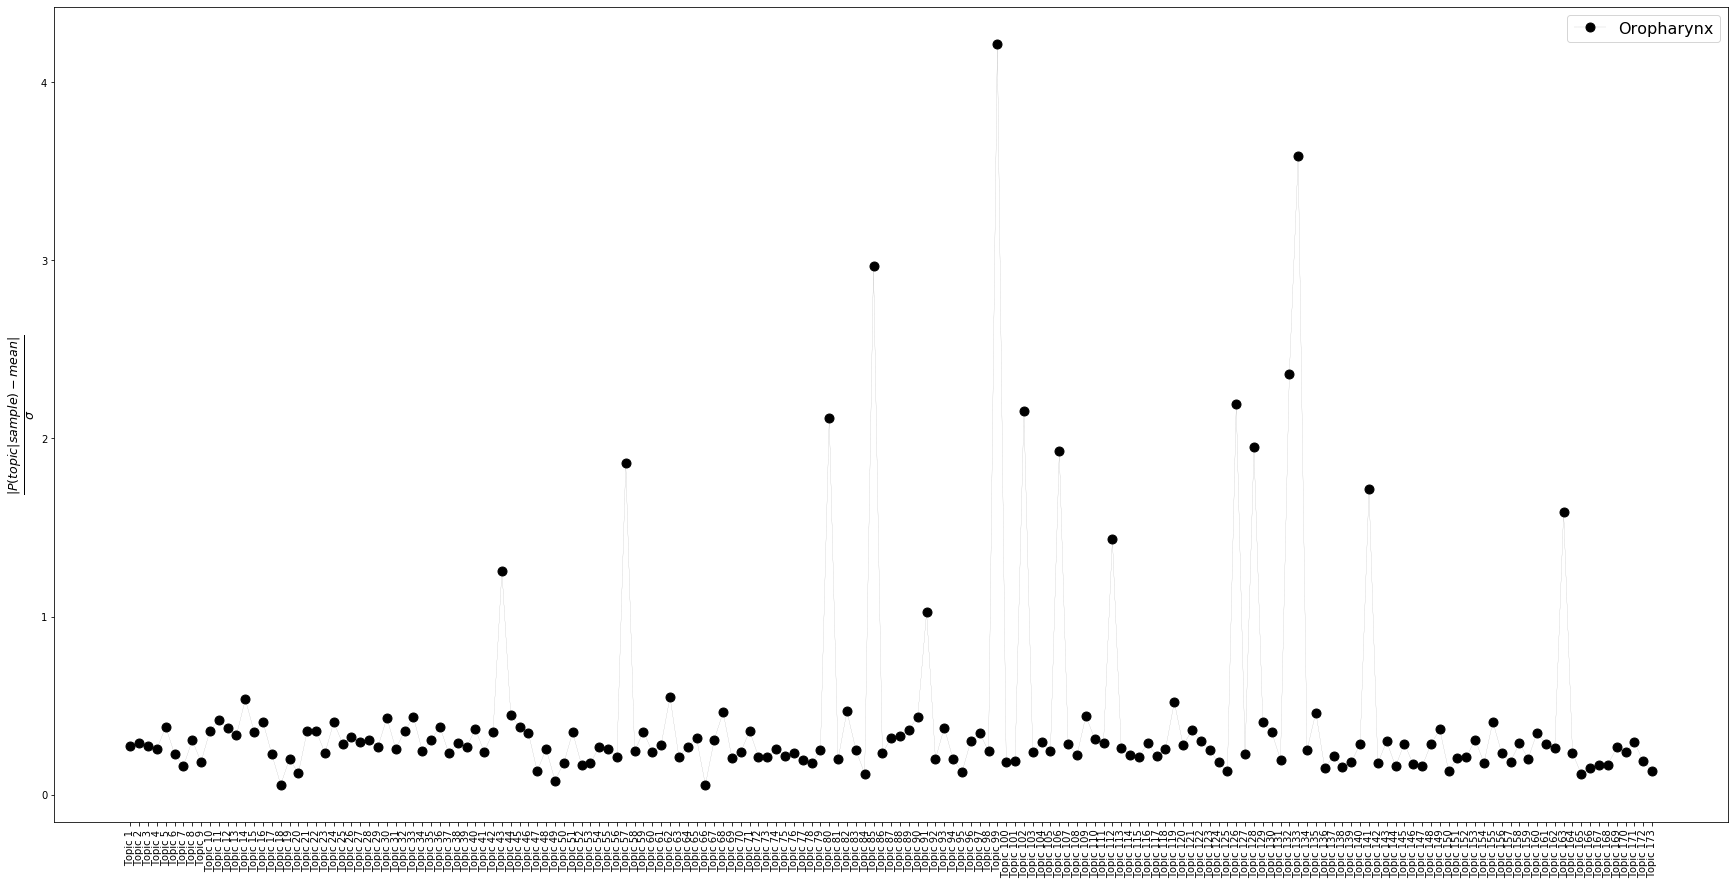

Heart, mediastinum, and pleura


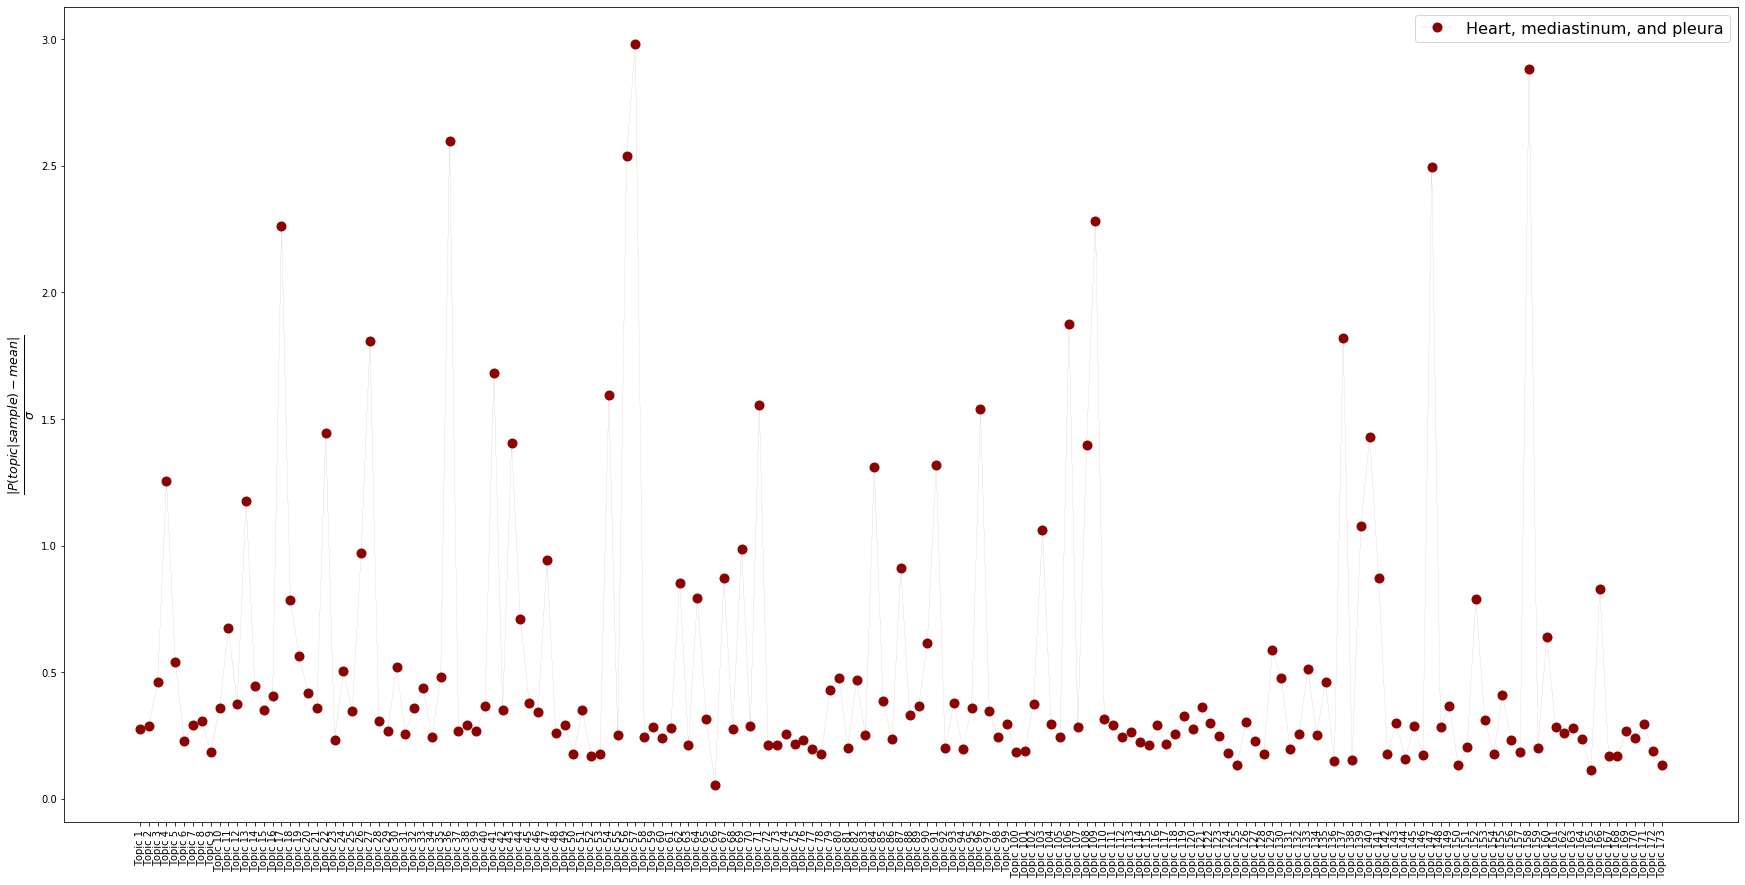

Colon


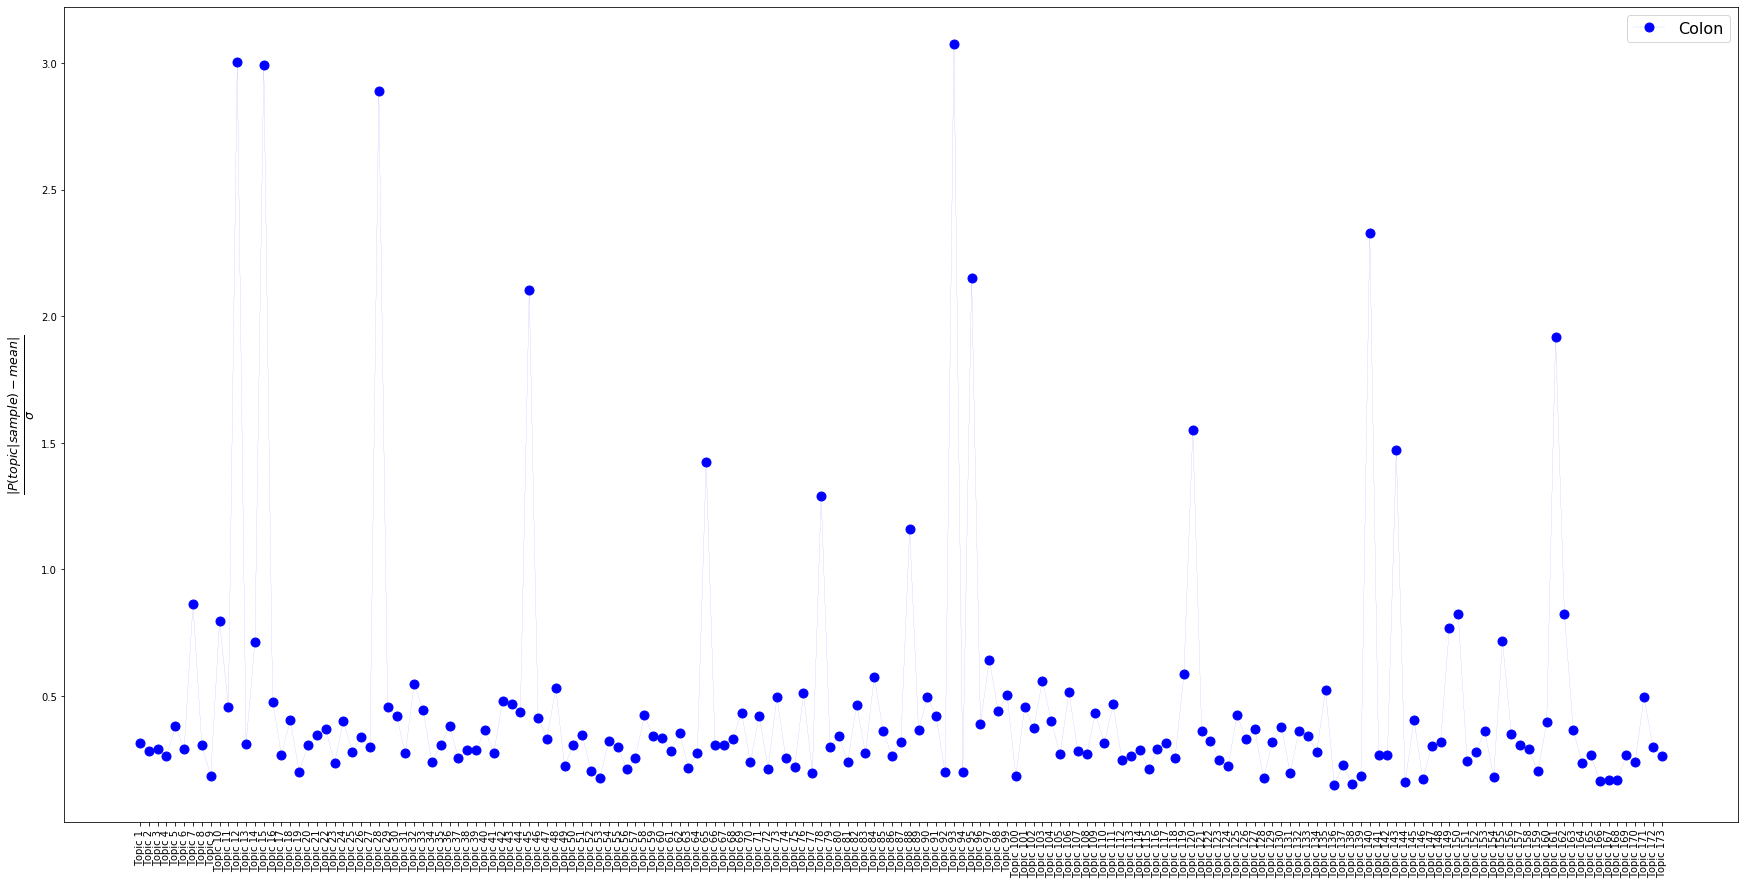

Other and unspecified parts of mouth


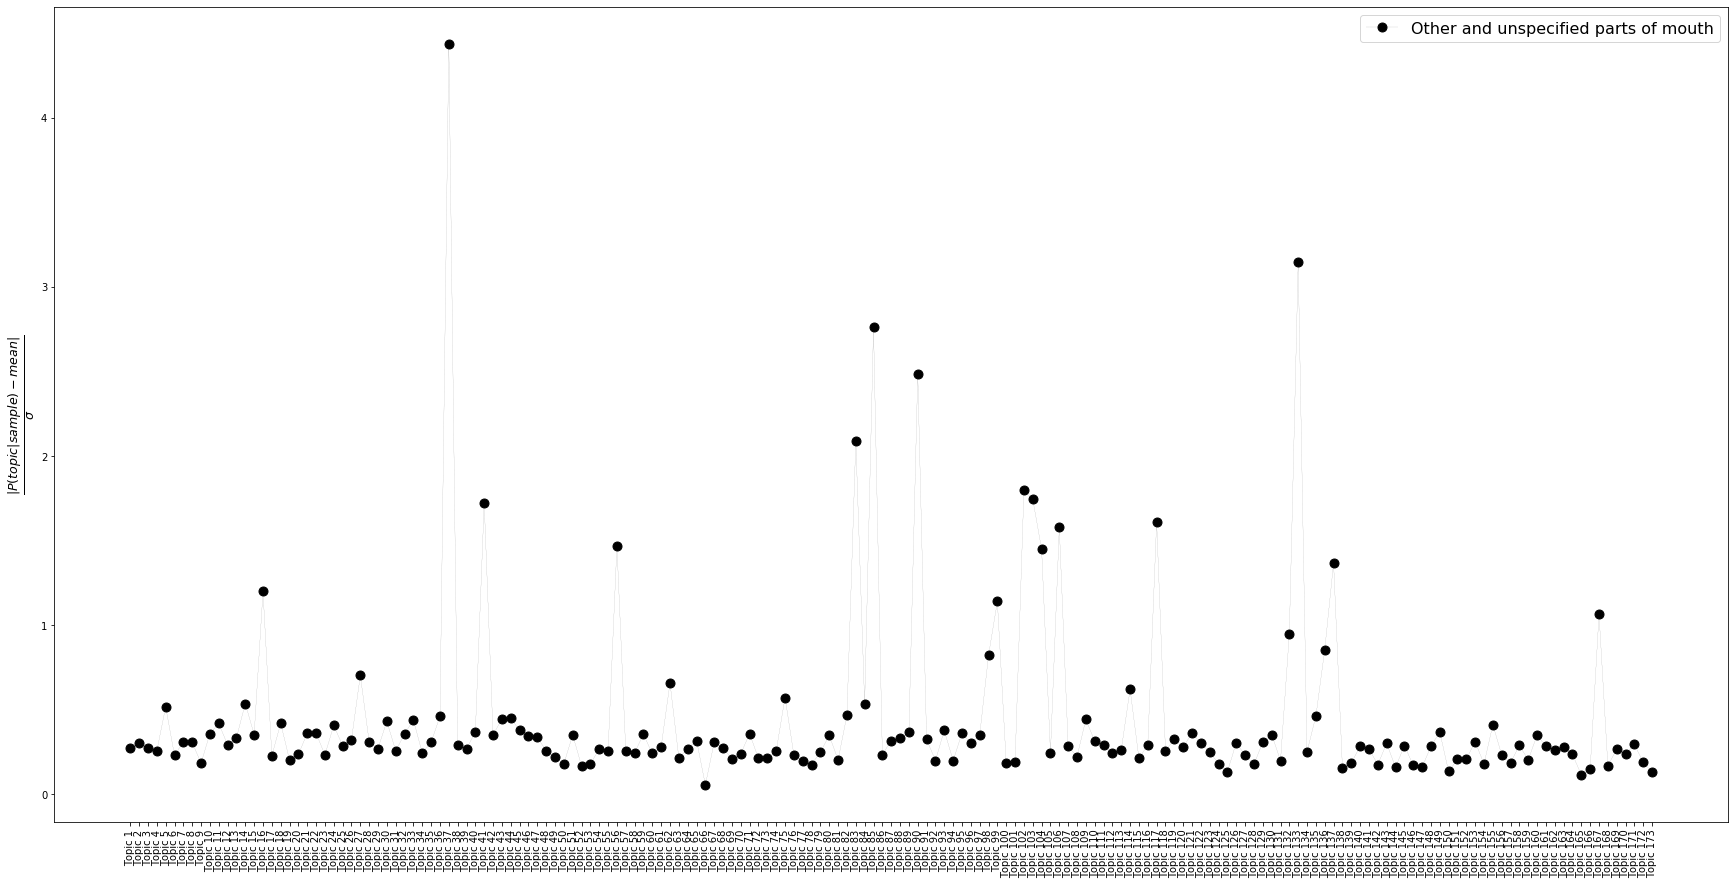

Rectosigmoid junction


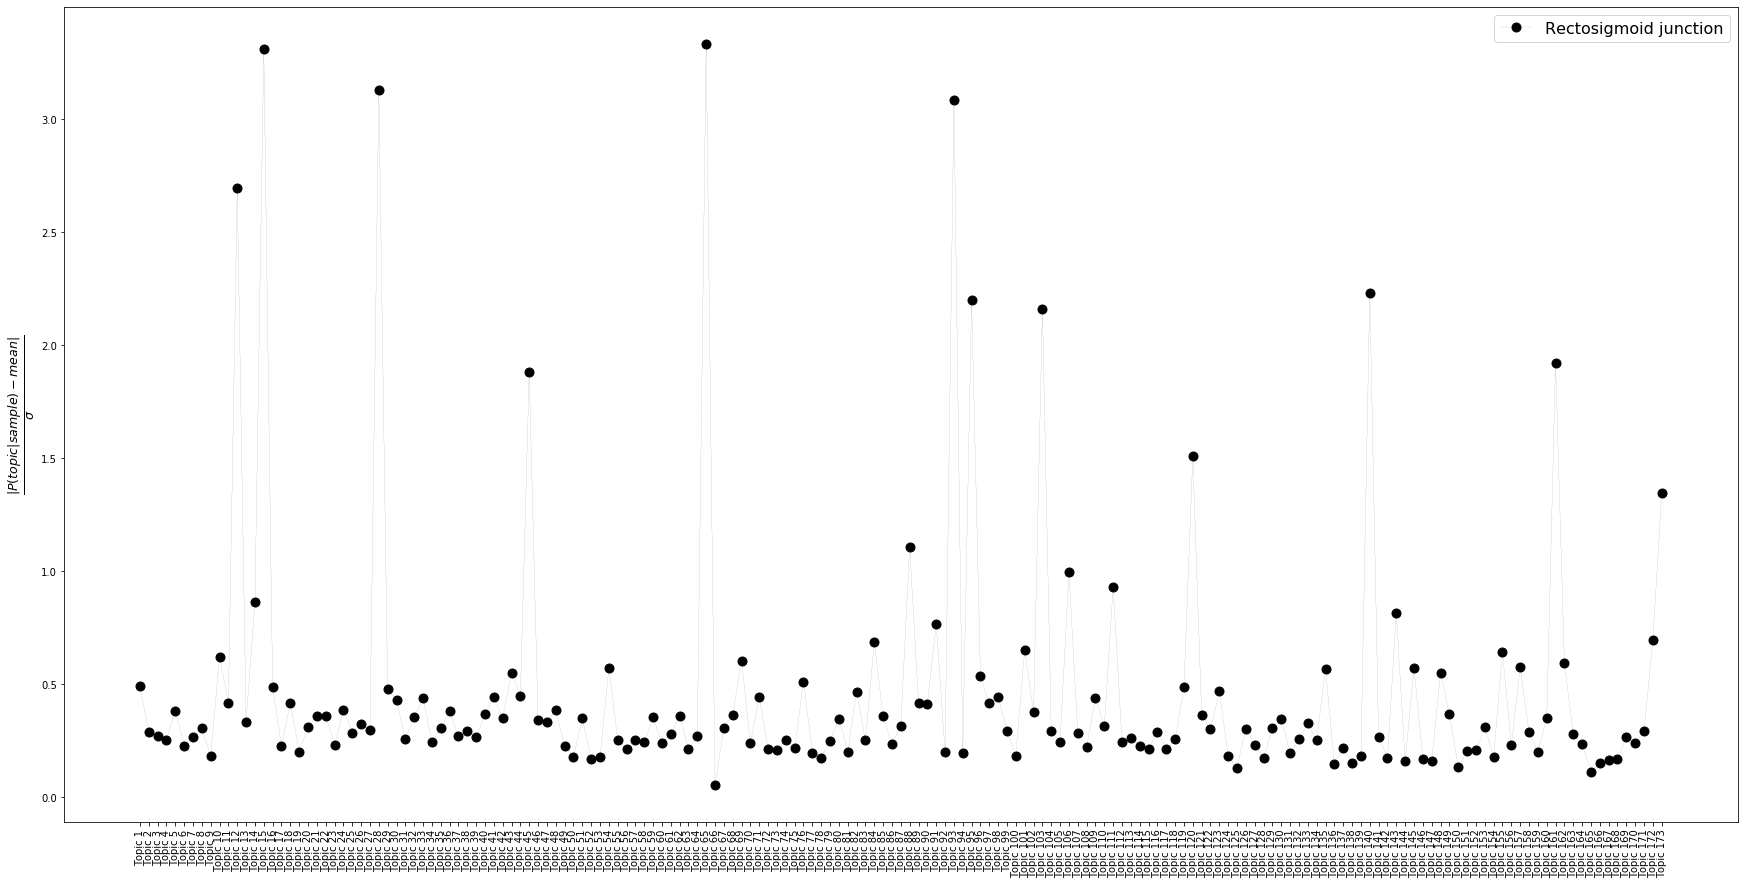

Tonsil


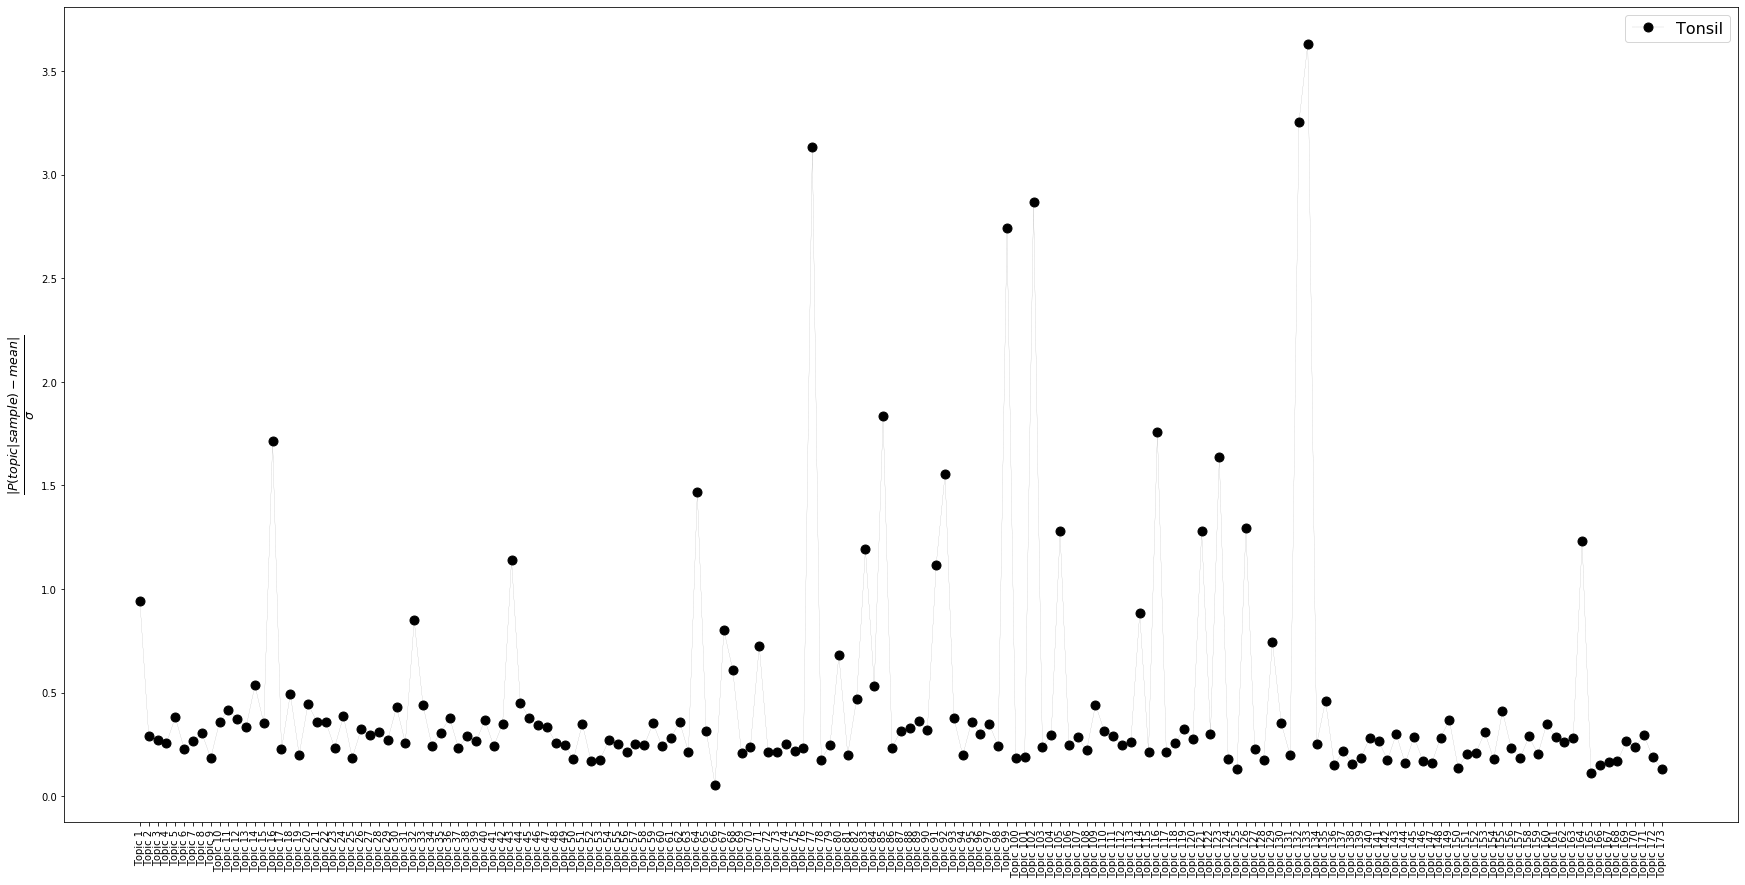

Gum


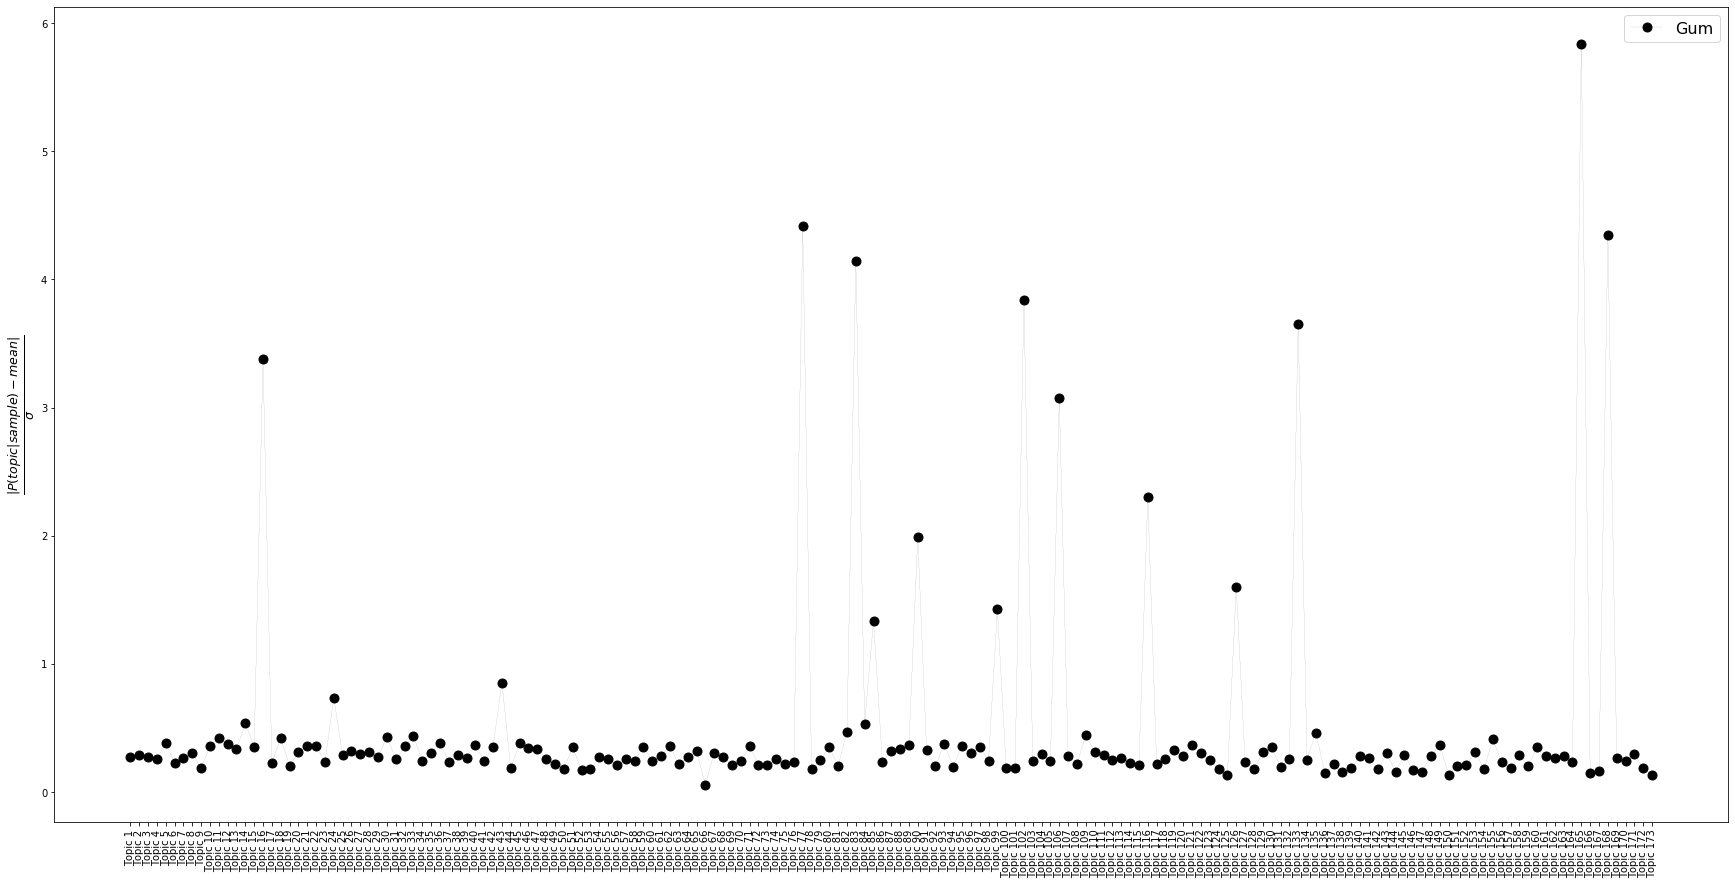

Uterus, NOS


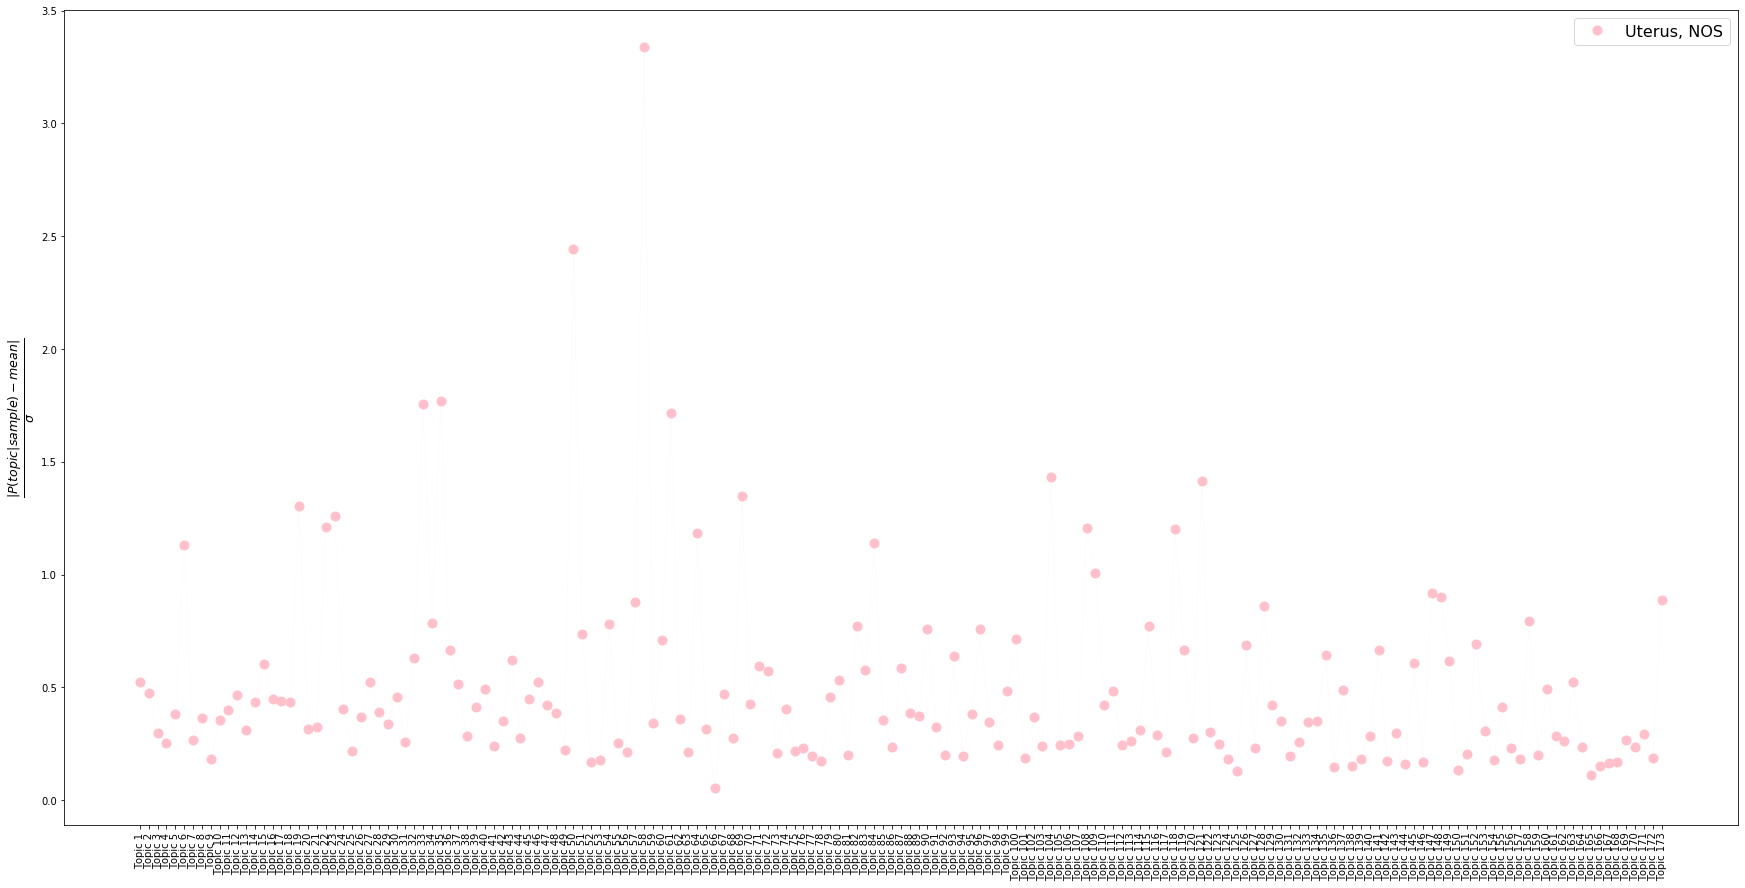

Blood


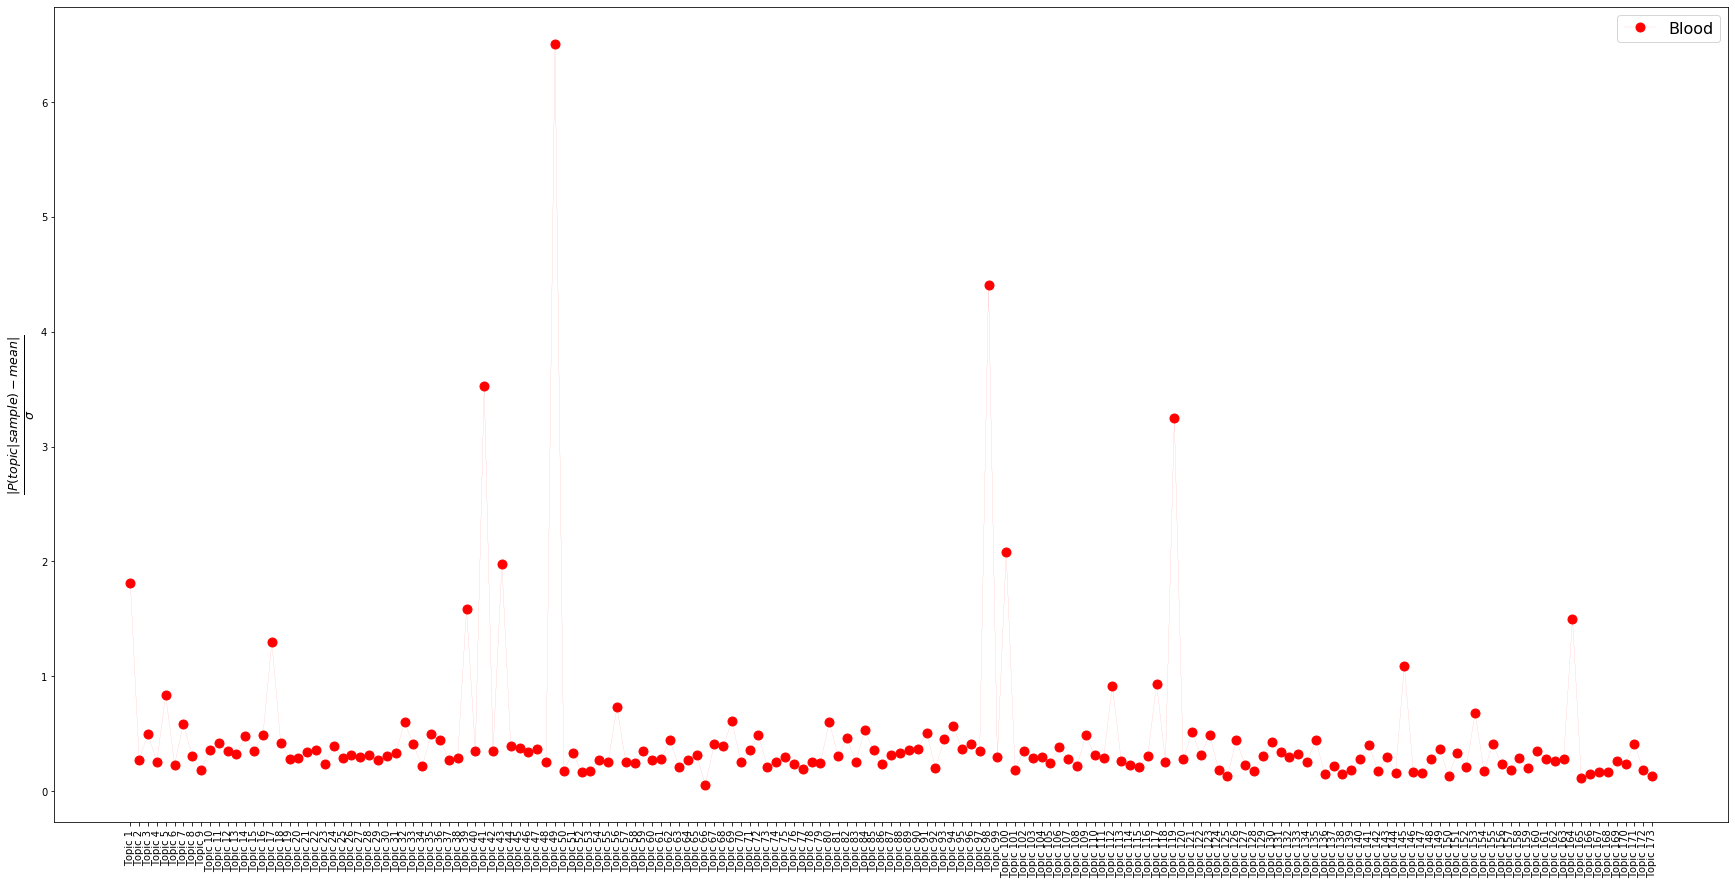

Kidney


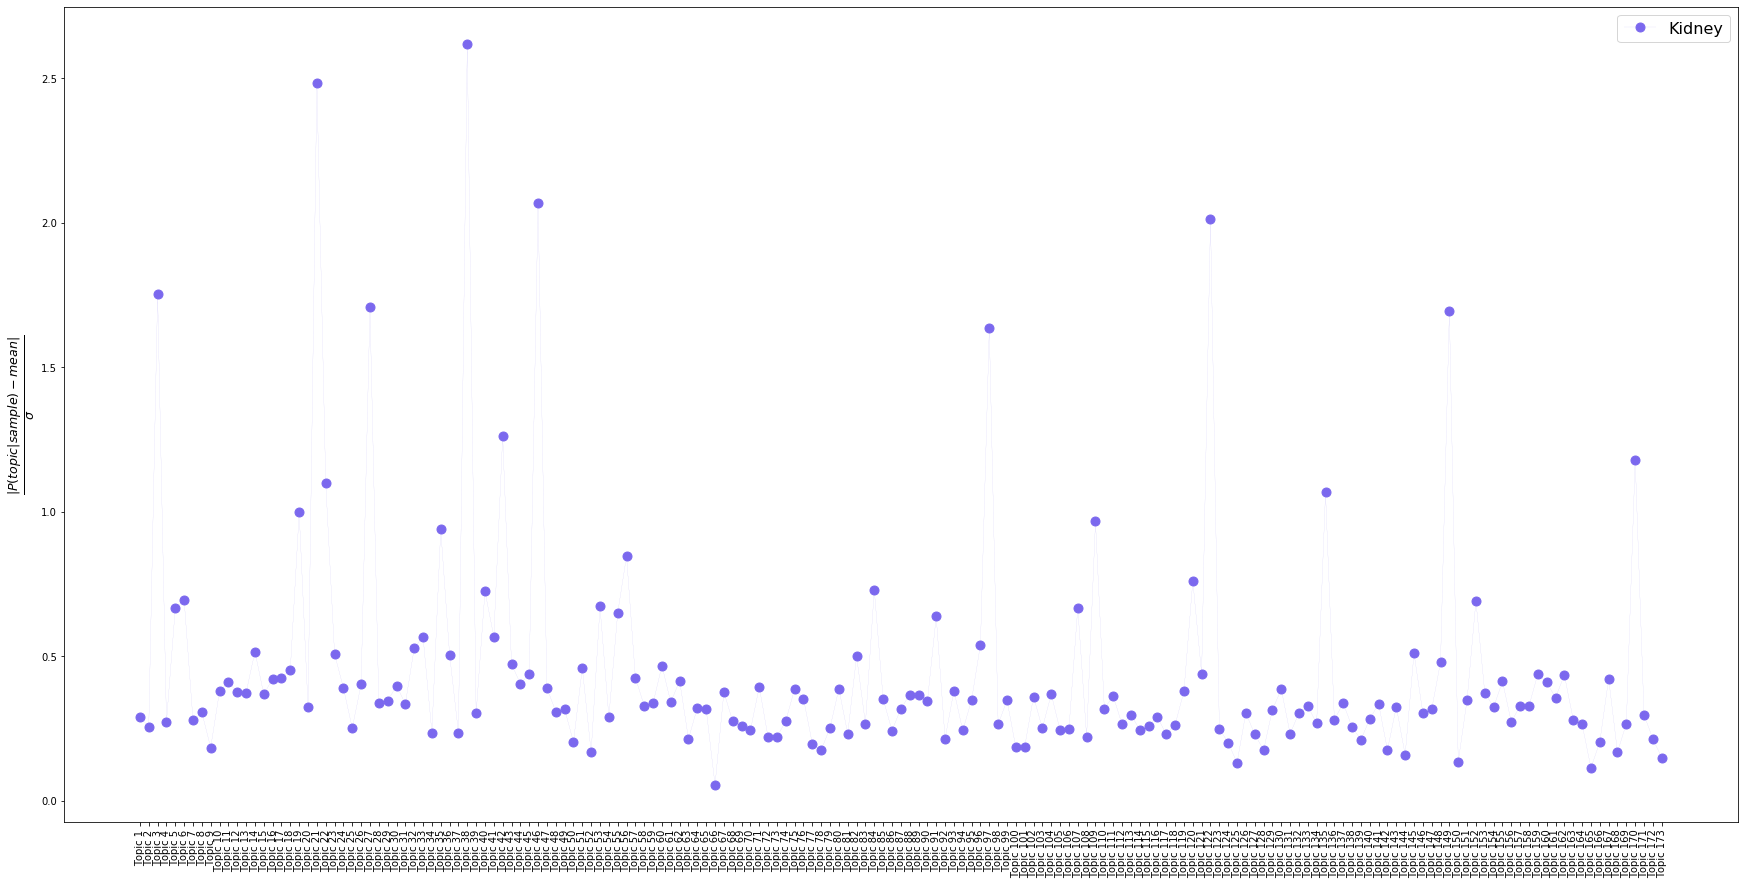

Rectum


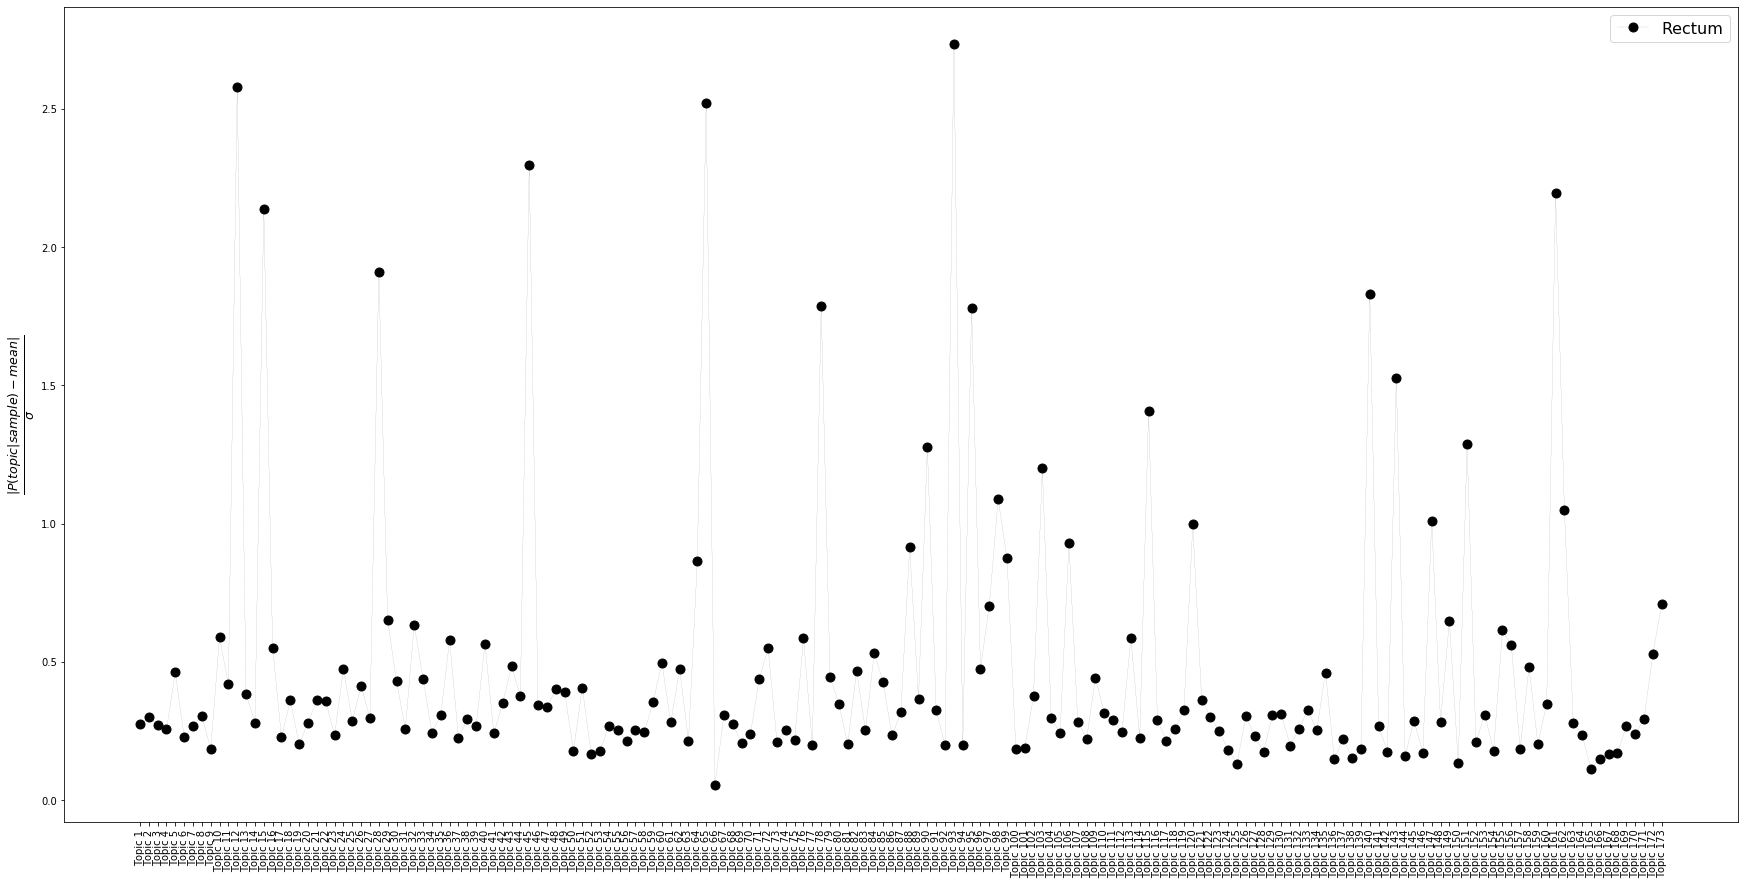

Corpus uteri


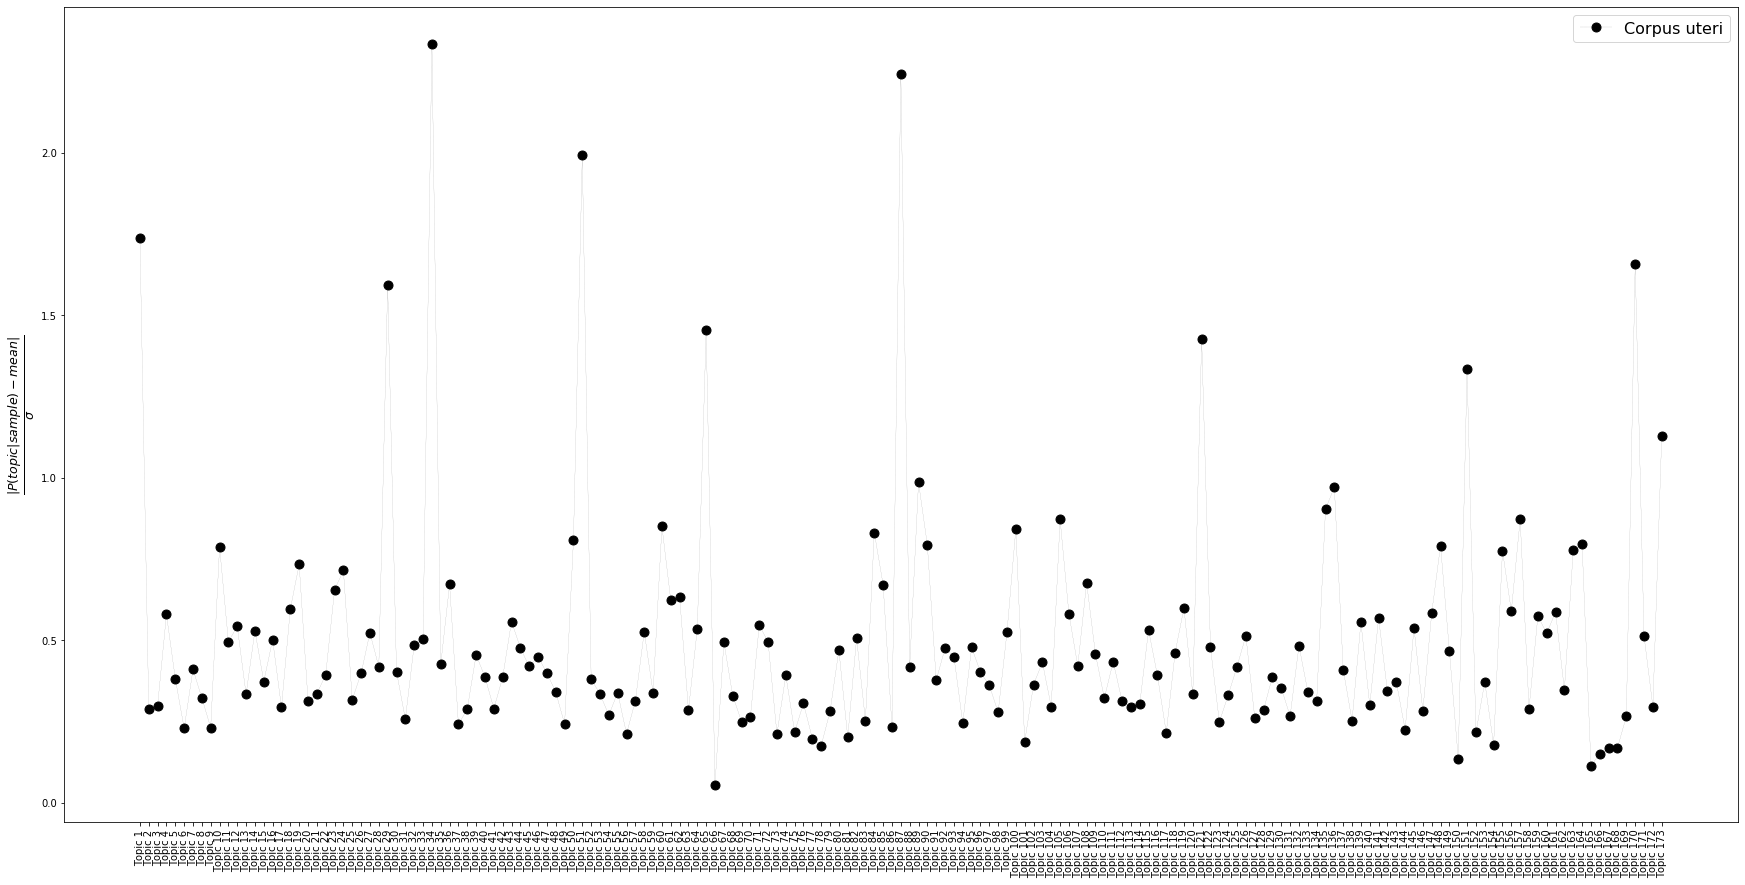

Hypopharynx


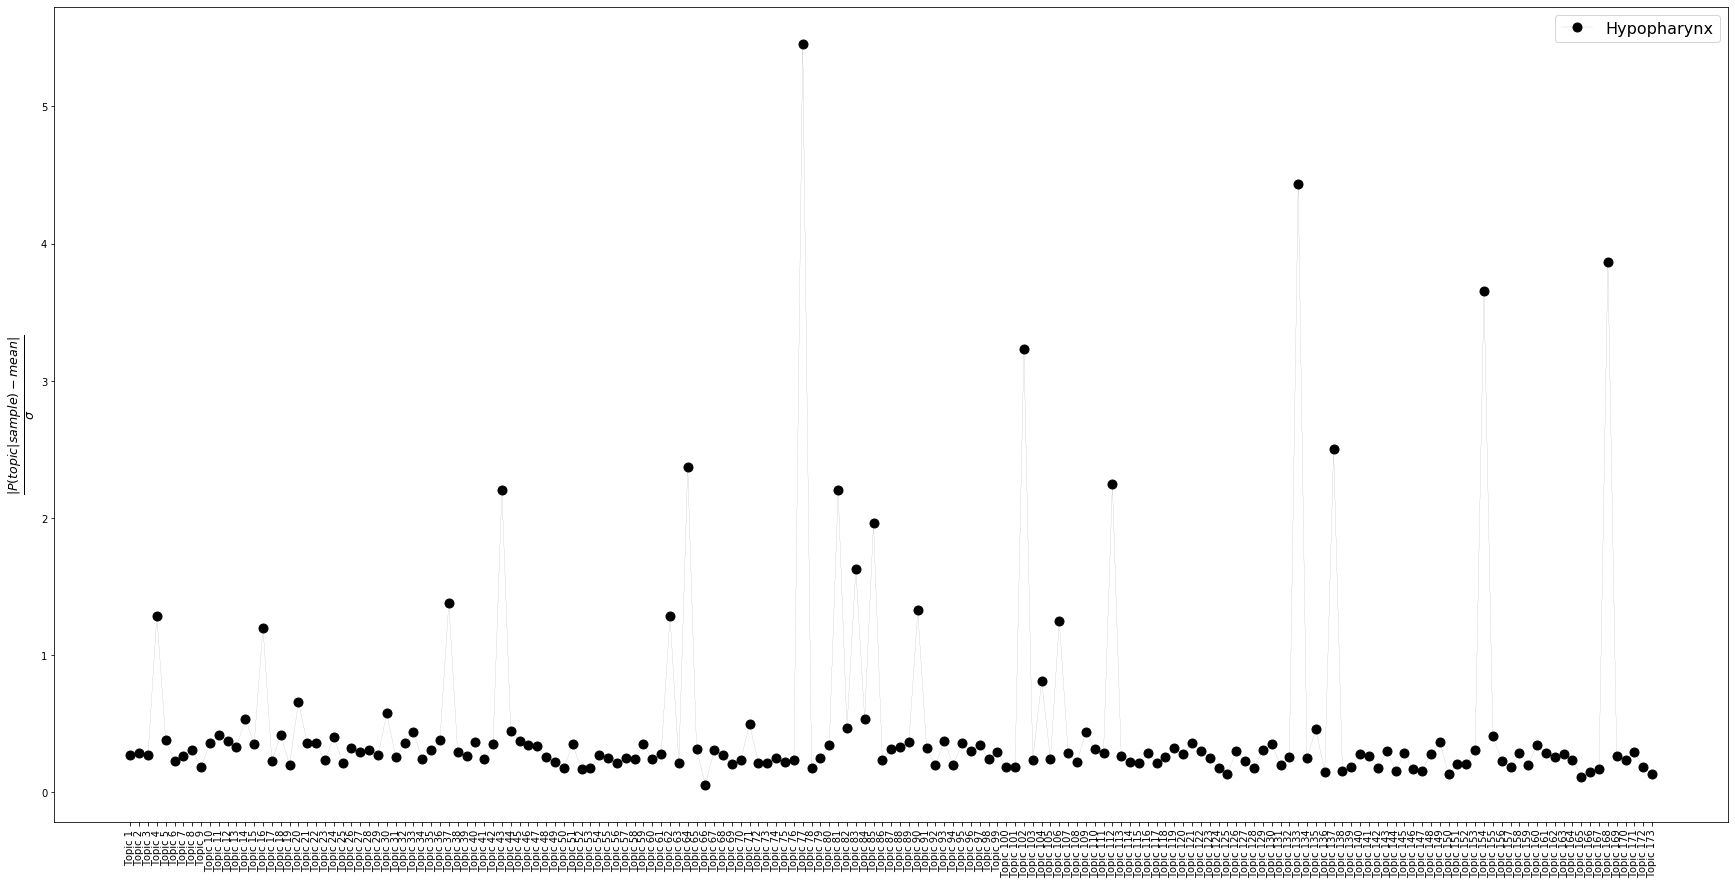

Esophagus


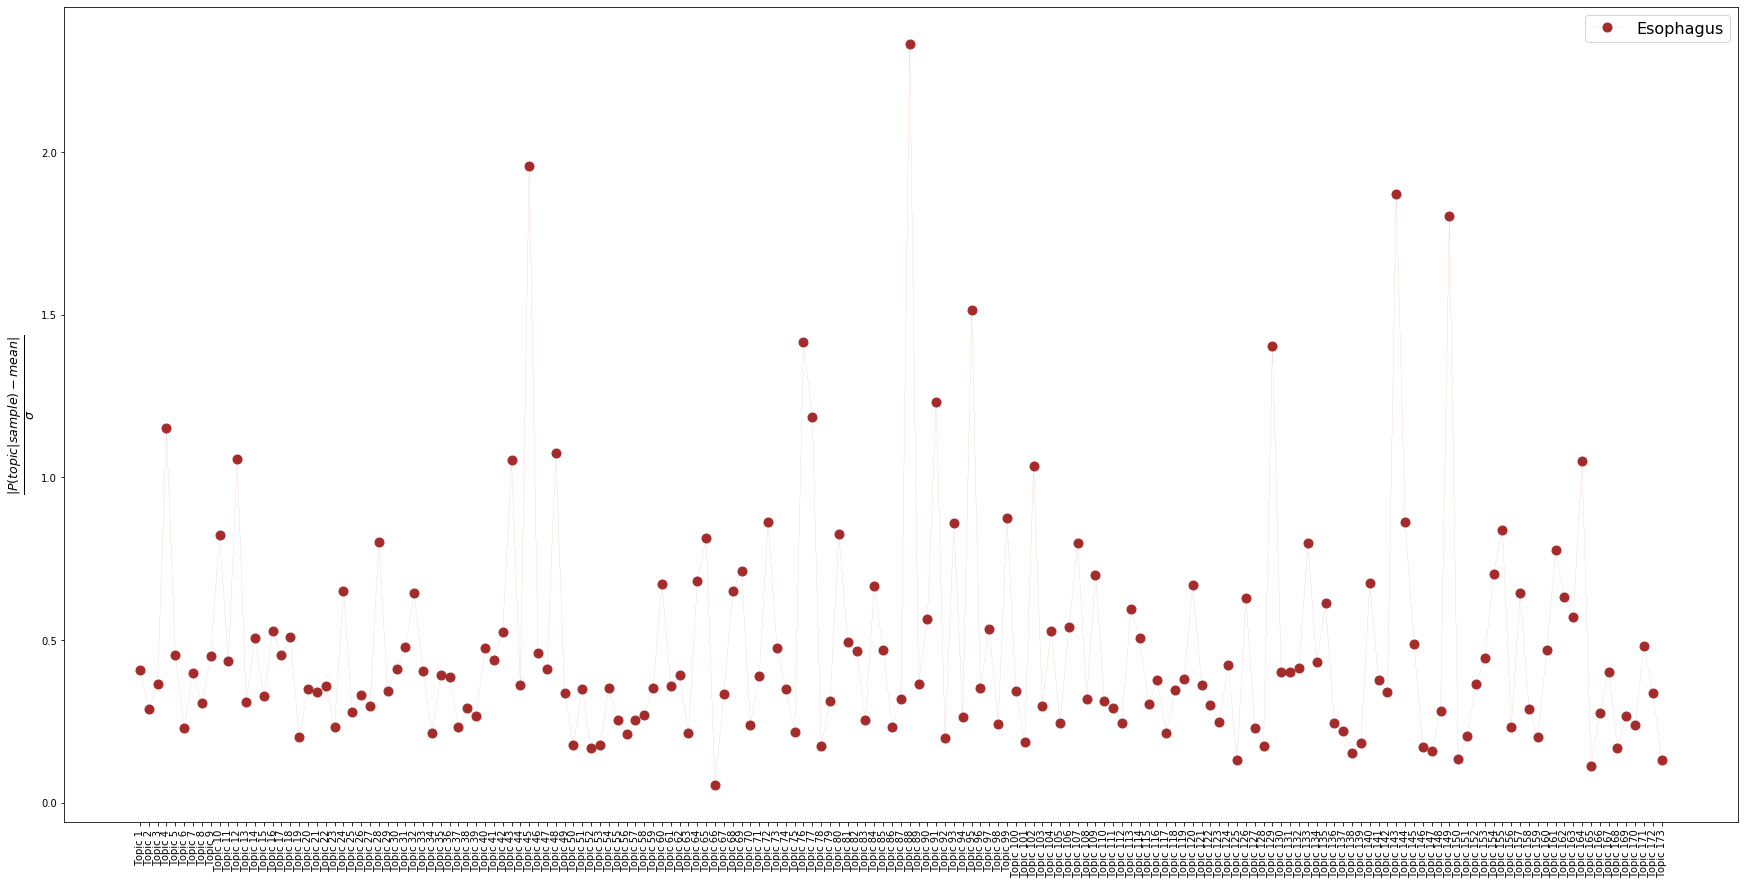

Bladder


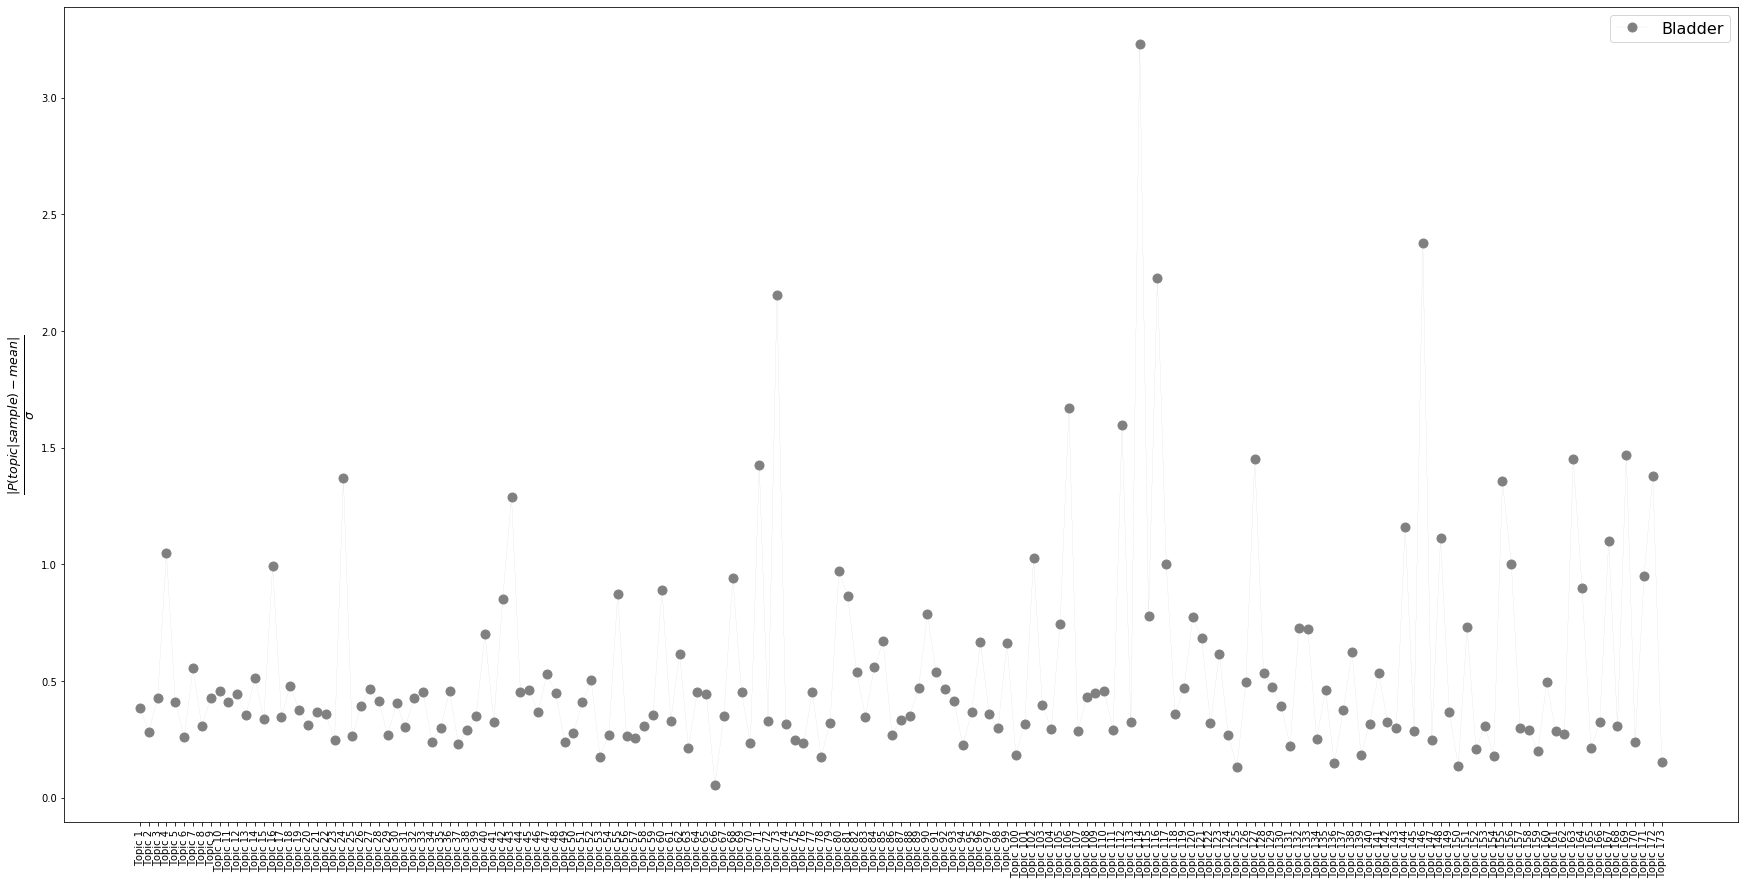

Adrenal gland


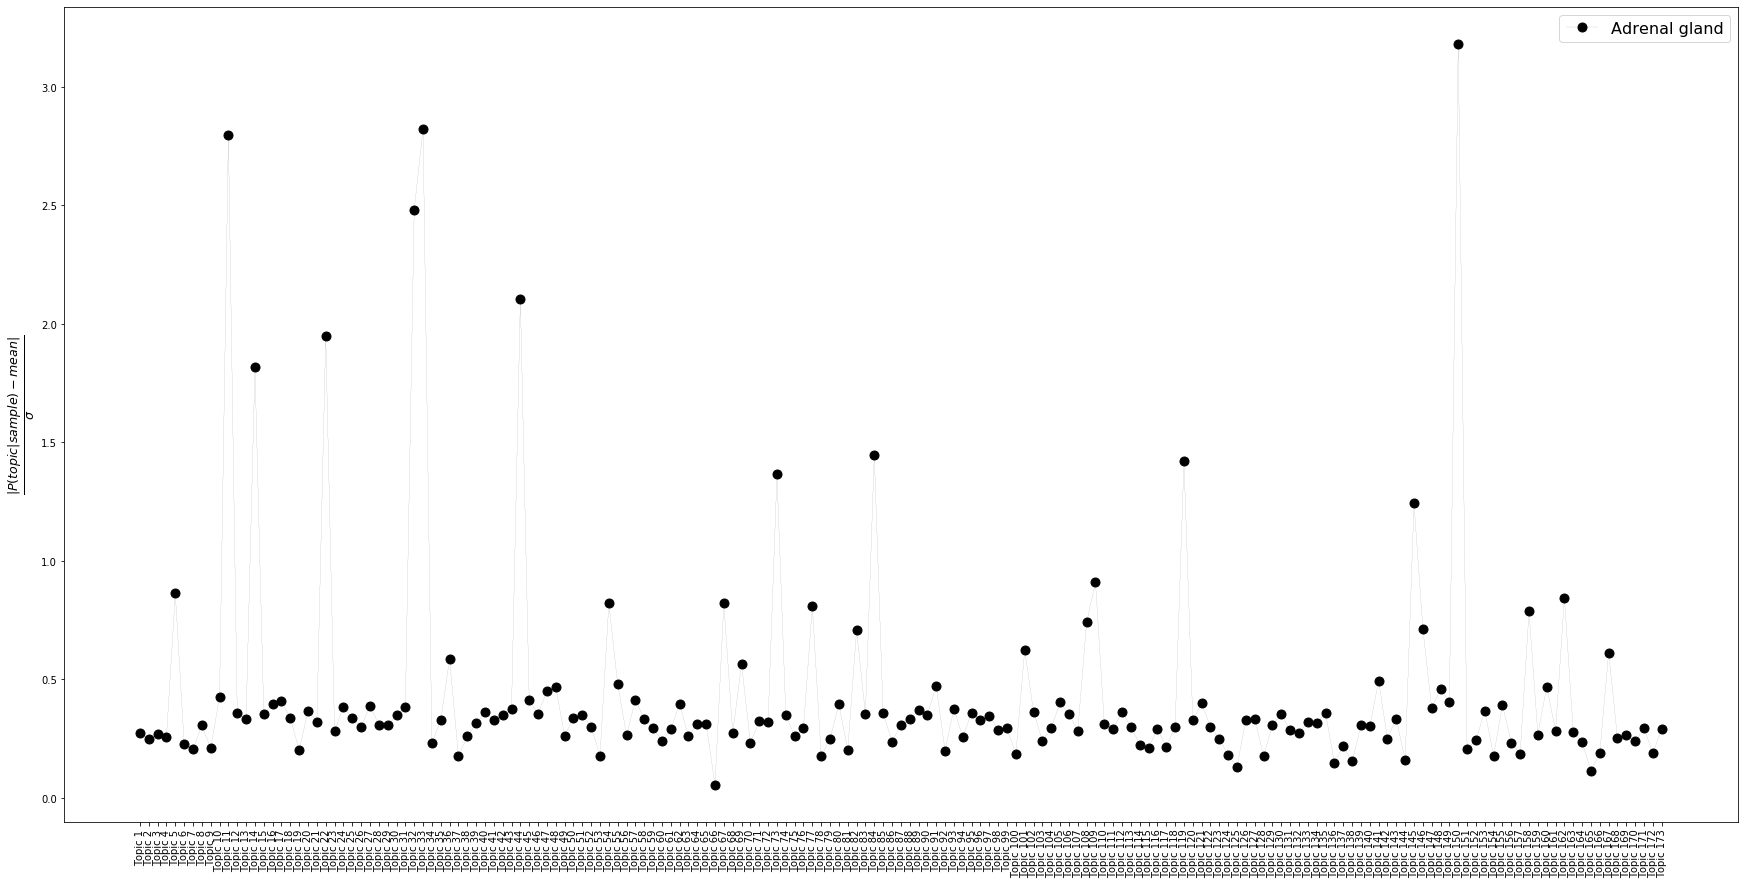

Thymus


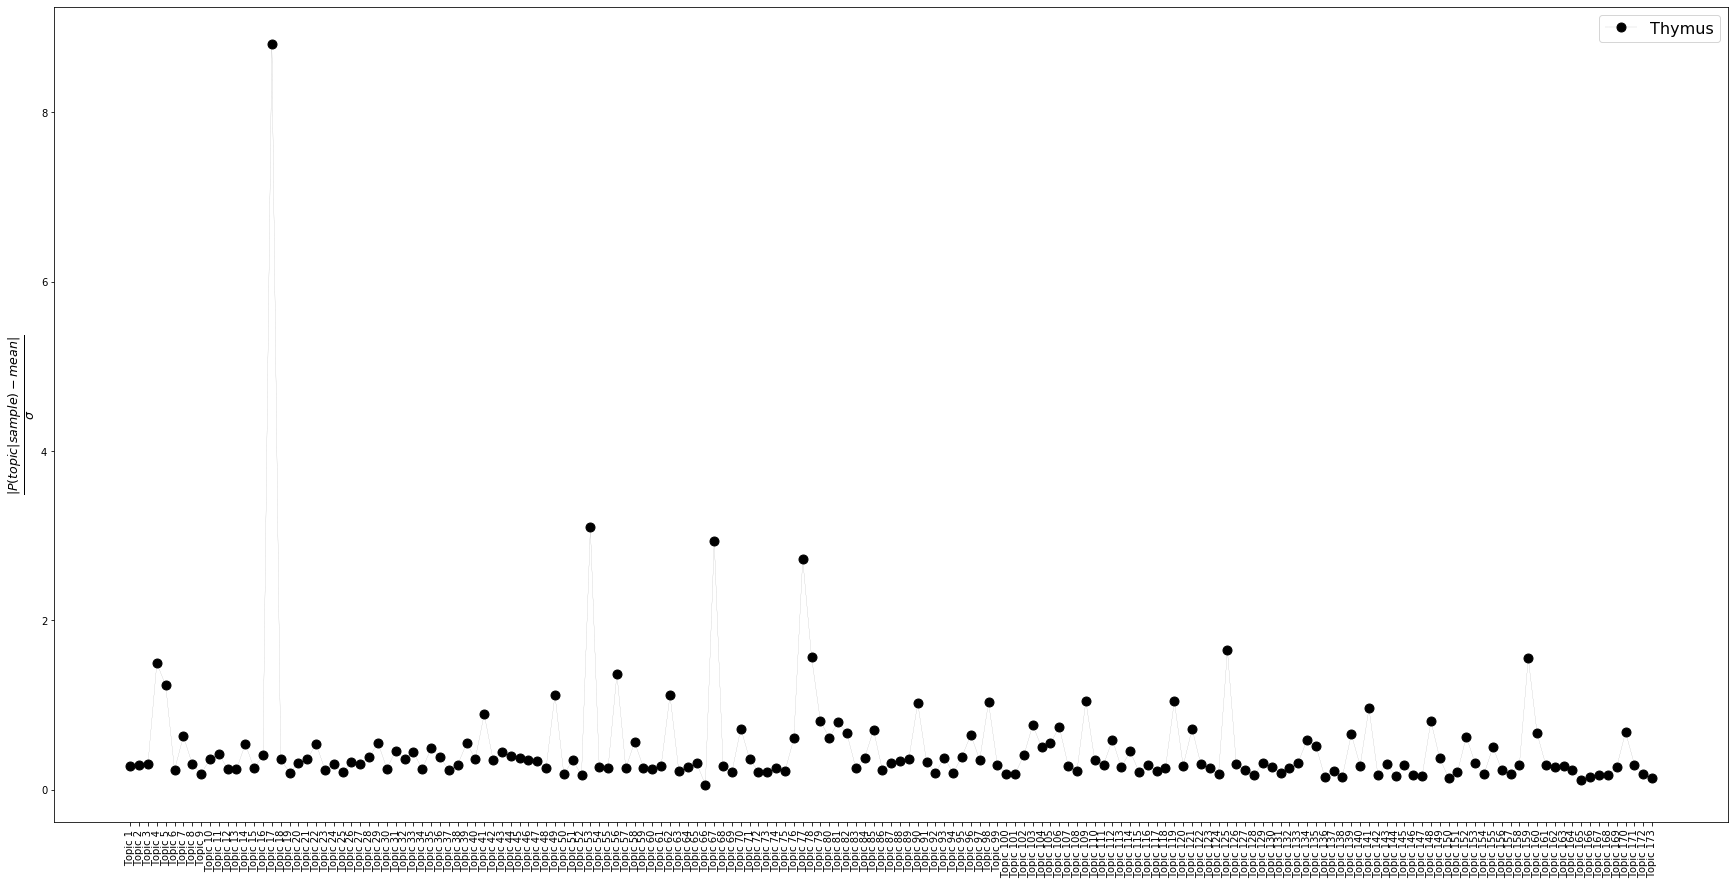

Other and ill-defined sites in lip, oral cavity and pharynx


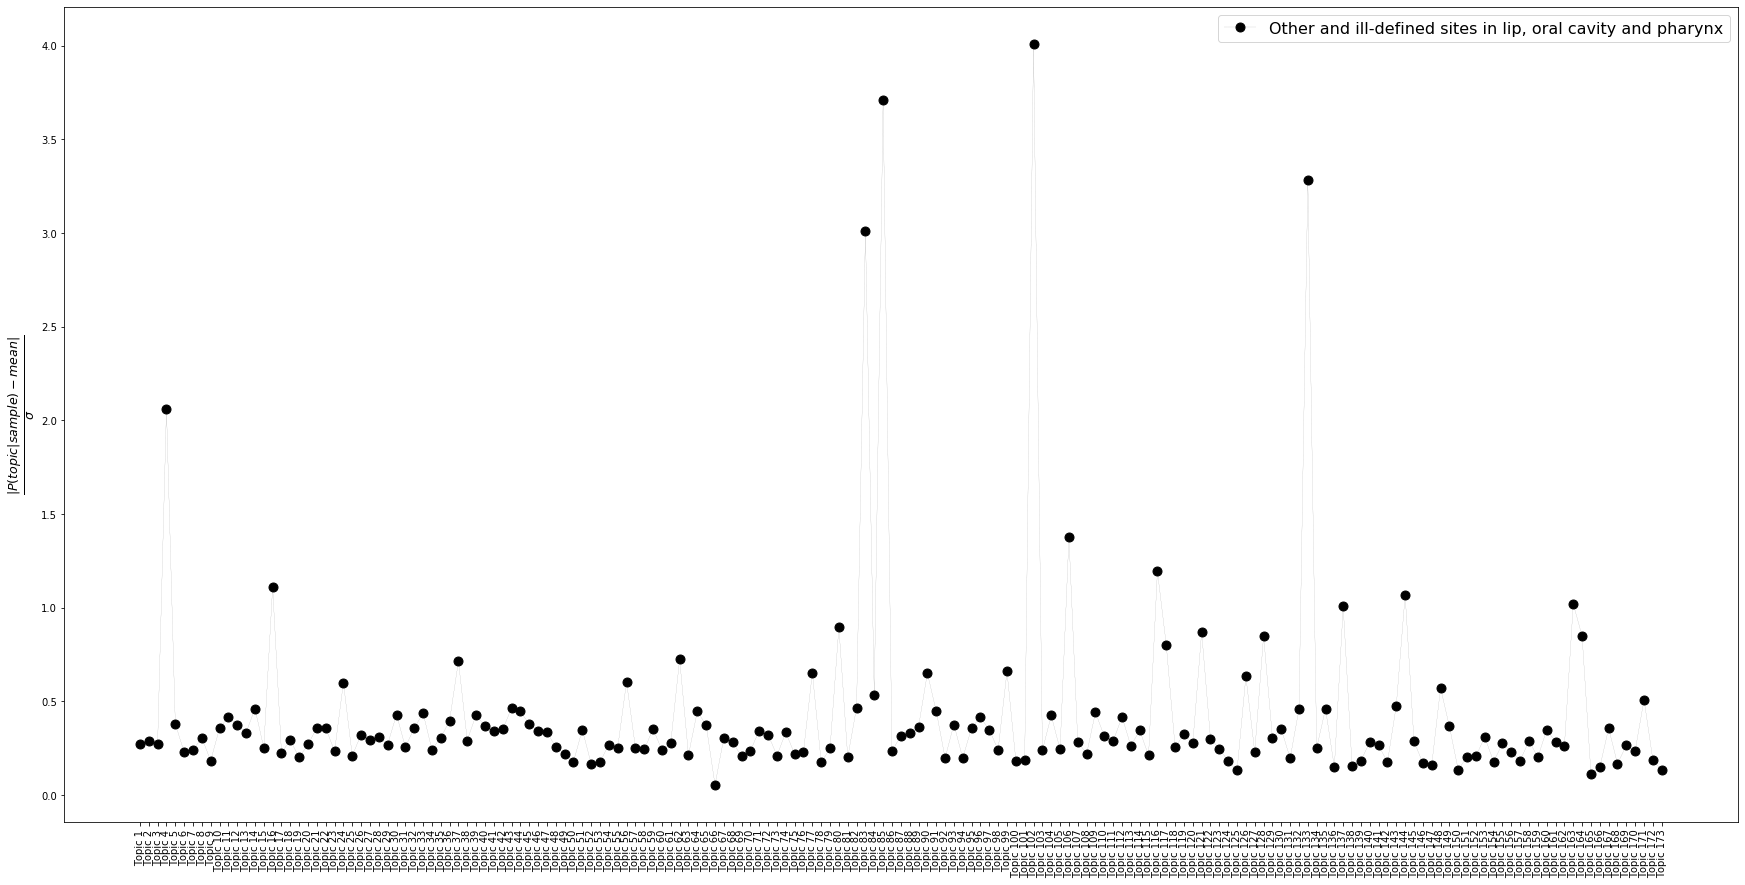

Floor of mouth


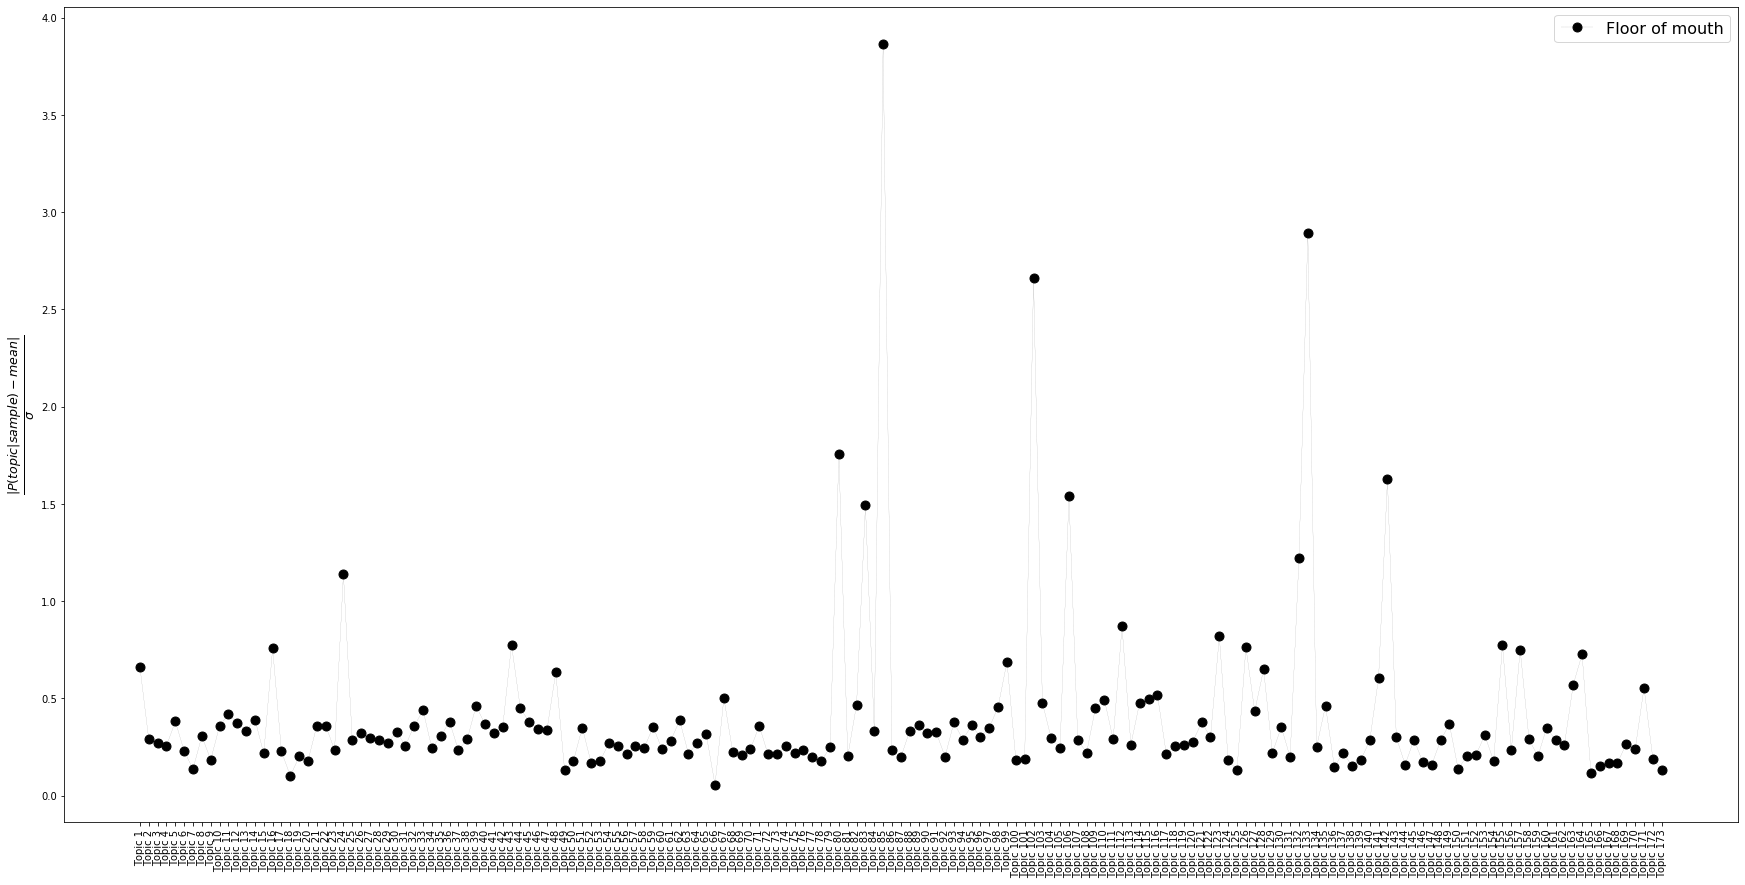

Other and unspecified parts of tongue


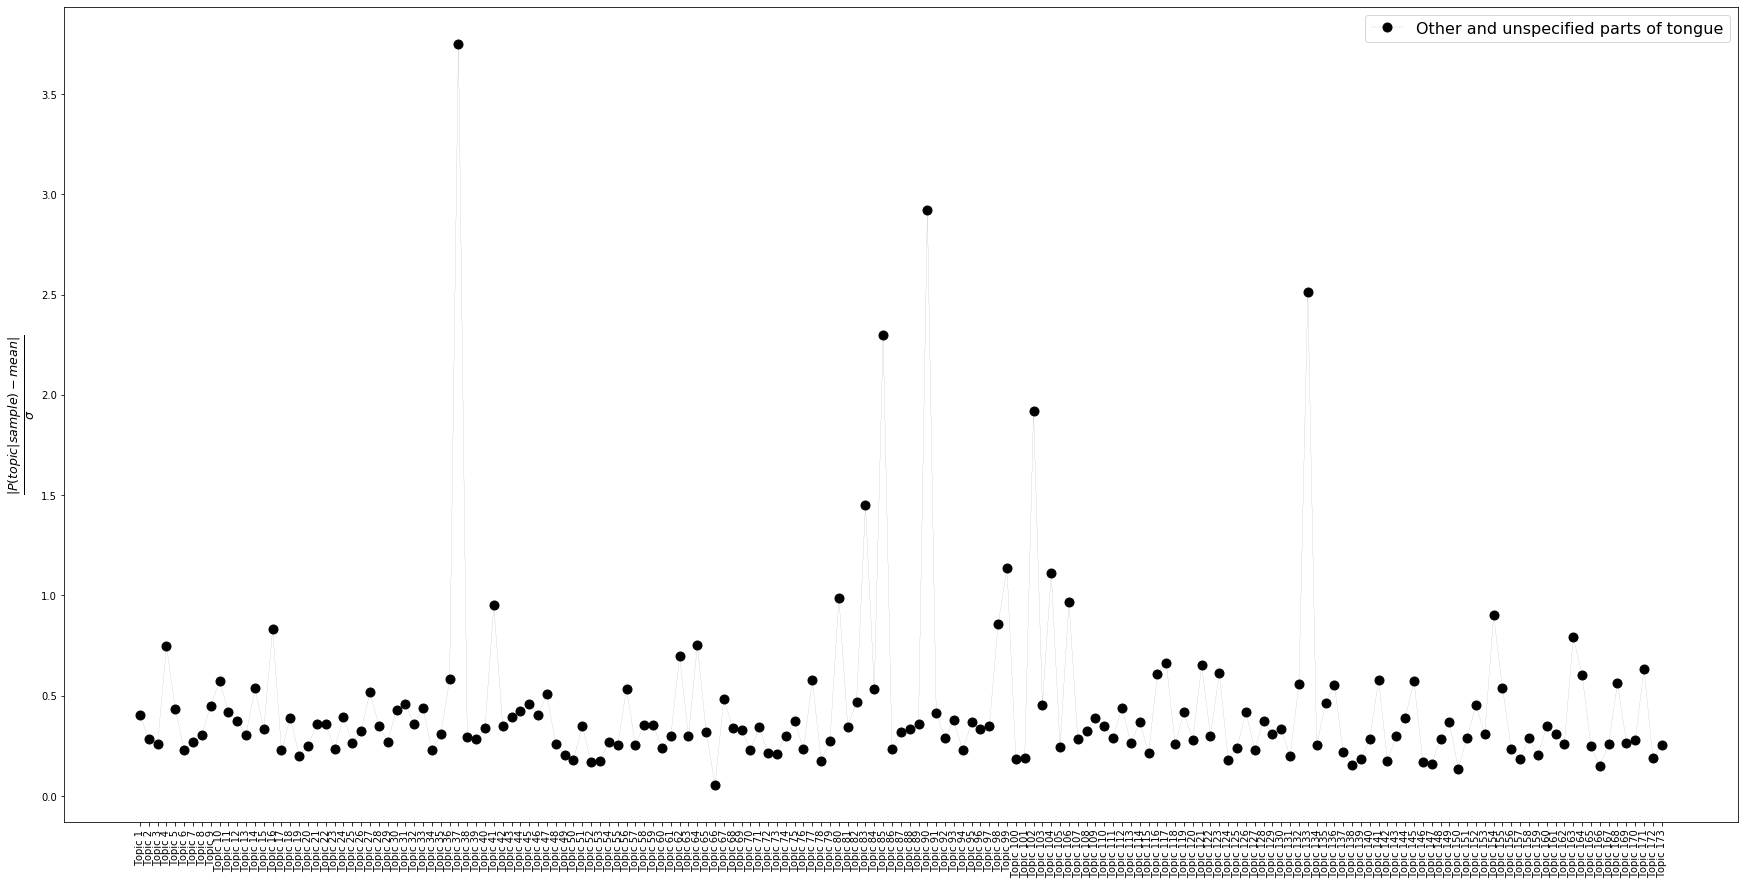

Eye and adnexa


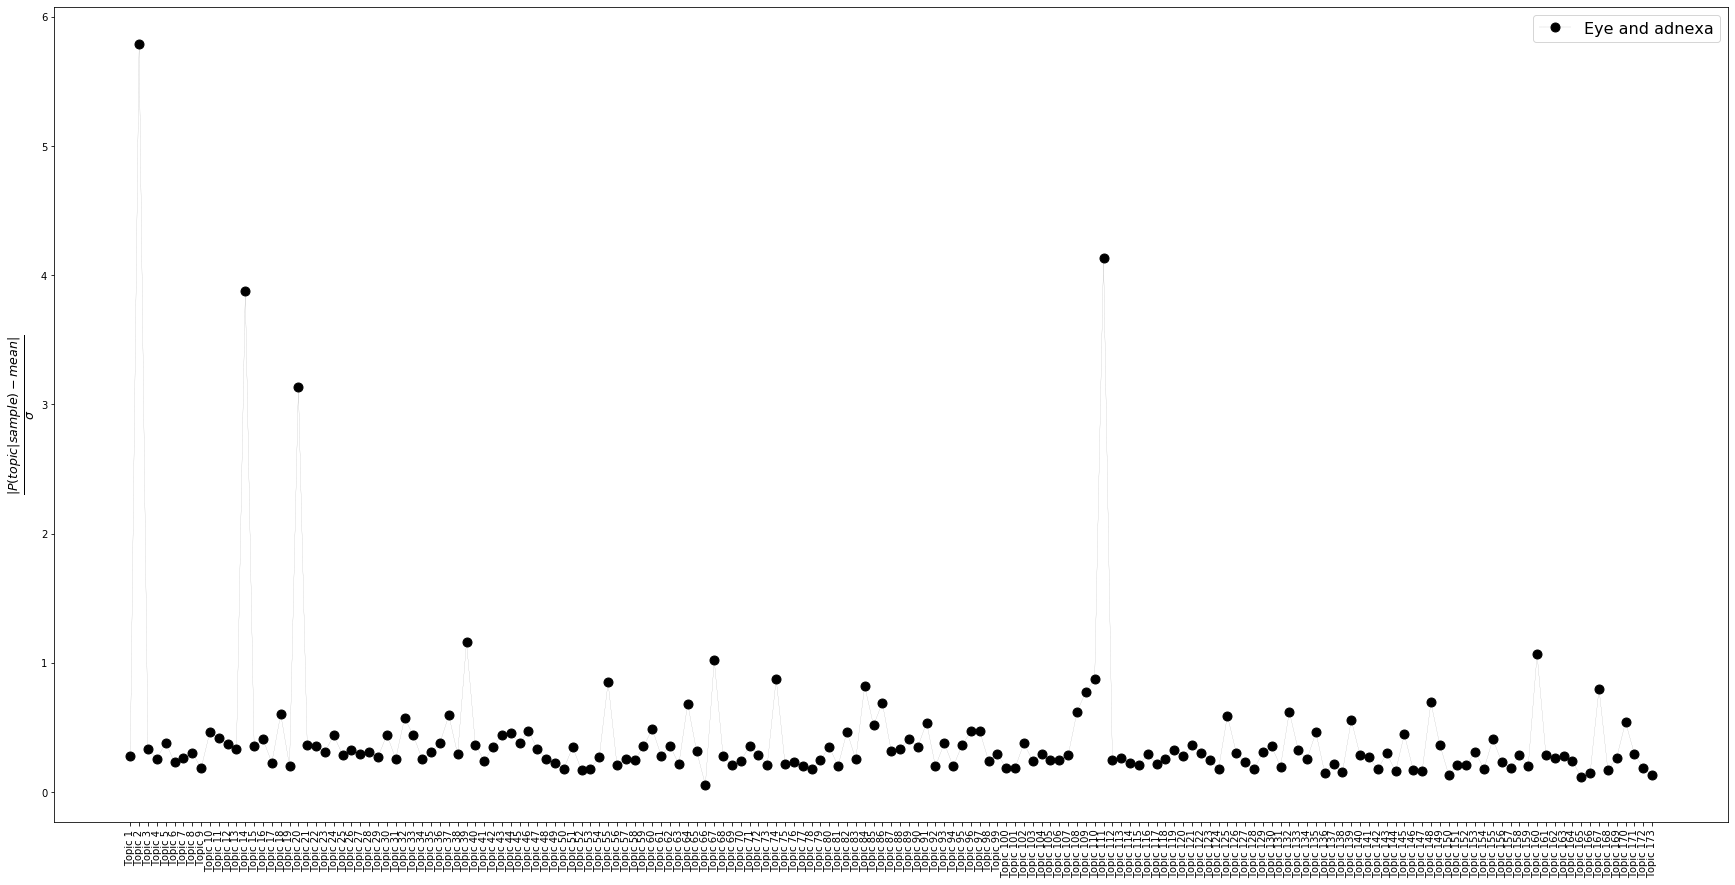

Palate


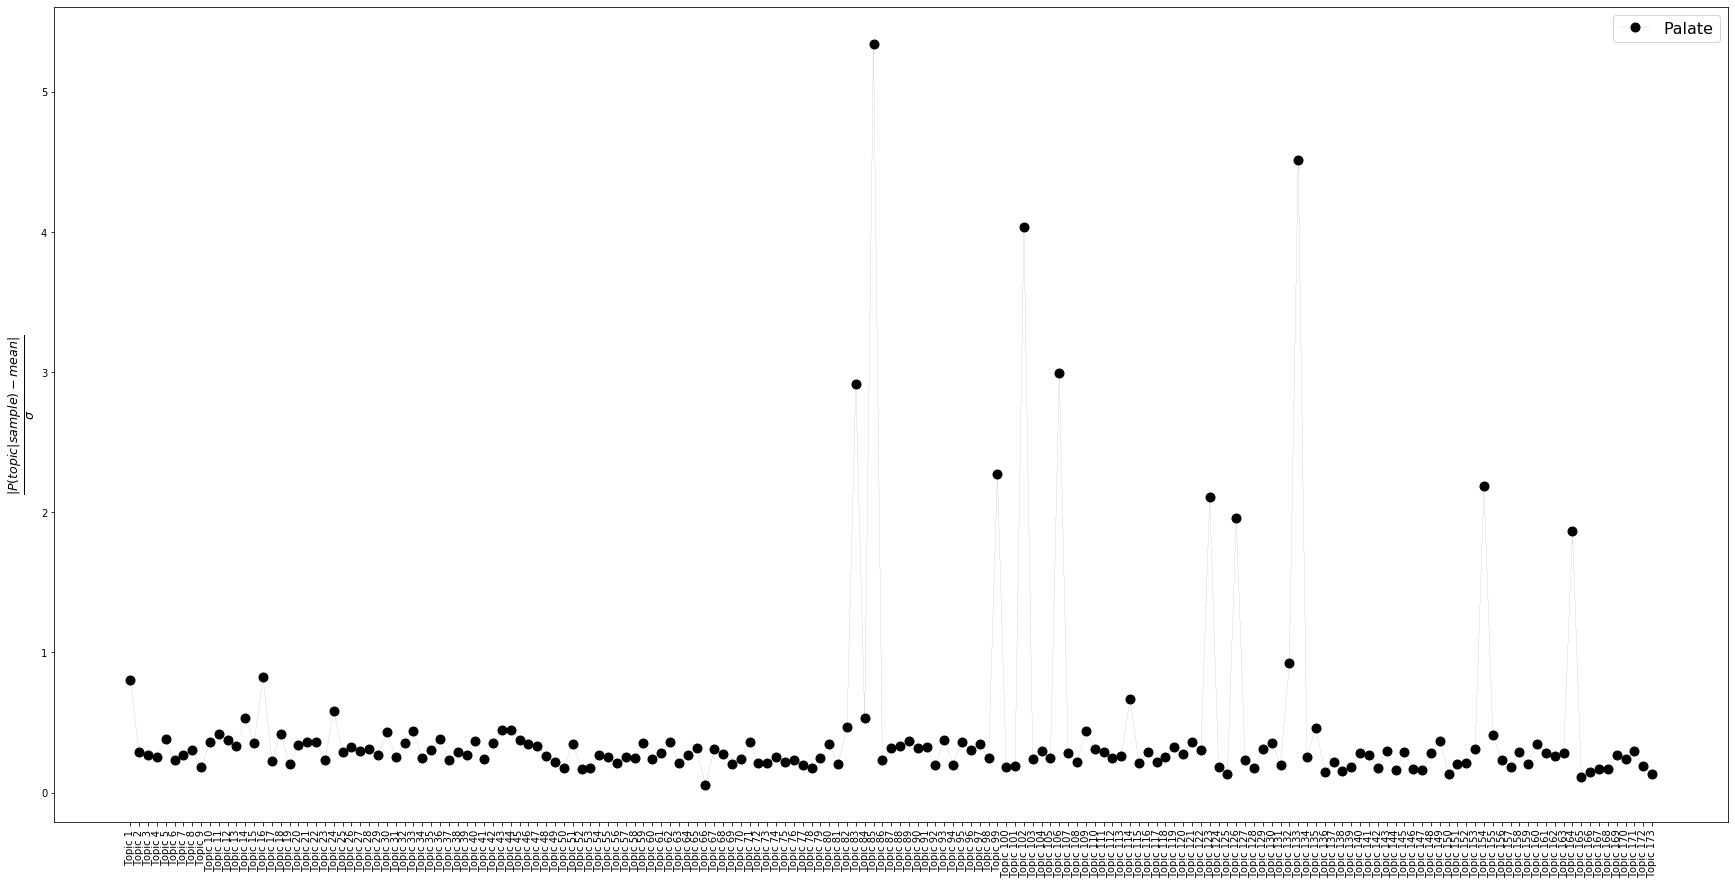

Stomach


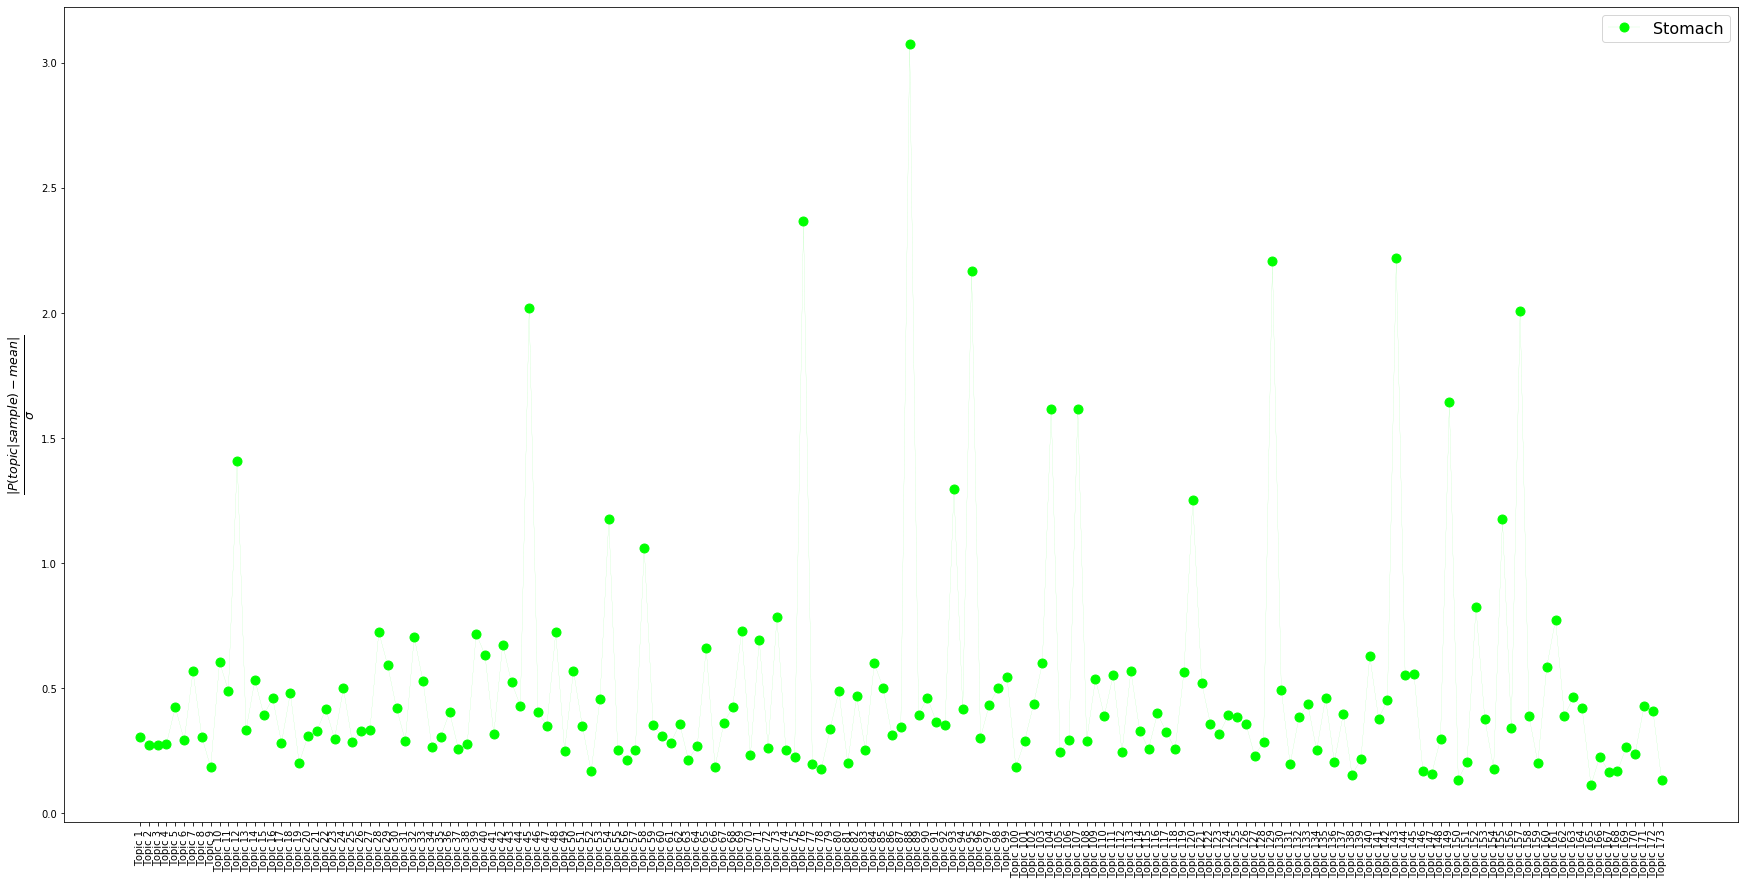

Retroperitoneum and peritoneum


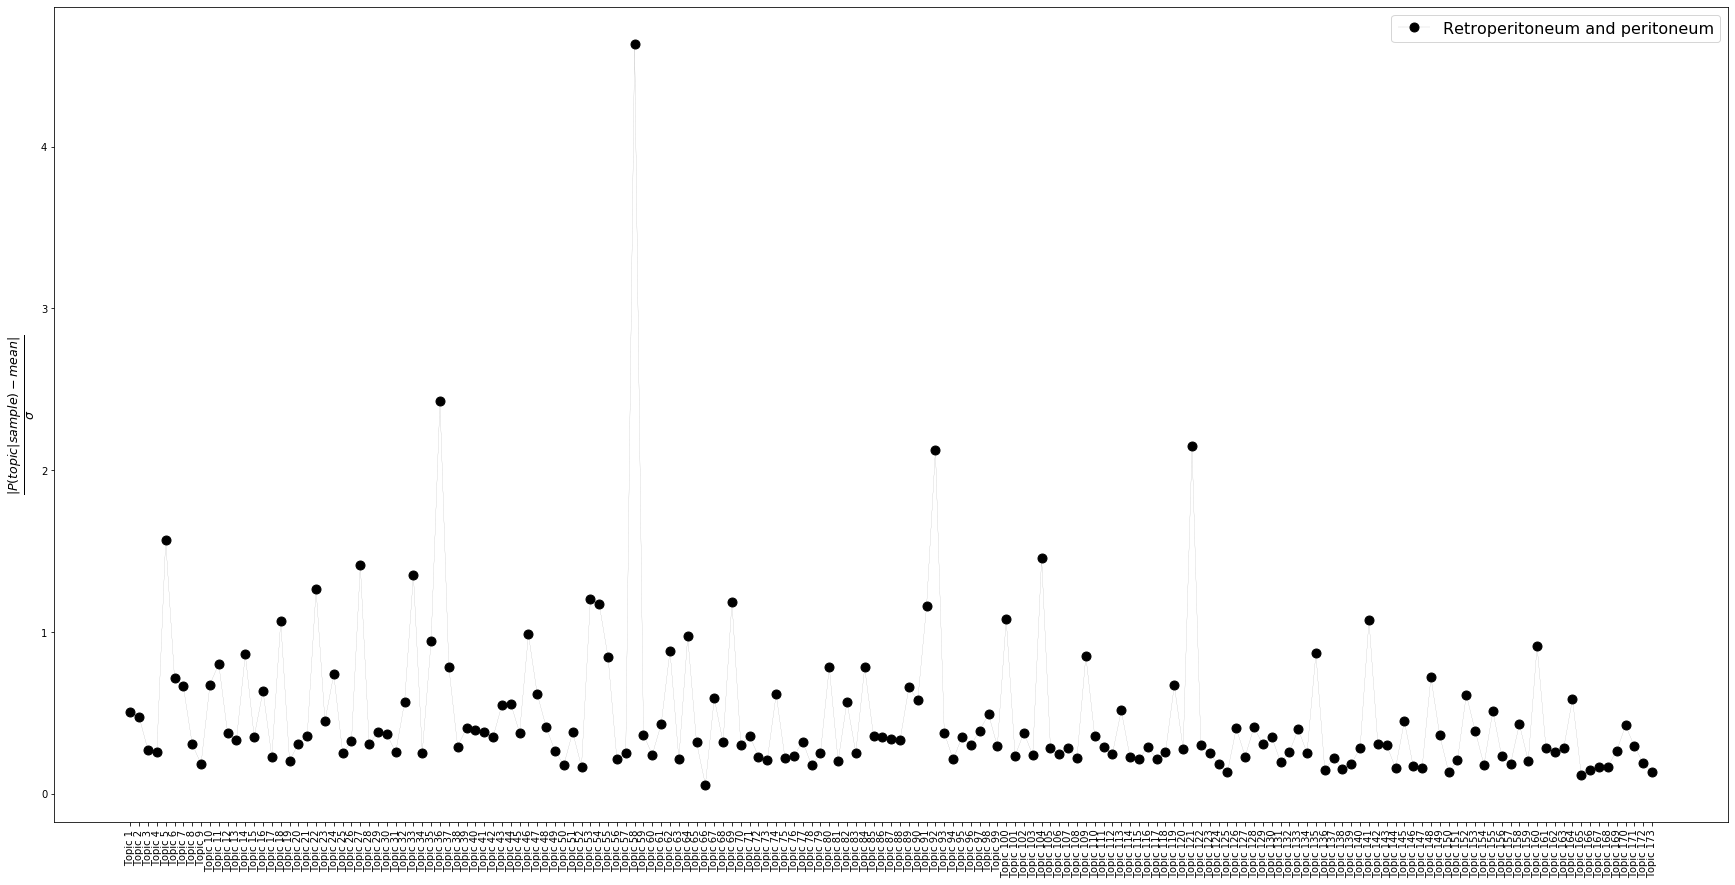

Pancreas


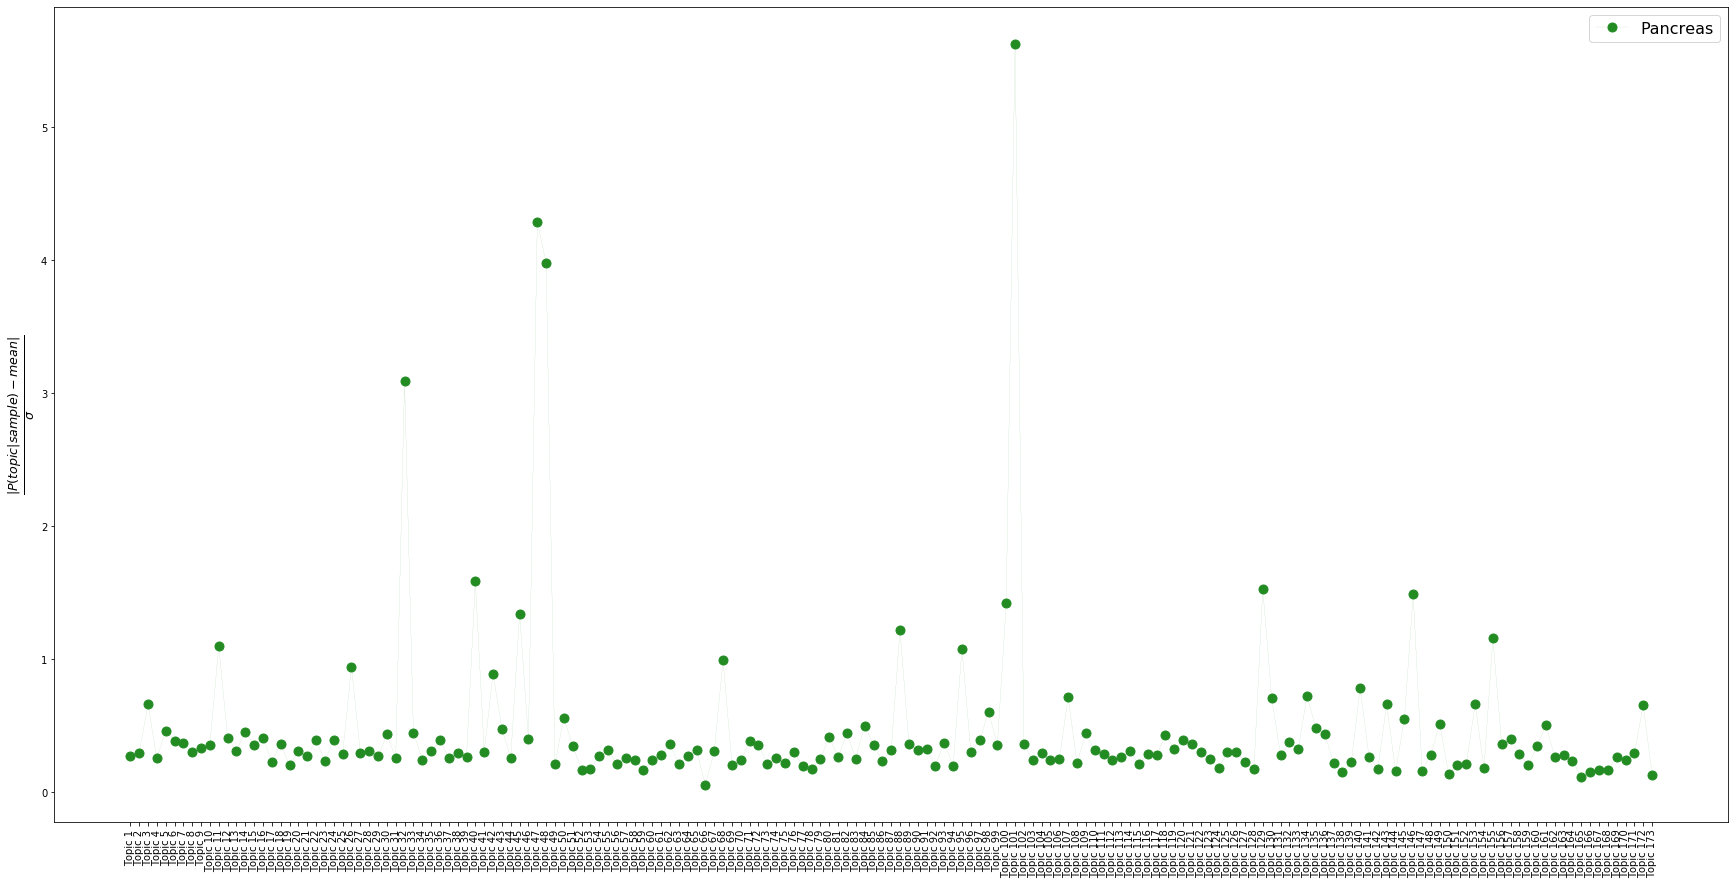

Thyroid gland


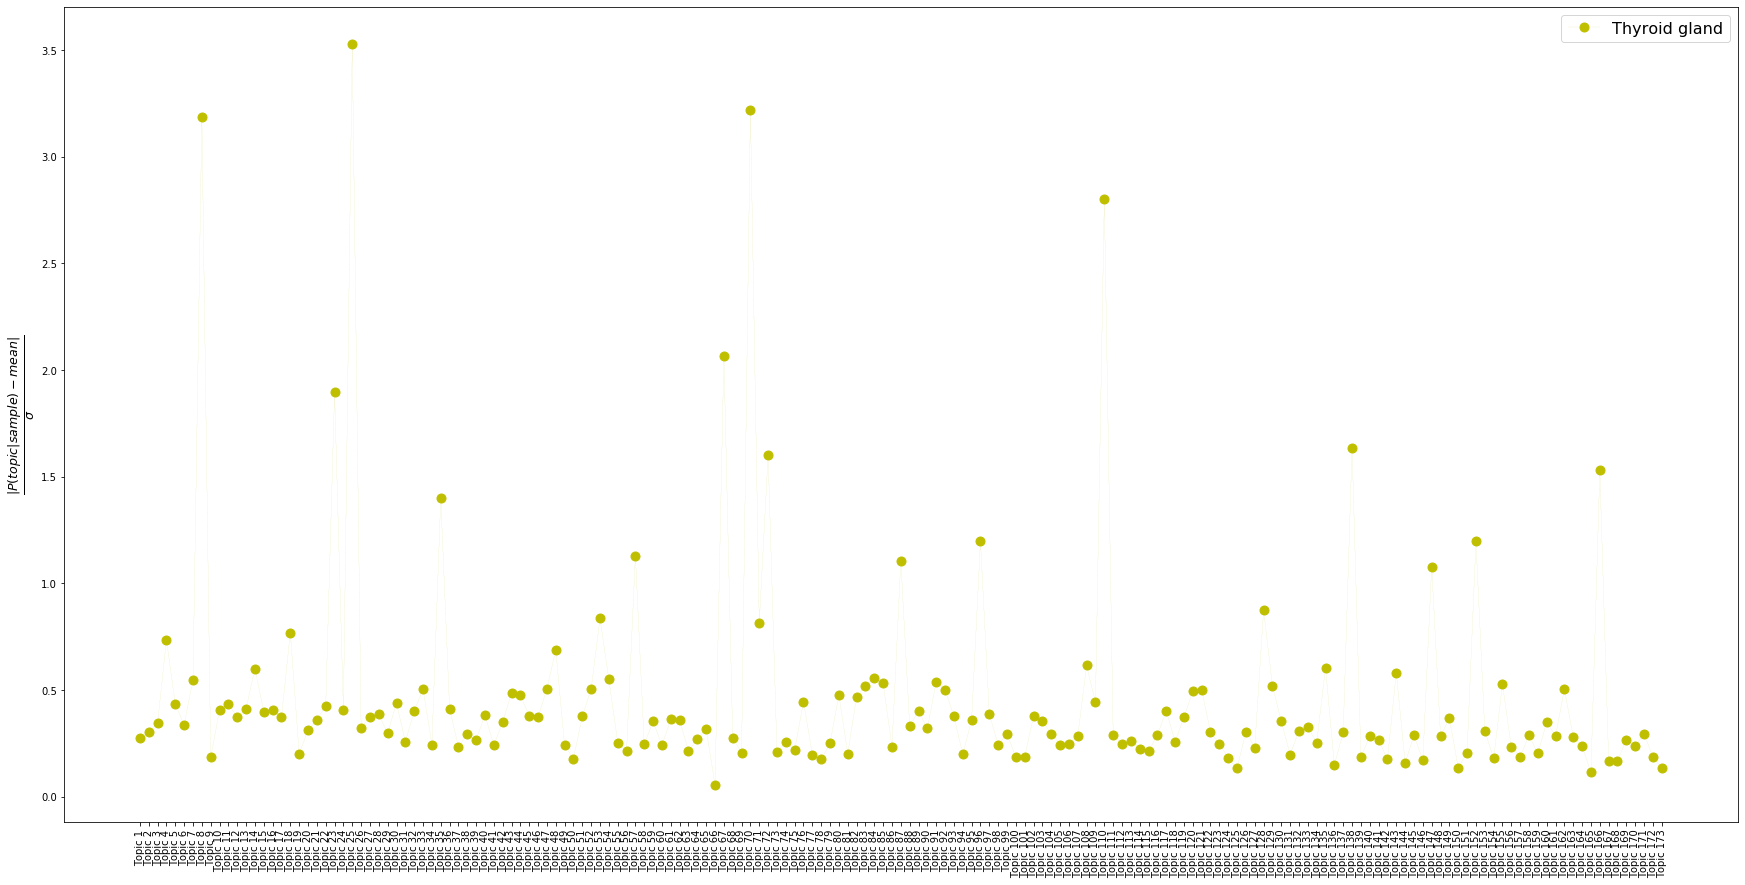

Brain


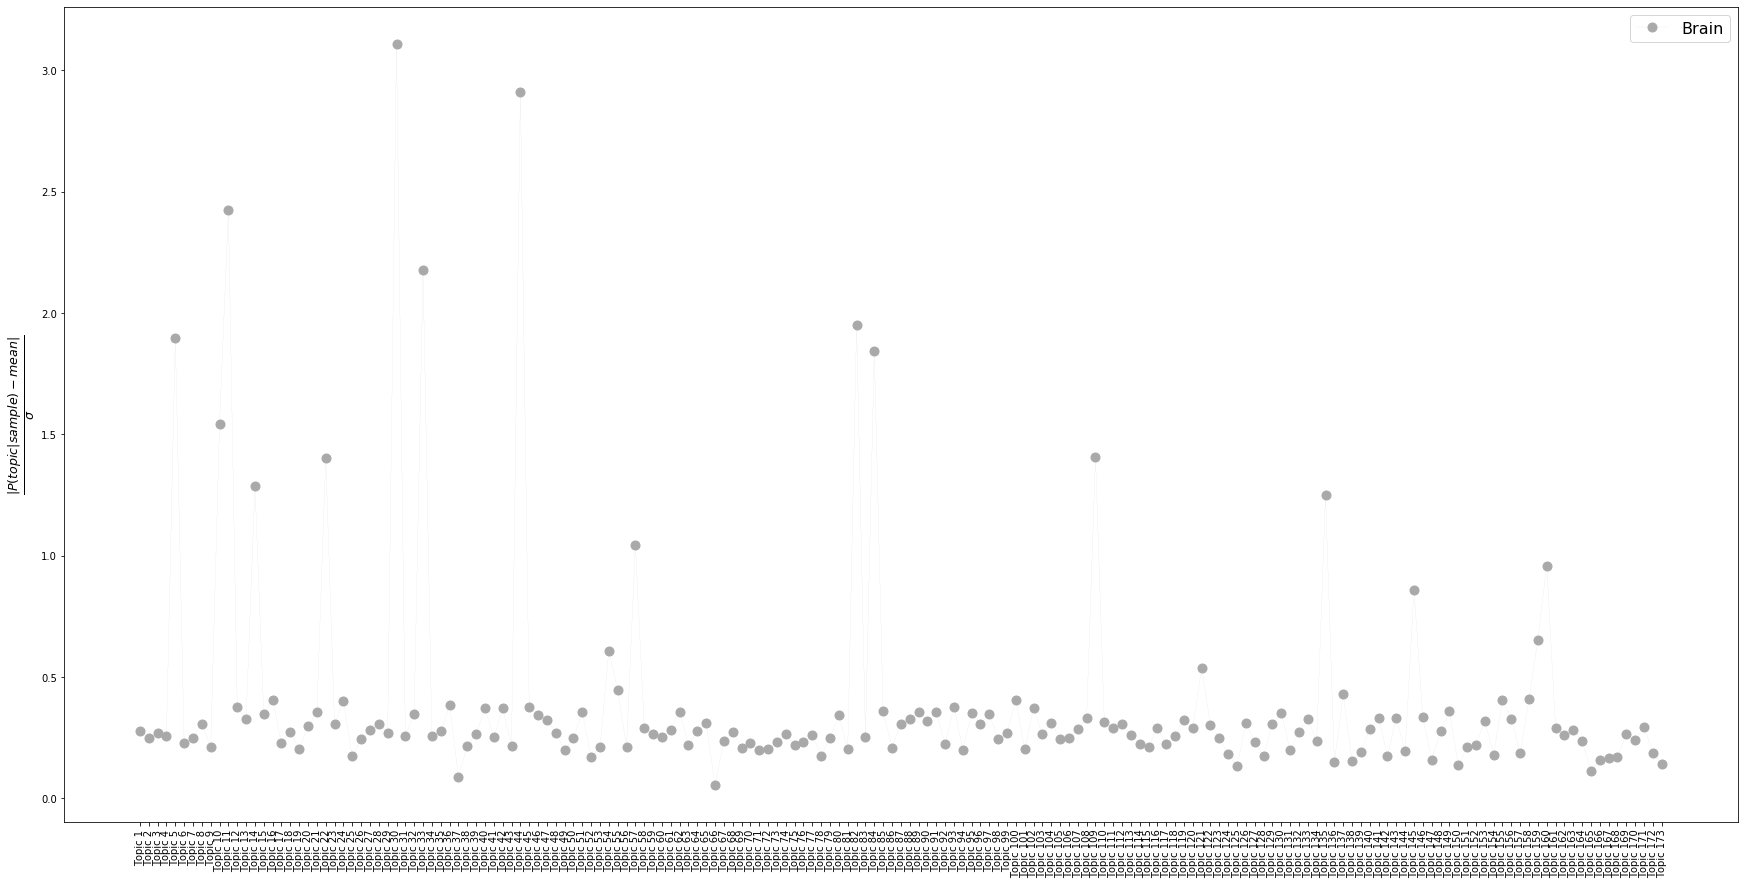

Cervix uteri


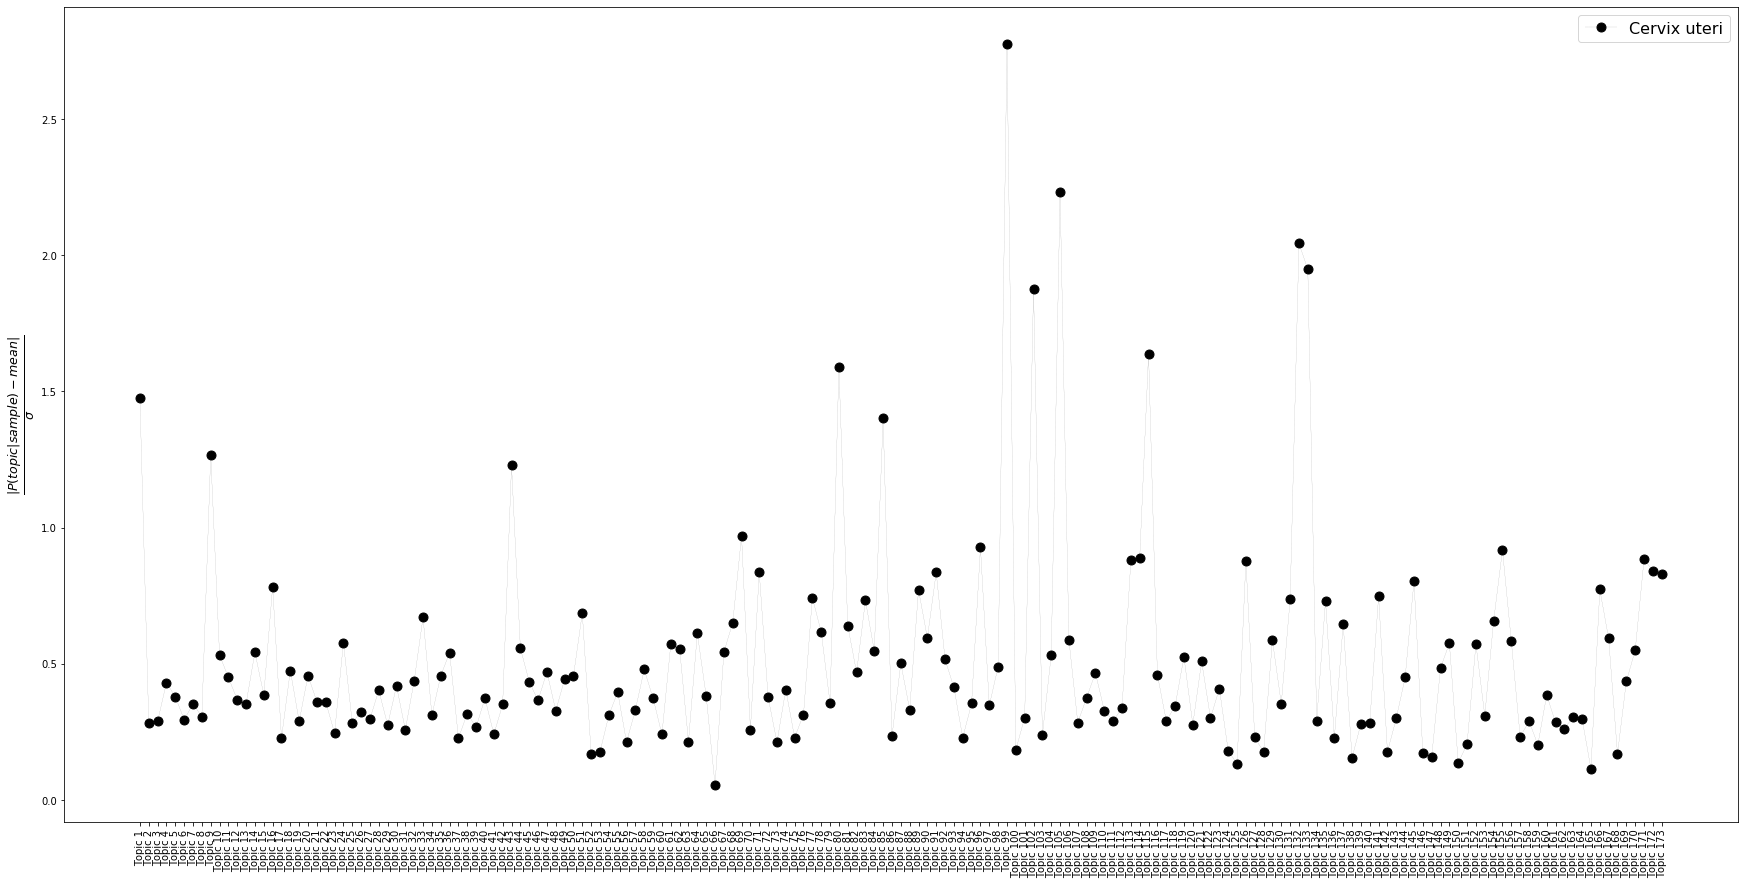

Testis


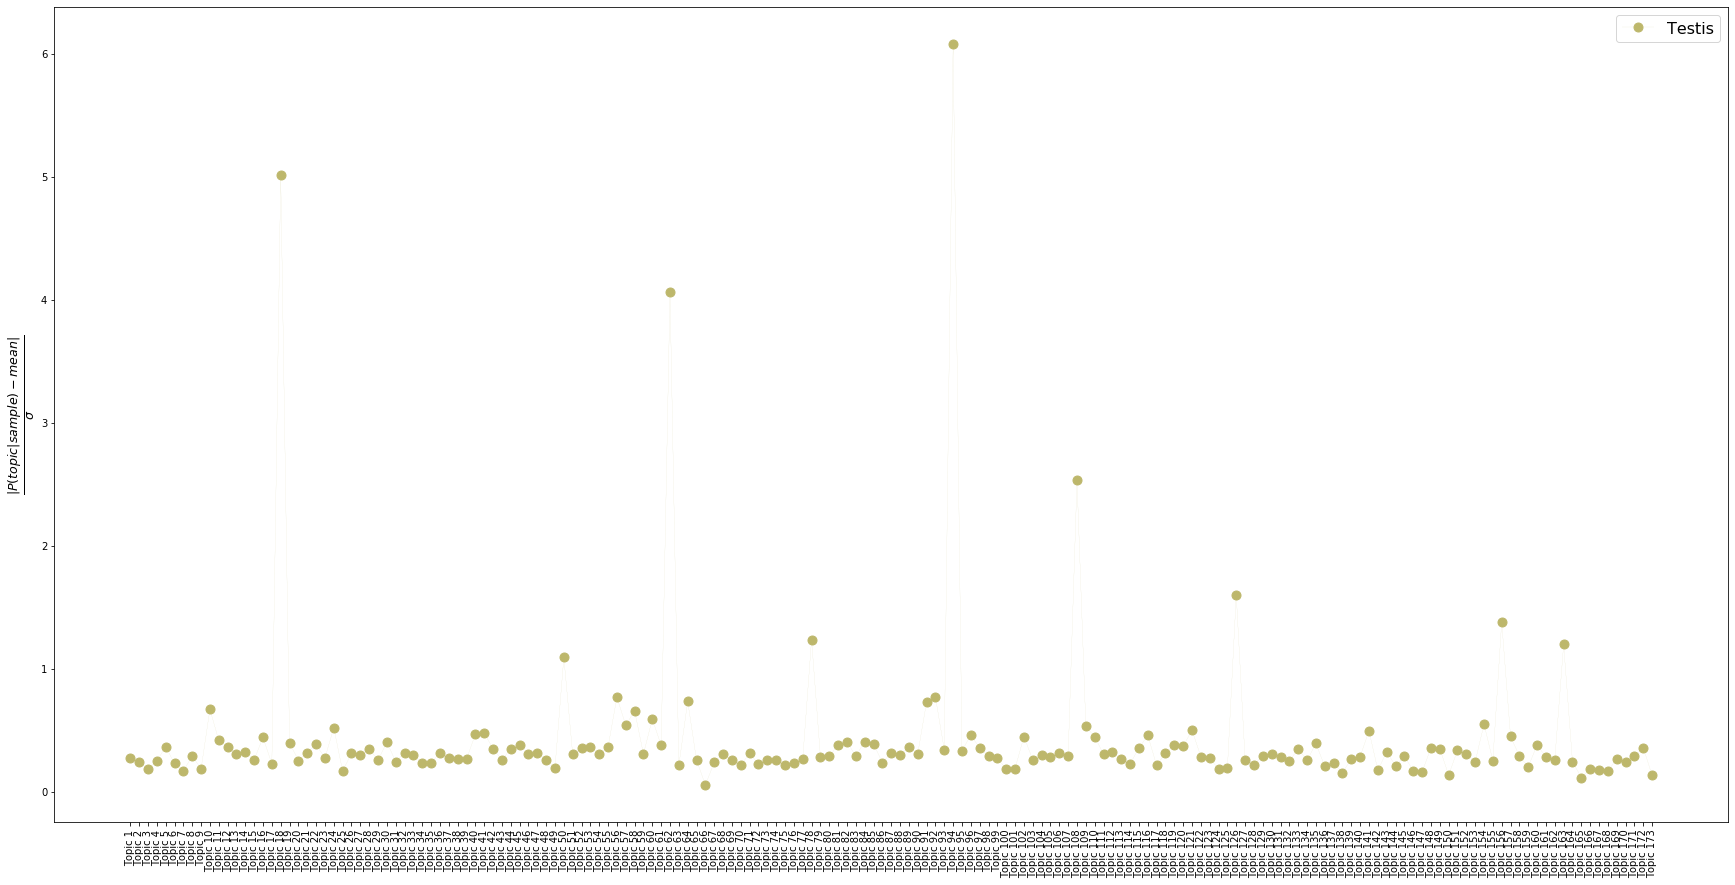

Connective, subcutaneous and other soft tissues


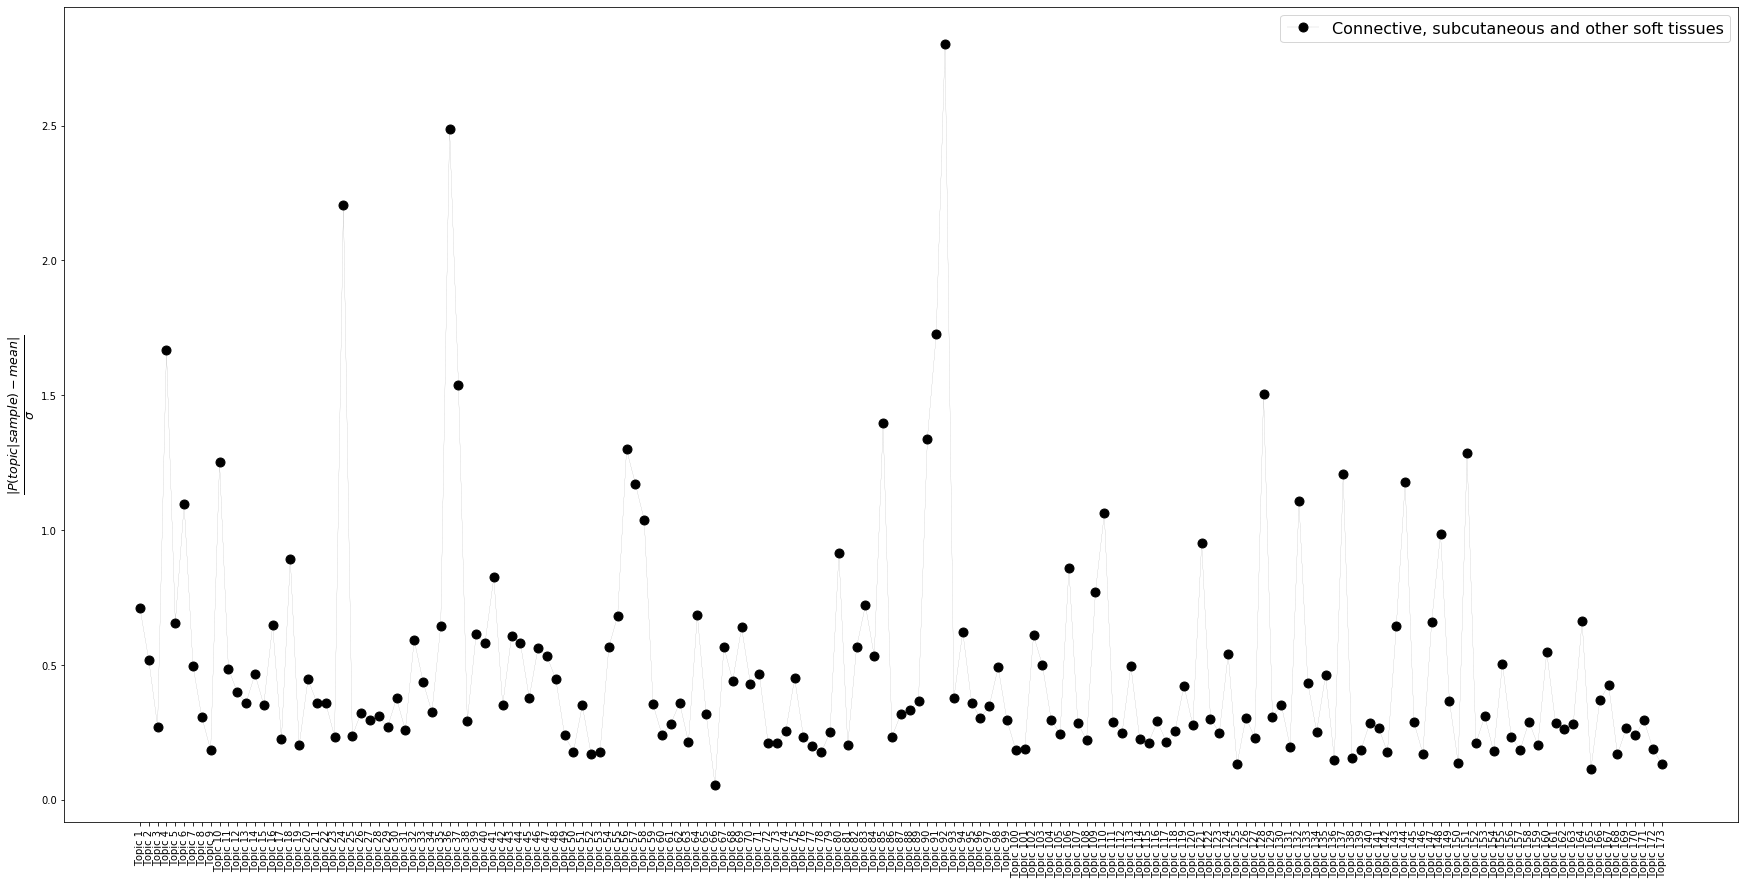

Larynx


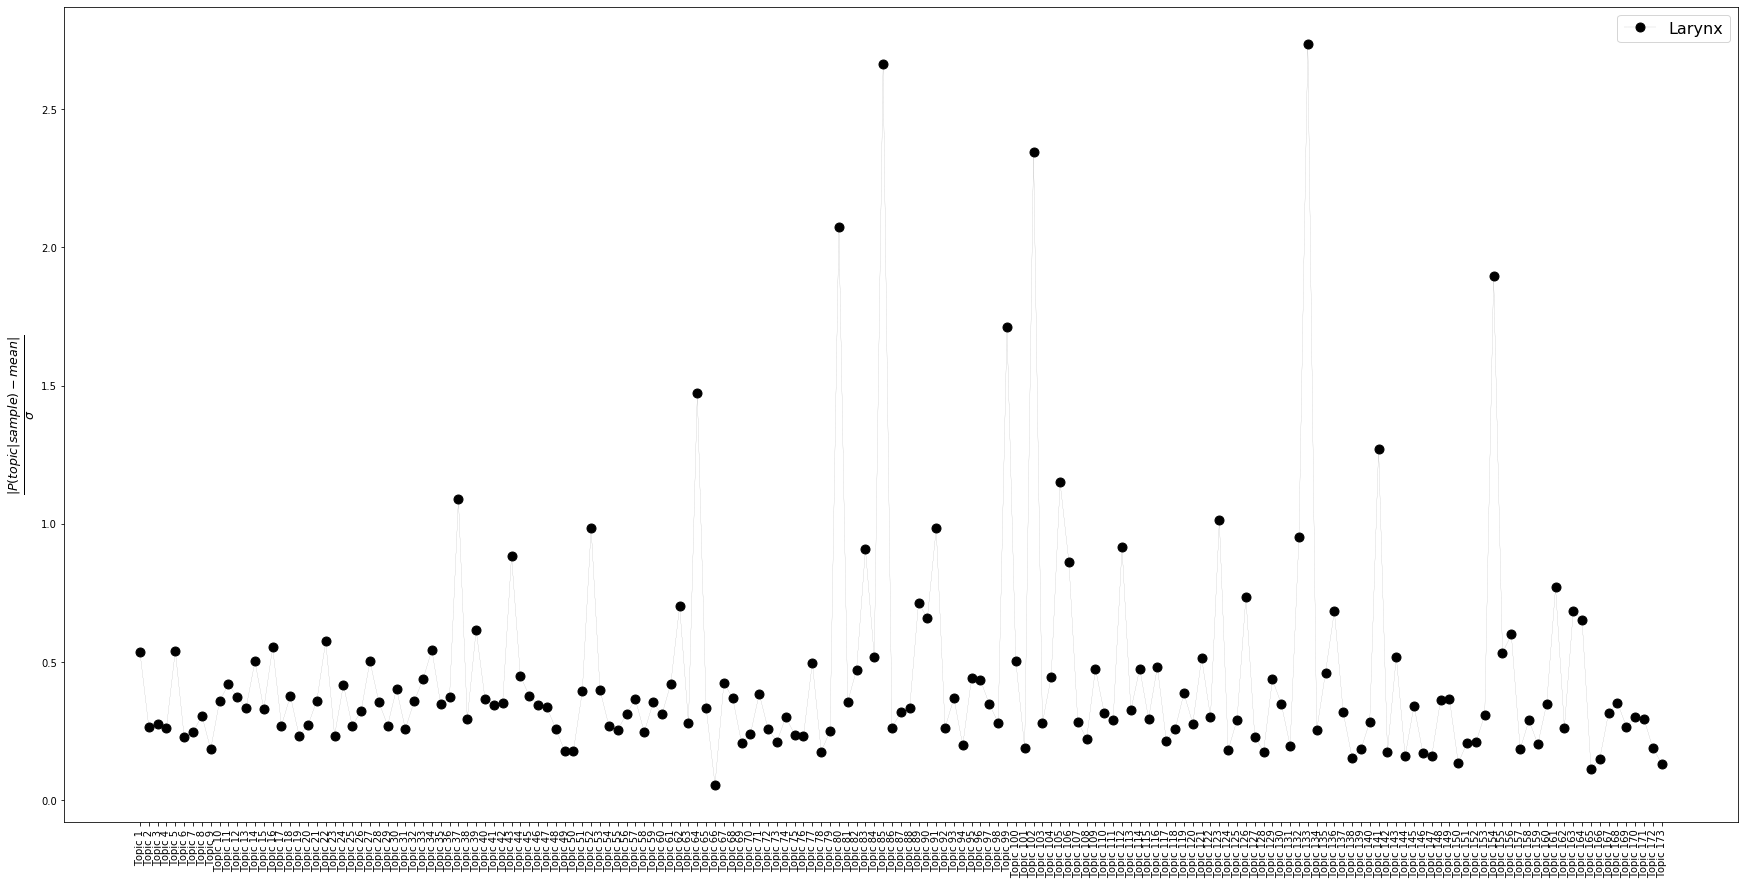

Prostate gland


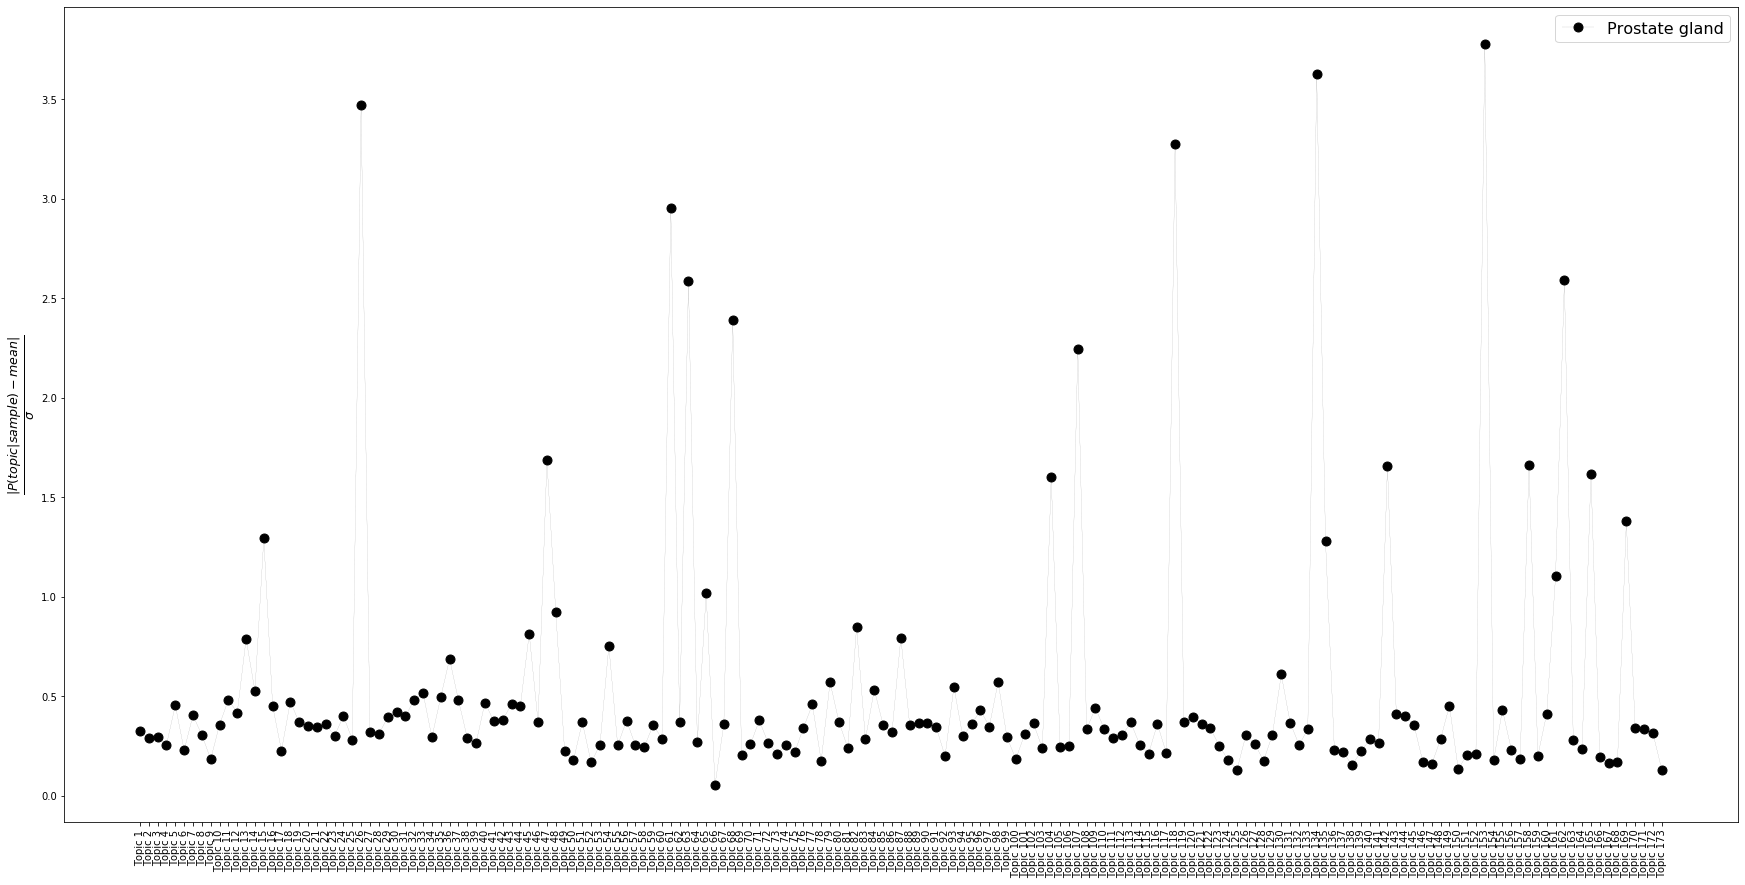

Other and unspecified parts of biliary tract


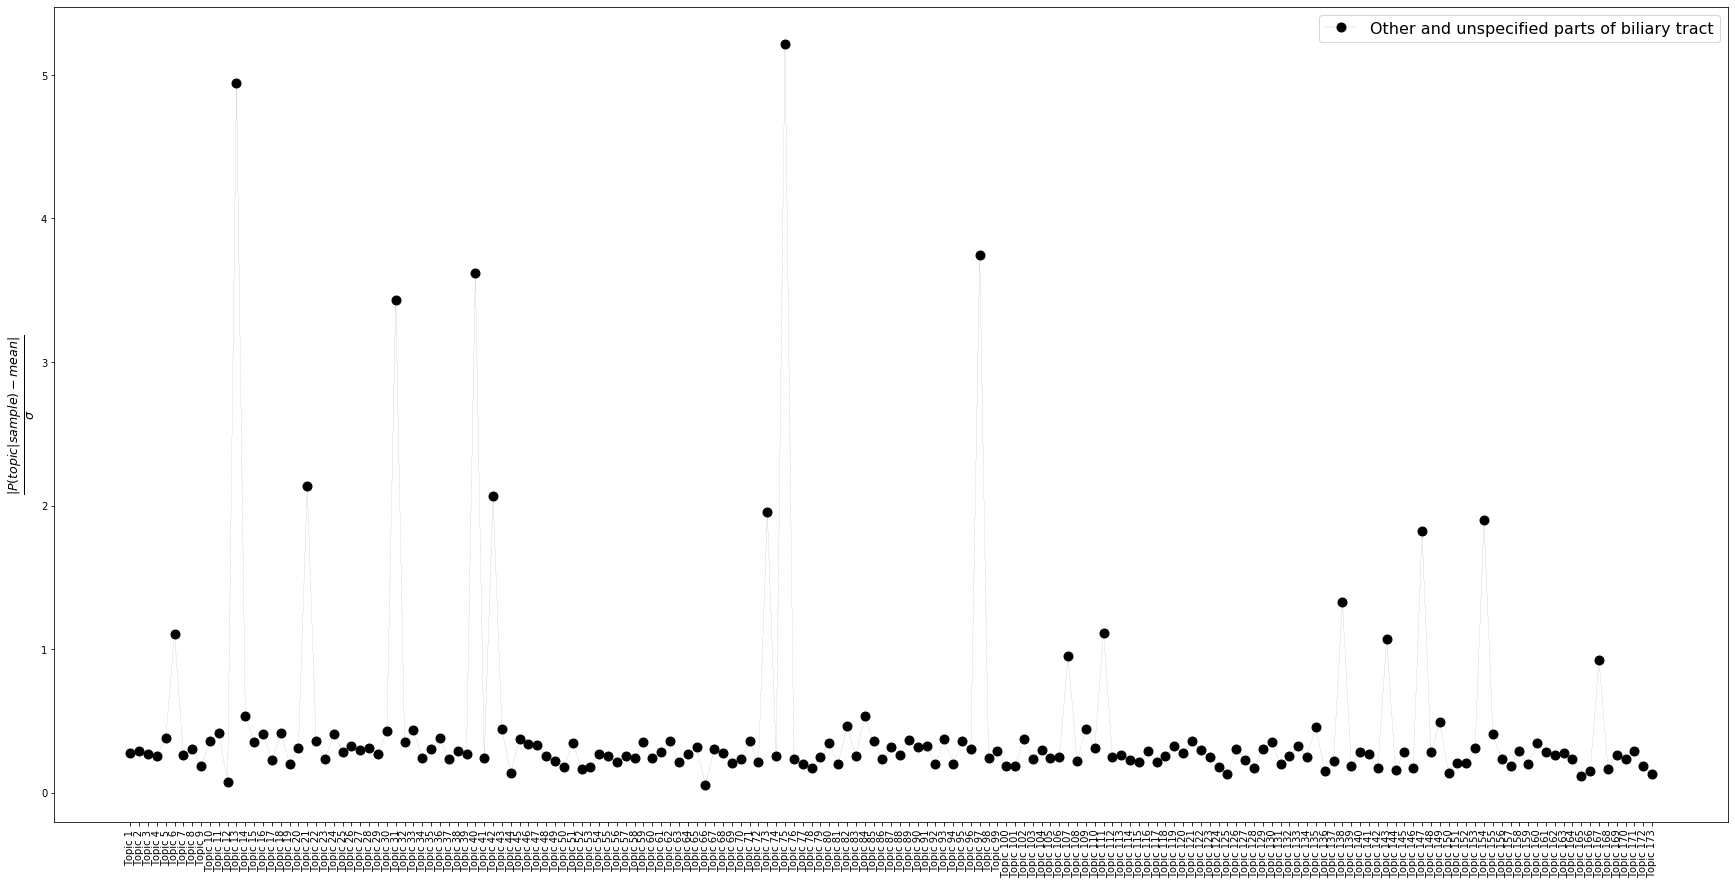

Ovary


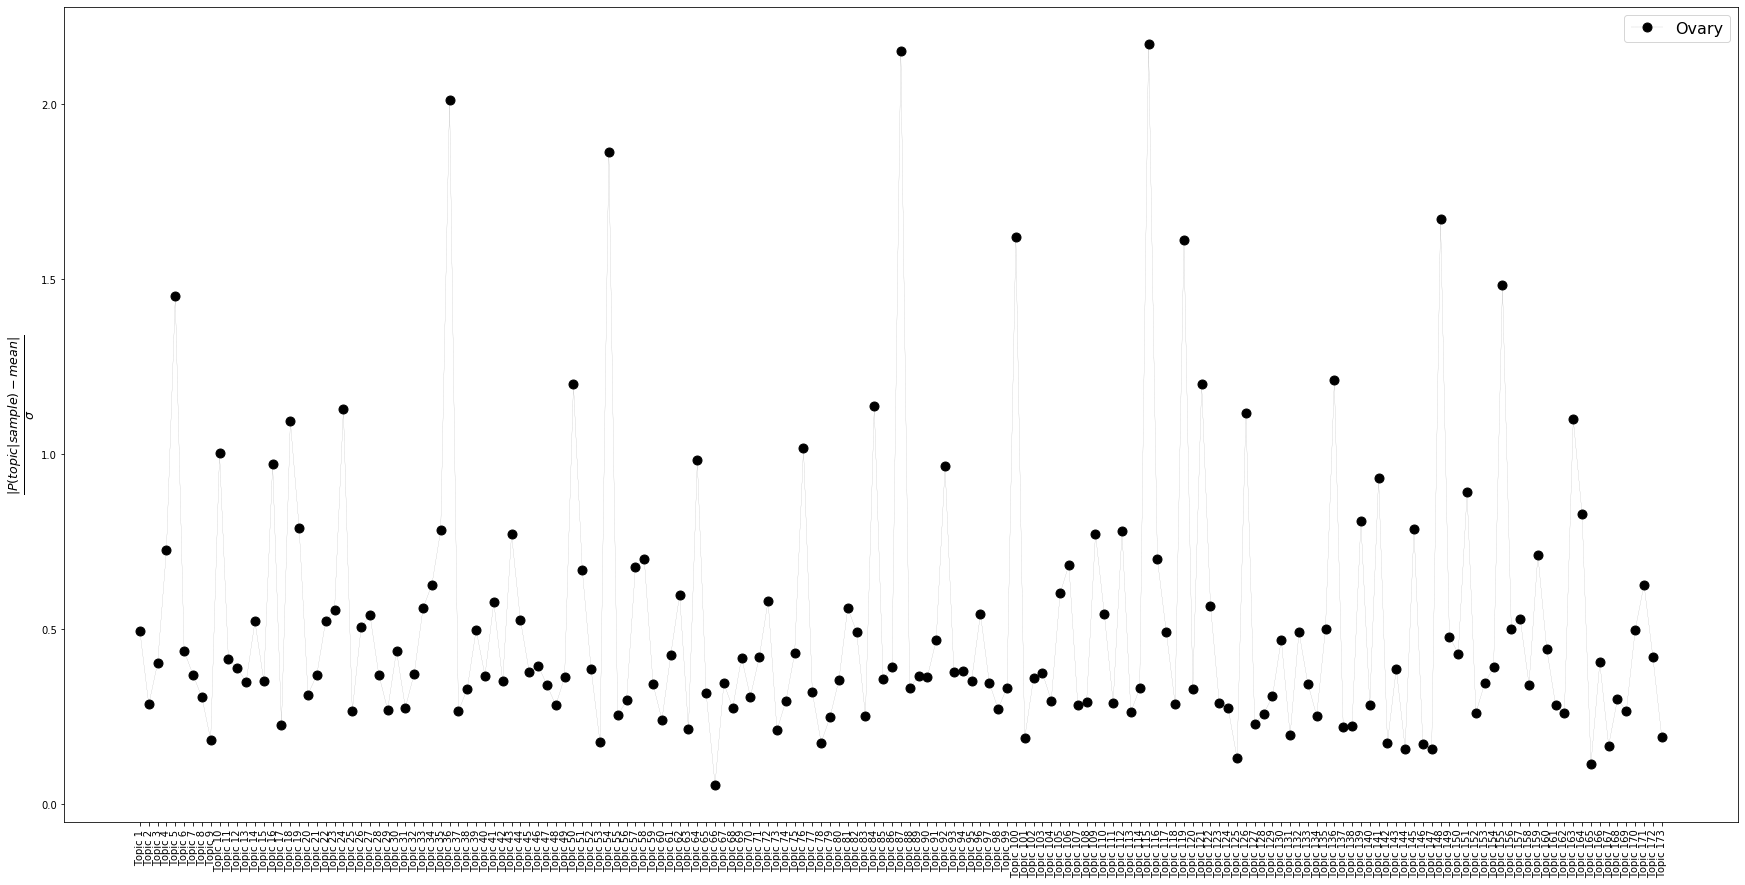

Breast


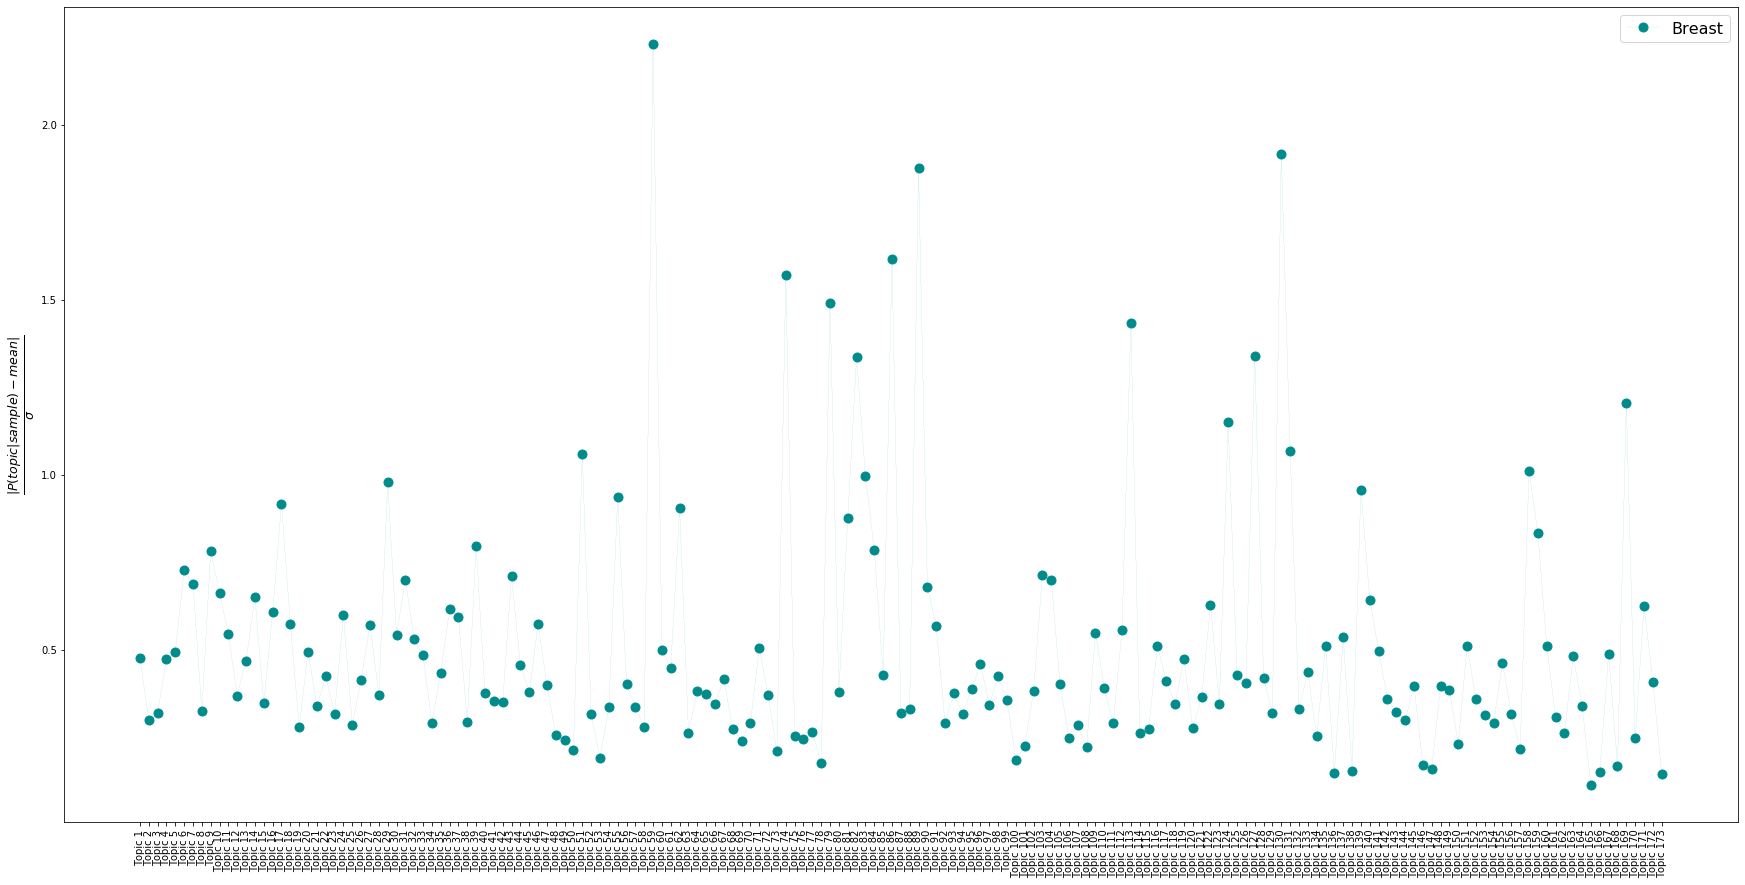

In [169]:
fig=plt.figure(figsize=(30,15))
label='tissue'
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    i_docs = sql.sql("SELECT i_doc, %s FROM topic WHERE %s='%s'"%(label, label,tissue)).select('i_doc').toPandas().astype(int).values.T[0]
    fig=plt.figure(figsize=(30,15))
    plt.plot(np.mean(result[0][i_docs],axis=0)[l_topics_i], marker=marker, lw=0.1, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
    plt.legend(fontsize=16, ncol=4)
    plt.ylabel("$\\frac{\\left|P(topic | sample) - mean\\right|}{\sigma}$", fontsize=18)
    plt.xticks(ticks=np.linspace(0,len(l_topics_i)-1,num=len(l_topics_i)), labels=low_occ_topics, rotation=90)
    plt.show()
    fig.savefig("%s/lifeplot_normalised_%s_%s.pdf"%(directory,label,tissue))

In [ ]:
tf.reset_default_graph()
sc.stop()

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import get_tissue_style

Skin


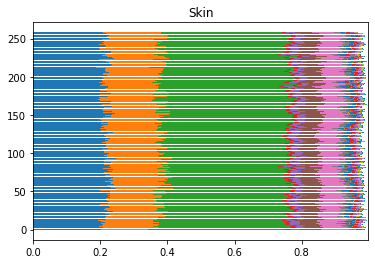

Adipose Tissue


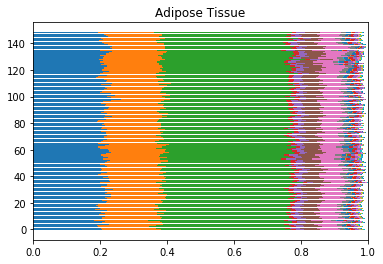

Blood


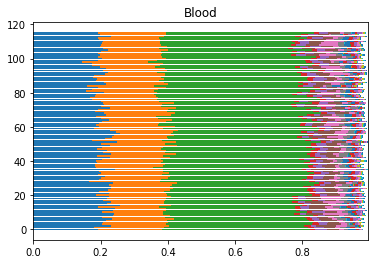

Thyroid


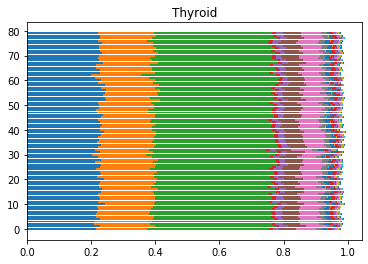

Pancreas


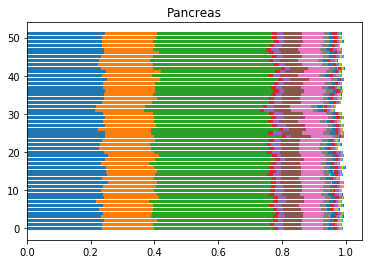

Brain


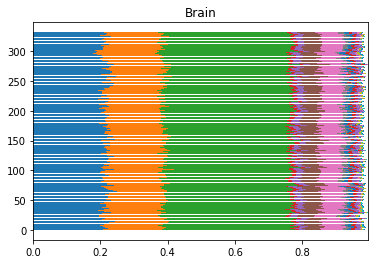

Lung


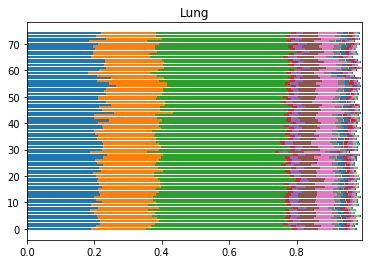

Testis


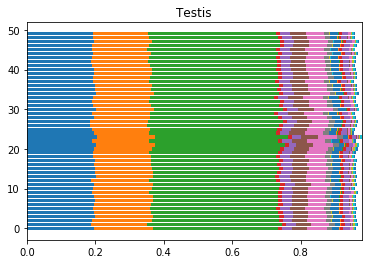

Breast


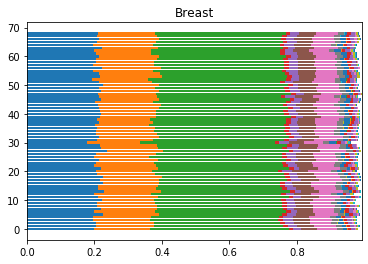

In [61]:
for tissue in df_topics.select(label).distinct().toPandas().values.T[0][:]:
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = sql.sql("SELECT * FROM topic WHERE tissue='%s'"%tissue).toPandas().drop(['i_doc', 'doc', 'status', 'tissue','second_tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.index:
        if t>20:
            break
        plt.barh(df_visual.index.values,df_visual["Topic %d"%(t+1)].values,left=width)
        width+=df_visual["Topic %d"%(t+1)].values
    plt.show()
    fig.savefig("%s/topicvisual_%s.png"%(directory,tissue))